# <font color='red'>Backtest vectorizado para una estrategia KALMAN.</font>

### Hackeado by J3viton (learning BackTesting 2022).

# KALMAN

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis

import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'nvda'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2008,1,2)
Fecha_Final_Backtesting    = dt.datetime(2021,11,18)
Fecha_Final_Backtesting    = dt.datetime.today()

import kalman as rg  #cambiar segun el módulo con la estrategia implementado


{'can_join_groups': True, 'can_read_all_group_messages': False, 'first_name': 'vital_bot', 'id': 1473252352, 'is_bot': True, 'supports_inline_queries': False, 'username': 'vital_quant_bot'}


***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 =dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=1000) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   5116 sesiones
Tamaño de la ventana a analizar paso a paso:   1000 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,8.5300,8.5625,8.1400,8.2525,7.580831,48396400
2008-01-03,8.3000,8.4650,8.1575,8.1875,7.521122,47530800
2008-01-04,7.9425,7.9825,7.4500,7.5000,6.889578,73609200
2008-01-07,7.5500,7.6125,6.5875,6.7250,6.177657,100680000
2008-01-08,6.7625,7.3225,6.6050,6.8675,6.308557,110695600


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(real_back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30',
               '2021-12-31', '2022-01-03'],
              dtype='datetime64[ns]', name='Date', length=3527, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2008-01-05'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


end date: 2010-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
!
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2010-10-01   2.8375   0.234867        99
................................................Analizando, muestra 0 de 5116 fecha 2010-10-01
end date: 2010-10-02
..............Día sin sesión, next please
end date: 2010-10-03
..............Día sin sesión, next please
end date: 2010-10-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3 de 5116 fecha 2010-10-04
end date: 2010-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4 de 5116 fecha 2010-10-05
end date: 2010-10-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 5 de 5116 fecha 2010-10-06
end date: 2010-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2010-10-07   2.675   0.234395        99
................................................Analizando, muestra 6 de 5116 fecha 2010-10-07
end date: 2010-10-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 7 de 5116 fecha 2010-10-08
end date: 2010-10-09
..............Día sin sesión, next please
end date: 2010-10-10
..............Día sin sesión, next please
end date: 2010-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying 

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2010-10-07   2.675   0.234395        99
................................................Analizando, muestra 10 de 5116 fecha 2010-10-11
end date: 2010-10-12
 datos desde archivo
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2010-10-07   2.675   0.234395        99
................................................Analizando, muestra 11 de 5116

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_mean

 fecha 2010-10-12
end date: 2010-10-13
 datos desde archivo


C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2010-10-07   2.675   0.234395        99
................................................Analizando, muestra 12 de 5116 fecha 2010-10-13
end date: 2010-10-14
 datos desde archivo


C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2010-10-07   2.675   0.234395        99
................................................Analizando, muestra 13 de 5116 fecha 2010-10-14
end date: 2010-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2010-10-15   2.8225   0.209128        99
................................................Analizando, muestra 14 de 5116 fecha 2010-10-15
end date: 2010-10-16
..............Día sin sesión, next please
end date: 2010-10-17
..............Día sin sesión, next please
end date: 2010-10-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 17 de 5116 fecha 2010-10-18
end date: 2010-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 18 de 5116 fecha 2010-10-19
end date: 2010-10-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 19 de 5116 fecha 2010-10-20
end date: 2010-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 20 de 5116 fecha 2010-10-21
end date: 2010-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying 

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2010-10-22   2.950   0.226225        99
................................................Analizando, muestra 21 de 5116 fecha 2010-10-22
end date: 2010-10-23
..............Día sin sesión, next please
end date: 2010-10-24
..............Día sin sesión, next please
end date: 2010-10-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


................................................Analizando, muestra 24 de 5116 fecha 2010-10-25
end date: 2010-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 25 de 5116 fecha 2010-10-26
end date: 2010-10-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 26 de 5116 fecha 2010-10-27
end date: 2010-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 27 de 5116 fecha 2010-10-28
end date: 2010-10-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 28 de 5116 fecha 2010-10-29
end date: 2010-10-30
..............Día sin sesión, next please
end date: 2010-10-31
..............Día sin sesión, next please
end date: 2010-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 31 de 5116 fecha 2010-11-0

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 42 de 5116 fecha 2010-11-12
end date: 2010-11-13
..............Día sin sesión, next please
end date: 2010-11-14
..............Día sin sesión, next please
end date: 2010-11-15


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 45 de 5116 fecha 2010-11-15
end date: 2010-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 46 de 5116 fecha 2010-11-16
end date: 2010-11-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 47 de 5116 fecha 2010-11-17
end date: 2010-11-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 48 de 5116 fecha 2010-11-18
end date: 2010-11-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 49 de 5116 fecha 2010-11-19
end date: 2010-11-20
..............Día sin sesión, next please
end date: 2010-11-21
..............Día sin sesión, next please
end date: 2010-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2010-11-22   3.440   0.219016        99
................................................Analizando, muestra 52 de 5116 fecha 2010-11-22
end date: 2010-11-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 53 de 5116 fecha 2010-11-23
end date: 2010-11-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 54 de 5116 fecha 2010-11-24
end date: 2010-11-25
..............Día sin sesión, next please
end date: 2010-11-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 56 de 5116 fecha 2010-11-26
end date: 2010-11-27
..............Día sin sesión, next please
end date: 2010-11-28
..............Día sin sesión, next please
end date: 2010-11-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 59 de 5116 fecha 2010-11-29
end date: 2010-11-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 60 de 5116 fecha 2010-11-30
end date: 2010-12-01
aqui estoy en out
 datos desde archivo
...............................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2010-12-06   3.6275   0.211724        99
................................................Analizando, muestra 66 de 5116 fecha 2010-12-06
end date: 2010-12-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 67 de 5116 fecha 2010-12-07
end date: 2010-12-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 68 de 5116 fecha 2010-12-08
end date: 2010-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 69 de 5116 fecha 2010-12-09
end date: 2010-12-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 70 de 5116 fecha 2010-12-10
end date: 2010-12-11
..............Día sin sesión, next please
end date: 2010-12-12
..............Día sin sesión, next please
end date: 2010-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 73 de 5116 fecha 2010-12-13
end date: 2010-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 74 de 5116 fecha 2010-12-1

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-01-03   3.955   0.194478        99
................................................Analizando, muestra 94 de 5116 fecha 2011-01-03
end date: 2011-01-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 95 de 5116 fecha 2011-01-04
end date: 2011-01-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 96 de 5116 fecha 2011-01-05
end date: 2011-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-01-06   4.8325   0.328901        99
................................................Analizando, muestra 97 de 5116 fecha 2011-01-06
end date: 2011-01-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 98 de 5116 fecha 2011-01-07
end date: 2011-01-08
..............Día sin sesión, next please
end date: 2011-01-09
..............Día sin sesión, next please
end date: 2011-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 101 de 5116 fecha 2011-01-10
end date: 2011-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 102 de 5116 fecha 2011-01-11
end date: 2011-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 103 de 5116 fecha 2011-01-12
end date: 2011-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-01-13   5.8475   0.537775        99
................................................Analizando, muestra 104 de 5116 fecha 2011-01-13
end date: 2011-01-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 105 de 5116 fecha 2011-01-14
end date: 2011-01-15
..............Día sin sesión, next please
end date: 2011-01-16
..............Día sin sesión, next please
end date: 2011-01-17
..............Día sin sesión, next please
end date: 2011-01-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 109 de 5116 fecha 2011-01-18
end date: 2011-01-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 110 de 5116 fecha 2011-01-19
end date: 2011-01-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 111 de 5116 fecha 2011-01-20
end date: 2011-01-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 112 de 5116 fecha 2011-01-21
end date: 2011-01-22
..............Día sin sesión, next please
end date: 2011-01-23
..

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-02-03   6.275   0.595901        99
................................................Analizando, muestra 125 de 5116 fecha 2011-02-03
end date: 2011-02-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 126 de 5116 fecha 2011-02-04
end date: 2011-02-05
..............Día sin sesión, next please
end date: 2011-02-06
..............Día sin sesión, next please
end date: 2011-02-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 129 de 5116 fecha 2011-02-07
end date: 2011-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 130 de 5116 fecha 2011-02-08
end date: 2011-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 131 de 5116 fecha 2011-02-09
end date: 2011-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 132 de 5116 fecha 2011-02-10
end date: 2011-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-02-11   5.8675   0.592026        99
................................................Analizando, muestra 133 de 5116 fecha 2011-02-11
end date: 2011-02-12
..............Día sin sesión, next please
end date: 2011-02-13
..............Día sin sesión, next please
end date: 2011-02-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 136 de 5116 fecha 2011-02-14
end date: 2011-02-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 137 de 5116 fecha 2011-02-15
end date: 2011-02-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 138 de 5116 fecha 2011-02-16
end date: 2011-02-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 139 de 5116 fecha 2011-02-17
end date: 2011-02-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 140 de 5116 fecha 2011-02-18
end date: 2011-02-19
..............Día sin sesión, next please
end date: 2011-02-20
..............Día sin sesión, next please
end date: 2011-02-21
..............Día sin sesión, next please
end date: 2011-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 144 de 5116 fecha 2011-02-22
end date: 2011-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 145 de 5116 fecha 2011-02-23
end date: 2011-02-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 146 de 5116 fecha 2011-02-24
end date: 2011-02-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 147 de 5116 fecha 2011-02-25
end date: 2011-02-26
..............Día sin sesión, next please
end date: 2011-02-27
..............Día sin sesión, next please
end date: 2011-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 150 de 5116 fecha 2011-02-28
end date: 2011-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 151 de 5116 fecha 2011-03-01
end date: 2011-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 152 de 5116 fecha 2011-03-02
end date: 2011-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 153 de 5116 fecha 2011-03-03
end date: 2011-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 154 de 5116 fecha 2011-03-04
end date: 2011-03-05
..............Día sin sesión, next please
end date: 2011-03-06
..............Día sin sesión, next please
end date: 2011-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 157 de 5116 fecha 2011-03-07
end date: 2011-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 158 de 5116 fecha 2011-03-08
end date: 2011-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 159 de 5116 fecha 2011-03-09
end date: 2011-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 160 de 5116 fecha 2011-03-10
end date: 2011-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 161 de 5116 fecha 2011-03-11
end date: 2011-03-12
..............Día sin sesión, next please
end date: 2011-03-13
..............Día sin sesión, next please
end date: 2011-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 164 de 5116 fecha 2011-03-14
end date: 2011-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 165 de 5116 fecha 2011-03-15
end date: 2011-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 166 de 5116 fecha 2011-03-16
end date: 2011-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 167 de 5116 fecha 2011-03-17
end date: 2011-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 168 de 5116 fecha 2011-03-18
end date: 2011-03-19
..............Día sin sesión, next please
end date: 2011-03-20
..............Día sin sesión, next please
end date: 2011-03-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 171 de 5116 fecha 2011-03-21
end date: 2011-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 172 de 5116 fecha 2011-03-22
end date: 2011-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 173 de 5116 fecha 2011-03-23
end date: 2011-03-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 174 de 5116 fecha 2011-03-24
end date: 2011-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 175 de 5116 fecha 2011-03-25
end date: 2011-03-26
..............Día sin sesión, next please
end date: 2011-03-27
..............Día sin sesión, next please
end date: 2011-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 178 de 5116 fecha 2011-03-28
end date: 2011-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-02-15   5.6375   0.585536        99
................................................Analizando, muestra 179 de 5116 fecha 2011-03-29
end date: 2011-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 180 de 5116 fecha 2011-03-30
end date: 2011-03-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 181 de 5116 fecha 2011-03-31
end date: 2011-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 182 de 5116 fecha 2011-04-01
end date: 2011-04-02
..............Día sin sesión, next please
end date: 2011-04-03
..............Día sin sesión, next please
end date: 2011-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 185 de 5116 fecha 2011-04-04
end date: 2011-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 186 de 5116 fecha 2011-04-05
end date: 2011-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 187 de 5116 fecha 2011-04-06
end date: 2011-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 188 de 5116 fecha 2011-04-07
end date: 2011-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 189 de 5116 fecha 2011-04-08
end date: 2011-04-09
..............Día sin sesión, next please
end date: 2011-04-10
..............Día sin sesión, next please
end date: 2011-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 192 de 5116 fecha 2011-04-11
end date: 2011-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 193 de 5116 fecha 2011-04-12
end date: 2011-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 194 de 5116 fecha 2011-04-13
end date: 2011-04-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 195 de 5116 fecha 2011-04-14
end date: 2011-04-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 196 de 5116 fecha 2011-04-15
end date: 2011-04-16
..............Día sin sesión, next please
end date: 2011-04-17
..............Día sin sesión, next please
end date: 2011-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 199 de 5116 fecha 2011-04-18
end date: 2011-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-03-30   4.6125   0.492360        99
................................................Analizando, muestra 200 de 5116 fecha 2011-04-19
end date: 2011-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-04-20   4.6425   0.392616        99
................................................Analizando, muestra 201 de 5116 fecha 2011-04-20
end date: 2011-04-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 202 de 5116 fecha 2011-04-21
end date: 2011-04-22
..............Día sin sesión, next please
end date: 2011-04-23
..............Día sin sesión, next please
end date: 2011-04-24
..............Día sin sesión, next please
end date: 2011-04-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 206 de 5116 fecha 2011-04-25
end date: 2011-04-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 207 de 5116 fecha 2011-04-26
end date: 2011-04-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 208 de 5116 fecha 2011-04-27
end date: 2011-04-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 209 de 5116 fecha 2011-04-28
end date: 2011-04-29
aqui estoy en out
 datos desde archivo
..........................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-05-04   4.6625   0.392613        99
................................................Analizando, muestra 215 de 5116 fecha 2011-05-04
end date: 2011-05-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 216 de 5116 fecha 2011-05-05
end date: 2011-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-05-04   4.6625   0.392613        99
................................................Analizando, muestra 217 de 5116 fecha 2011-05-06
end date: 2011-05-07
..............Día sin sesión, next please
end date: 2011-05-08
..............Día sin sesión, next please
end date: 2011-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-05-04   4.6625   0.392613        99
................................................Analizando, muestra 220 de 5116 fecha 2011-05-09
end date: 2011-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-05-10   4.945   0.357552        99
................................................Analizando, muestra 221 de 5116 fecha 2011-05-10
end date: 2011-05-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 222 de 5116 fecha 2011-05-11
end date: 2011-05-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 223 de 5116 fecha 2011-05-12
end date: 2011-05-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 224 de 5116 fecha 2011-05-13
end date: 2011-05-14
..............Día sin sesión, next please
end date: 2011-05-15
..............Día sin sesión, next please
end date: 2011-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 227 de 5116 fecha 2011-05-16
end date: 2011-05-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 228 de 5116 fecha 2011-05-17
end date: 2011-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 229 de 5116 fecha 2011-05-18
end date: 2011-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 230 de 5116 fecha 2011-05-19
end date: 2011-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 231 de 5116 fecha 2011-05-20
end date: 2011-05-21
..............Día sin sesión, next please
end date: 2011-05-22
..............Día sin sesión, next please
end date: 2011-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 234 de 5116 fecha 2011-05-23
end date: 2011-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 235 de 5116 fecha 2011-05-24
end date: 2011-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 236 de 5116 fecha 2011-05-25
end date: 2011-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 237 de 5116 fecha 2011-05-26
end date: 2011-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-05-16   4.425   0.416221        99
................................................Analizando, muestra 238 de 5116 fecha 2011-05-27
end date: 2011-05-28
..............Día sin sesión, next please
end date: 2011-05-29
..............Día sin sesión, next please
end date: 2011-05-30
..............Día sin sesión, next please
end date: 2011-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-05-31   5.010   0.356556        99
................................................Analizando, muestra 242 de 5116 fecha 2011-05-31
end date: 2011-06-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 243 de 5116 fecha 2011-06-01
end date: 2011-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 244 de 5116 fecha 2011-06-02
end date: 2011-06-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 245 de 5116 fecha 2011-06-03
end date: 2011-06-04
..............Día sin sesión, next please
end date: 2011-06-05
..............Día sin sesión, next please
end date: 2011-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 248 de 5116 fecha 2011-06-06
end date: 2011-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 249 de 5116 fecha 2011-06-07
end date: 2011-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 250 de 5116 fecha 2011-06-08
end date: 2011-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 251 de 5116 fecha 2011-06-09
end date: 2011-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 252 de 5116 fecha 2011-06-10
end date: 2011-06-11
..............Día sin sesión, next please
end date: 2011-06-12
..............Día sin sesión, next please
end date: 2011-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 255 de 5116 fecha 2011-06-13
end date: 2011-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 256 de 5116 fecha 2011-06-14
end date: 2011-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 257 de 5116 fecha 2011-06-15
end date: 2011-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 258 de 5116 fecha 2011-06-16
end date: 2011-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 259 de 5116 fecha 2011-06-17
end date: 2011-06-18
..............Día sin sesión, next please
end date: 2011-06-19
..............Día sin sesión, next please
end date: 2011-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 262 de 5116 fecha 2011-06-20
end date: 2011-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 263 de 5116 fecha 2011-06-21
end date: 2011-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 264 de 5116 fecha 2011-06-22
end date: 2011-06-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 265 de 5116 fecha 2011-06-23
end date: 2011-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 266 de 5116 fecha 2011-06-24
end date: 2011-06-25
..............Día sin sesión, next please
end date: 2011-06-26
..............Día sin sesión, next please
end date: 2011-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 269 de 5116 fecha 2011-06-27
end date: 2011-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 270 de 5116 fecha 2011-06-28
end date: 2011-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 271 de 5116 fecha 2011-06-29
end date: 2011-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 272 de 5116 fecha 2011-06-30
end date: 2011-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 273 de 5116 fecha 2011-07-01
end date: 2011-07-02
..............Día sin sesión, next please
end date: 2011-07-03
..............Día sin sesión, next please
end date: 2011-07-04
..............Día sin sesión, next please
end date: 2011-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 277 de 5116 fecha 2011-07-05
end date: 2011-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 278 de 5116 fecha 2011-07-06
end date: 2011-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 279 de 5116 fecha 2011-07-07
end date: 2011-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 280 de 5116 fecha 2011-07-08
end date: 2011-07-09
..............Día sin sesión, next please
end date: 2011-07-10
..............Día sin sesión, next please
end date: 2011-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 283 de 5116 fecha 2011-07-11
end date: 2011-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 284 de 5116 fecha 2011-07-12
end date: 2011-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 285 de 5116 fecha 2011-07-13
end date: 2011-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 286 de 5116 fecha 2011-07-14
end date: 2011-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 287 de 5116 fecha 2011-07-15
end date: 2011-07-16
..............Día sin sesión, next please
end date: 2011-07-17
..............Día sin sesión, next please
end date: 2011-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 290 de 5116 fecha 2011-07-18
end date: 2011-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 291 de 5116 fecha 2011-07-19
end date: 2011-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 292 de 5116 fecha 2011-07-20
end date: 2011-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 293 de 5116 fecha 2011-07-21
end date: 2011-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 294 de 5116 fecha 2011-07-22
end date: 2011-07-23
..............Día sin sesión, next please
end date: 2011-07-24
..............Día sin sesión, next please
end date: 2011-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 297 de 5116 fecha 2011-07-25
end date: 2011-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 298 de 5116 fecha 2011-07-26
end date: 2011-07-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 299 de 5116 fecha 2011-07-27
end date: 2011-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 300 de 5116 fecha 2011-07-28
end date: 2011-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 301 de 5116 fecha 2011-07-29
end date: 2011-07-30
..............Día sin sesión, next please
end date: 2011-07-31
..............Día sin sesión, next please
end date: 2011-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 304 de 5116 fecha 2011-08-01
end date: 2011-08-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 305 de 5116 fecha 2011-08-02
end date: 2011-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 306 de 5116 fecha 2011-08-03
end date: 2011-08-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-06-06   4.5175   0.346667        99
................................................Analizando, muestra 307 de 5116 fecha 2011-08-04
end date: 2011-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 308 de 5116 fecha 2011-08-05
end date: 2011-08-06
..............Día sin sesión, next please
end date: 2011-08-07
..............Día sin sesión, next please
end date: 2011-08-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 311 de 5116 fecha 2011-08-08
end date: 2011-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 312 de 5116 fecha 2011-08-09
end date: 2011-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 313 de 5116 fecha 2011-08-10
end date: 2011-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 314 de 5116 fecha 2011-08-11
end date: 2011-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 315 de 5116 fecha 2011-08-12
end date: 2011-08-13
..............Día sin sesión, next please
end date: 2011-08-14
..............Día sin sesión, next please
end date: 2011-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 318 de 5116 fecha 2011-08-15
end date: 2011-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 319 de 5116 fecha 2011-08-16
end date: 2011-08-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 320 de 5116 fecha 2011-08-17
end date: 2011-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 321 de 5116 fecha 2011-08-18
end date: 2011-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 322 de 5116 fecha 2011-08-19
end date: 2011-08-20
..............Día sin sesión, next please
end date: 2011-08-21
..............Día sin sesión, next please
end date: 2011-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 325 de 5116 fecha 2011-08-22
end date: 2011-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 326 de 5116 fecha 2011-08-23
end date: 2011-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 327 de 5116 fecha 2011-08-24
end date: 2011-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 328 de 5116 fecha 2011-08-25
end date: 2011-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 329 de 5116 fecha 2011-08-26
end date: 2011-08-27
..............Día sin sesión, next please
end date: 2011-08-28
..............Día sin sesión, next please
end date: 2011-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 332 de 5116 fecha 2011-08-29
end date: 2011-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-08-05   3.2375   0.363540        99
................................................Analizando, muestra 333 de 5116 fecha 2011-08-30
end date: 2011-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-08-31   3.3275   0.381311        99
................................................Analizando, muestra 334 de 5116 fecha 2011-08-31
end date: 2011-09-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 335 de 5116 fecha 2011-09-01
end date: 2011-09-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 336 de 5116 fecha 2011-09-02
end date: 2011-09-03
..............Día sin sesión, next please
end date: 2011-09-04
..............Día sin sesión, next please
end date: 2011-09-05
..............Día sin sesión, next please
end date: 2011-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-09-06   3.295   0.361634        99
................................................Analizando, muestra 340 de 5116 fecha 2011-09-06
end date: 2011-09-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 341 de 5116 fecha 2011-09-07
end date: 2011-09-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 342 de 5116 fecha 2011-09-08
end date: 2011-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 343 de 5116 fecha 2011-09-09
end date: 2011-09-10
..............Día sin sesión, next please
end date: 2011-09-11
..............Día sin sesión, next please
end date: 2011-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 346 de 5116 fecha 2011-09-12
end date: 2011-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 347 de 5116 fecha 2011-09-13
end date: 2011-09-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 348 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-09-15   3.875   0.355918        99
................................................Analizando, muestra 349 de 5116 fecha 2011-09-15
end date: 2011-09-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 350 de 5116 fecha 2011-09-16
end date: 2011-09-17
..............Día sin sesión, next please
end date: 2011-09-18
..............Día sin sesión, next please
end date: 2011-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 353 de 5116 fecha 2011-09-19
end date: 2011-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 354 de 5116 fecha 2011-09-20
end date: 2011-09-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 355 de 5116 fecha 2011-09-21
end date: 2011-09-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 356 de 5116 fecha 2011-09-22
end date: 2011-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 357 de 5116 fecha 2011-09-23
end date: 2011-09-24
..............Día sin sesión, next please
end date: 2011-09-25
..............Día sin sesión, next please
end date: 2011-09-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 360 de 5116 fecha 2011-09-26
end date: 2011-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 361 de 5116 fecha 2011-09-27
end date: 2011-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 362 de 5116 fecha 2011-09-28
end date: 2011-09-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 363 de 5116 fecha 2011-09-29
end date: 2011-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 364 de 5116 fecha 2011-09-30
end date: 2011-10-01
..............Día sin sesión, next please
end date: 2011-10-02
..............Día sin sesión, next please
end date: 2011-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 367 de 5116 fecha 2011-10-03
end date: 2011-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 368 de 5116 fecha 2011-10-04
end date: 2011-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 369 de 5116 fecha 2011-10-05
end date: 2011-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 370 de 5116 fecha 2011-10-06
end date: 2011-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-09-23   3.4475   0.380361        99
................................................Analizando, muestra 371 de 5116 fecha 2011-10-07
end date: 2011-10-08
..............Día sin sesión, next please
end date: 2011-10-09
..............Día sin sesión, next please
end date: 2011-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-10-10   3.695   0.401297        99
................................................Analizando, muestra 374 de 5116 fecha 2011-10-10
end date: 2011-10-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 375 de 5116 fecha 2011-10-11
end date: 2011-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 376 de 5116 fecha 2011-10-12
end date: 2011-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 377 de 5116 fecha 2011-10-13
end date: 2011-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 378 de 5116 fecha 2011-10-14
end date: 2011-10-15
..............Día sin sesión, next please
end date: 2011-10-16
..............Día sin sesión, next please
end date: 2011-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 381 de 5116 fecha 2011-10-17
end date: 2011-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 382 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-10-21   3.620   0.383391        99
................................................Analizando, muestra 385 de 5116 fecha 2011-10-21
end date: 2011-10-22
..............Día sin sesión, next please
end date: 2011-10-23
..............Día sin sesión, next please
end date: 2011-10-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 388 de 5116 fecha 2011-10-24
end date: 2011-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 389 de 5116 fecha 2011-10-25
end date: 2011-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-10-21   3.620   0.383391        99
................................................Analizando, muestra 390 de 5116 fecha 2011-10-26
end date: 2011-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-10-27   3.8125   0.370878        99
................................................Analizando, muestra 391 de 5116 fecha 2011-10-27
end date: 2011-10-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 392 de 5116 fecha 2011-10-28
end date: 2011-10-29
..............Día sin sesión, next please
end date: 2011-10-30
..............Día sin sesión, next please
end date: 2011-10-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 395 de 5116 fecha 2011-10-31
end date: 2011-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 396 de 5116 fecha 2011-11-01
end date: 2011-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-11-02   3.455   0.376137        99
................................................Analizando, muestra 397 de 5116 fecha 2011-11-02
end date: 2011-11-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 398 de 5116 fecha 2011-11-03
end date: 2011-11-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 399 de 5116 fecha 2011-11-04
end date: 2011-11-05
..............Día sin sesión, next please
end date: 2011-11-06
..............Día sin sesión, next please
end date: 2011-11-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 402 de 5116 fecha 2011-11-07
end date: 2011-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 403 de 5116 fecha 2011-11-08
end date: 2011-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 404 de 5116 fecha 2011-11-09
end date: 2011-11-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-11-10   3.6175   0.363612        99
................................................Analizando, muestra 405 de 5116 fecha 2011-11-10
end date: 2011-11-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 406 de 5116 fecha 2011-11-11
end date: 2011-11-12
..............Día sin sesión, next please
end date: 2011-11-13
..............Día sin sesión, next please
end date: 2011-11-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 409 de 5116 fecha 2011-11-14
end date: 2011-11-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 410 de 5116 fecha 2011-11-15
end date: 2011-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 411 de 5116 fecha 2011-11-16
end date: 2011-11-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-11-17   3.515   0.346394        99
................................................Analizando, muestra 412 de 5116 fecha 2011-11-17
end date: 2011-11-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 413 de 5116 fecha 2011-11-18
end date: 2011-11-19
..............Día sin sesión, next please
end date: 2011-11-20
..............Día sin sesión, next please
end date: 2011-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-11-21   3.6575   0.359542        99
................................................Analizando, muestra 416 de 5116 fecha 2011-11-21
end date: 2011-11-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 417 de 5116 fecha 2011-11-22
end date: 2011-11-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 418 de 5116 fecha 2011-11-23
end date: 2011-11-24
..............Día sin sesión, next please
end date: 2011-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2011-11-21   3.6575   0.359542        99
................................................Analizando, muestra 420 de 5116 fecha 2011-11-25
end date: 2011-11-26
..............Día sin sesión, next please
end date: 2011-11-27
..............Día sin sesión, next please
end date: 2011-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2011-11-28   3.7075   0.358041        99
................................................Analizando, muestra 423 de 5116 fecha 2011-11-28
end date: 2011-11-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 424 de 5116 fecha 2011-11-29
end date: 2011-11-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 425 de 5116 fecha 2011-11-30
end date: 2011-12-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 426 de 5116 fecha 2011-12-01
end date: 2011-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 427 de 5116 fecha 2011-12-02
end date: 2011-12-03
..............Día sin sesión, next please
end date: 2011-12-04
..............Día sin sesión, next please
end date: 2011-12-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 430 de 5116 fecha 2011-12-05
end date: 2011-12-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 431 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 434 de 5116 fecha 2011-12-09
end date: 2011-12-10
..............Día sin sesión, next please
end date: 2011-12-11
..............Día sin sesión, next please
end date: 2011-12-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 437 de 5116 fecha 2011-12-12
end date: 2011-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 438 de 5116 fecha 2011-12-13
end date: 2011-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 439 de 5116 fecha 2011-12-14
end date: 2011-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 440 de 5116 fecha 2011-12-15
end date: 2011-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 441 de 5116 fecha 2011-12-16
end date: 2011-12-17
..............Día sin sesión, next please
end date: 2011-12-18
..............Día sin sesión, next please
end date: 2011-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 444 de 5116 fecha 2011-12-19
end date: 2011-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 445 de 5116 fecha 2011-12-20
end date: 2011-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 446 de 5116 fecha 2011-12-21
end date: 2011-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 447 de 5116 fecha 2011-12-22
end date: 2011-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 448 de 5116 fecha 2011-12-23
end date: 2011-12-24
..............Día sin sesión, next please
end date: 2011-12-25
..............Día sin sesión, next please
end date: 2011-12-26
..............Día sin sesión, next please
end date: 2011-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 452 de 5116 fecha 2011-12-27
end date: 2011-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 453 de 5116 fecha 2011-12-28
end date: 2011-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 454 de 5116 fecha 2011-12-29
end date: 2011-12-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 455 de 5116 fecha 2011-12-30
end date: 2011-12-31
..............Día sin sesión, next please
end date: 2012-01-01
..............Día sin sesión, next please
end date: 2012-01-02
..............Día sin sesión, next please
end date: 2012-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 459 de 5116 fecha 2012-01-03
end date: 2012-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 460 de 5116 fecha 2012-01-04
end date: 2012-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 461 de 5116 fecha 2012-01-05
end date: 2012-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2011-12-09   3.725   0.310461        99
................................................Analizando, muestra 462 de 5116 fecha 2012-01-06
end date: 2012-01-07
..............Día sin sesión, next please
end date: 2012-01-08
..............Día sin sesión, next please
end date: 2012-01-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-01-09   3.635   0.240619        99
................................................Analizando, muestra 465 de 5116 fecha 2012-01-09
end date: 2012-01-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 466 de 5116 fecha 2012-01-10
end date: 2012-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 467 de 5116 fecha 2012-01-11
end date: 2012-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-01-12   3.525   0.229444        99
................................................Analizando, muestra 468 de 5116 fecha 2012-01-12
end date: 2012-01-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 469 de 5116 fecha 2012-01-13
end date: 2012-01-14
..............Día sin sesión, next please
end date: 2012-01-15
..............Día sin sesión, next please
end date: 2012-01-16
..............Día sin sesión, next please
end date: 2012-01-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-01-12   3.525   0.229444        99
................................................Analizando, muestra 473 de 5116 fecha 2012-01-17
end date: 2012-01-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-01-12   3.525   0.229444        99
................................................Analizando, muestra 474 de 5116 fecha 2012-01-18
end date: 2012-01-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-01-12   3.525   0.229444        99
................................................Analizando, muestra 475 de 5116 fecha 2012-01-19
end date: 2012-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-01-12   3.525   0.229444        99
................................................Analizando, muestra 476 de 5116 fecha 2012-01-20
end date: 2012-01-21
..............Día sin sesión, next please
end date: 2012-01-22
..............Día sin sesión, next please
end date: 2012-01-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-01-23   3.6525   0.230437        99
................................................Analizando, muestra 479 de 5116 fecha 2012-01-23
end date: 2012-01-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 480 de 5116 fecha 2012-01-24
end date: 2012-01-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 481 de 5116 fecha 2012-01-25
end date: 2012-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 482 de 5116 fecha 2012-01-26
end date: 2012-01-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 483 de 5116 fecha 2012-01-27
end date: 2012-01-28
..............Día sin sesión, next please
end date: 2012-01-29
..............Día sin sesión, next please
end date: 2012-01-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 486 de 5116 fecha 2012-01-30
end date: 2012-01-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 487 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-02-06   3.925   0.235977        99
................................................Analizando, muestra 493 de 5116 fecha 2012-02-06
end date: 2012-02-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 494 de 5116 fecha 2012-02-07
end date: 2012-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 495 de 5116 fecha 2012-02-08
end date: 2012-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 496 de 5116 fecha 2012-02-09
end date: 2012-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 497 de 5116 fecha 2012-02-10
end date: 2012-02-11
..............Día sin sesión, next please
end date: 2012-02-12
..............Día sin sesión, next please
end date: 2012-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 500 de 5116 fecha 2012-02-13
end date: 2012-02-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 501 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 515 de 5116 fecha 2012-02-28
end date: 2012-02-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 516 de 5116 fecha 2012-02-29
end date: 2012-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 517 de 5116 fecha 2012-03-01
end date: 2012-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 518 de 5116 fecha 2012-03-02
end date: 2012-03-03
..............Día sin sesión, next please
end date: 2012-03-04
..............Día sin sesión, next please
end date: 2012-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 521 de 5116 fecha 2012-03-05
end date: 2012-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 522 de 5116 fecha 2012-03-06
end date: 2012-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 523 de 5116 fecha 2012-03-07
end date: 2012-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 524 de 5116 fecha 2012-03-08
end date: 2012-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 525 de 5116 fecha 2012-03-09
end date: 2012-03-10
..............Día sin sesión, next please
end date: 2012-03-11
..............Día sin sesión, next please
end date: 2012-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 528 de 5116 fecha 2012-03-12
end date: 2012-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 529 de 5116 fecha 2012-03-13
end date: 2012-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 530 de 5116 fecha 2012-03-14
end date: 2012-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 531 de 5116 fecha 2012-03-15
end date: 2012-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 532 de 5116 fecha 2012-03-16
end date: 2012-03-17
..............Día sin sesión, next please
end date: 2012-03-18
..............Día sin sesión, next please
end date: 2012-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 535 de 5116 fecha 2012-03-19
end date: 2012-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 536 de 5116 fecha 2012-03-20
end date: 2012-03-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 537 de 5116 fecha 2012-03-21
end date: 2012-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 538 de 5116 fecha 2012-03-22
end date: 2012-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 539 de 5116 fecha 2012-03-23
end date: 2012-03-24
..............Día sin sesión, next please
end date: 2012-03-25
..............Día sin sesión, next please
end date: 2012-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 542 de 5116 fecha 2012-03-26
end date: 2012-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 543 de 5116 fecha 2012-03-27
end date: 2012-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 544 de 5116 fecha 2012-03-28
end date: 2012-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-02-28   3.8325   0.274129        99
................................................Analizando, muestra 545 de 5116 fecha 2012-03-29
end date: 2012-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-03-30   3.850   0.179801        99
................................................Analizando, muestra 546 de 5116 fecha 2012-03-30
end date: 2012-03-31
..............Día sin sesión, next please
end date: 2012-04-01
..............Día sin sesión, next please
end date: 2012-04-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 549 de 5116 fecha 2012-04-02
end date: 2012-04-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 550 de 5116 fecha 2012-04-03
end date: 2012-04-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 551 de 5116 fecha 2012-04-04
end date: 2012-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 552 de 5116 fecha 2012-04-05
end date: 2012-04-06
..............Día sin sesión, next please
end date: 2012-04-07
..............Día sin sesión, next please
end date: 2012-04-08
..............Día sin sesión, next please
end date: 2012-04-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 556 de 5116 fecha 2012-04-09
end date: 2012-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 557 de 5116 fecha 2012-04-10
end date: 2012-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 558 de 5116 fecha 2012-04-11
end date: 2012-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 559 de 5116 fecha 2012-04-12
end date: 2012-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 560 de 5116 fecha 2012-04-13
end date: 2012-04-14
..............Día sin sesión, next please
end date: 2012-04-15
..............Día sin sesión, next please
end date: 2012-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 563 de 5116 fecha 2012-04-16
end date: 2012-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 564 de 5116 fecha 2012-04-17
end date: 2012-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 565 de 5116 fecha 2012-04-18
end date: 2012-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 566 de 5116 fecha 2012-04-19
end date: 2012-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 567 de 5116 fecha 2012-04-20
end date: 2012-04-21
..............Día sin sesión, next please
end date: 2012-04-22
..............Día sin sesión, next please
end date: 2012-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 570 de 5116 fecha 2012-04-23
end date: 2012-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 571 de 5116 fecha 2012-04-24
end date: 2012-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 572 de 5116 fecha 2012-04-25
end date: 2012-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 573 de 5116 fecha 2012-04-26
end date: 2012-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 574 de 5116 fecha 2012-04-27
end date: 2012-04-28
..............Día sin sesión, next please
end date: 2012-04-29
..............Día sin sesión, next please
end date: 2012-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 577 de 5116 fecha 2012-04-30
end date: 2012-05-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 578 de 5116 fecha 2012-05-01
end date: 2012-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 579 de 5116 fecha 2012-05-02
end date: 2012-05-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 580 de 5116 fecha 2012-05-03
end date: 2012-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 581 de 5116 fecha 2012-05-04
end date: 2012-05-05
..............Día sin sesión, next please
end date: 2012-05-06
..............Día sin sesión, next please
end date: 2012-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 584 de 5116 fecha 2012-05-07
end date: 2012-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 585 de 5116 fecha 2012-05-08
end date: 2012-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 586 de 5116 fecha 2012-05-09
end date: 2012-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 587 de 5116 fecha 2012-05-10
end date: 2012-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 588 de 5116 fecha 2012-05-11
end date: 2012-05-12
..............Día sin sesión, next please
end date: 2012-05-13
..............Día sin sesión, next please
end date: 2012-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 591 de 5116 fecha 2012-05-14
end date: 2012-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 592 de 5116 fecha 2012-05-15
end date: 2012-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 593 de 5116 fecha 2012-05-16
end date: 2012-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 594 de 5116 fecha 2012-05-17
end date: 2012-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 595 de 5116 fecha 2012-05-18
end date: 2012-05-19
..............Día sin sesión, next please
end date: 2012-05-20
..............Día sin sesión, next please
end date: 2012-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 598 de 5116 fecha 2012-05-21
end date: 2012-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 599 de 5116 fecha 2012-05-22
end date: 2012-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 600 de 5116 fecha 2012-05-23
end date: 2012-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 601 de 5116 fecha 2012-05-24
end date: 2012-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 602 de 5116 fecha 2012-05-25
end date: 2012-05-26
..............Día sin sesión, next please
end date: 2012-05-27
..............Día sin sesión, next please
end date: 2012-05-28
..............Día sin sesión, next please
end date: 2012-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 606 de 5116 fecha 2012-05-29
end date: 2012-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 607 de 5116 fecha 2012-05-30
end date: 2012-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 608 de 5116 fecha 2012-05-31
end date: 2012-06-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 609 de 5116 fecha 2012-06-01
end date: 2012-06-02
..............Día sin sesión, next please
end date: 2012-06-03
..............Día sin sesión, next please
end date: 2012-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 612 de 5116 fecha 2012-06-04
end date: 2012-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 613 de 5116 fecha 2012-06-05
end date: 2012-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 614 de 5116 fecha 2012-06-06
end date: 2012-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 615 de 5116 fecha 2012-06-07
end date: 2012-06-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 616 de 5116 fecha 2012-06-08
end date: 2012-06-09
..............Día sin sesión, next please
end date: 2012-06-10
..............Día sin sesión, next please
end date: 2012-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 619 de 5116 fecha 2012-06-11
end date: 2012-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 620 de 5116 fecha 2012-06-12
end date: 2012-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 621 de 5116 fecha 2012-06-13
end date: 2012-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 622 de 5116 fecha 2012-06-14
end date: 2012-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 623 de 5116 fecha 2012-06-15
end date: 2012-06-16
..............Día sin sesión, next please
end date: 2012-06-17
..............Día sin sesión, next please
end date: 2012-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 626 de 5116 fecha 2012-06-18
end date: 2012-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 627 de 5116 fecha 2012-06-19
end date: 2012-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-04-05   3.6575   0.187078        99
................................................Analizando, muestra 628 de 5116 fecha 2012-06-20
end date: 2012-06-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-06-21   3.210   0.248346        99
................................................Analizando, muestra 629 de 5116 fecha 2012-06-21
end date: 2012-06-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 630 de 5116 fecha 2012-06-22
end date: 2012-06-23
..............Día sin sesión, next please
end date: 2012-06-24
..............Día sin sesión, next please
end date: 2012-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 633 de 5116 fecha 2012-06-25
end date: 2012-06-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 634 de 5116 fecha 2012-06-26
end date: 2012-06-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 635 de 5116 fecha 2012-06-27
end date: 2012-06-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 636 de 5116 fecha 2012-06-28
end date: 2012-06-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 637 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 649 de 5116 fecha 2012-07-11
end date: 2012-07-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 650 de 5116 fecha 2012-07-12
end date: 2012-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 651 de 5116 fecha 2012-07-13
end date: 2012-07-14
..............Día sin sesión, next please
end date: 2012-07-15
..............Día sin sesión, next please
end date: 2012-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 654 de 5116 fecha 2012-07-16
end date: 2012-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 655 de 5116 fecha 2012-07-17
end date: 2012-07-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 656 de 5116 fecha 2012-07-18
end date: 2012-07-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 657 de 5116 fecha 2012-07-19
end date: 2012-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-07-11   3.1525   0.236734        99
................................................Analizando, muestra 658 de 5116 fecha 2012-07-20
end date: 2012-07-21
..............Día sin sesión, next please
end date: 2012-07-22
..............Día sin sesión, next please
end date: 2012-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-07-23   3.245   0.252429        99
................................................Analizando, muestra 661 de 5116 fecha 2012-07-23
end date: 2012-07-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 662 de 5116 fecha 2012-07-24
end date: 2012-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-07-25   3.2725   0.246296        99
................................................Analizando, muestra 663 de 5116 fecha 2012-07-25
end date: 2012-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 664 de 5116 fecha 2012-07-26
end date: 2012-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 665 de 5116 fecha 2012-07-27
end date: 2012-07-28
..............Día sin sesión, next please
end date: 2012-07-29
..............Día sin sesión, next please
end date: 2012-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 668 de 5116 fecha 2012-07-30
end date: 2012-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 669 de 5116 fecha 2012-07-31
end date: 2012-08-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 670 de 5116 fecha 2012-08-01
end date: 2012-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 671 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-08-08   3.5575   0.216873        99
................................................Analizando, muestra 677 de 5116 fecha 2012-08-08
end date: 2012-08-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 678 de 5116 fecha 2012-08-09
end date: 2012-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 679 de 5116 fecha 2012-08-10
end date: 2012-08-11
..............Día sin sesión, next please
end date: 2012-08-12
..............Día sin sesión, next please
end date: 2012-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 682 de 5116 fecha 2012-08-13
end date: 2012-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 683 de 5116 fecha 2012-08-14
end date: 2012-08-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 684 de 5116 fecha 2012-08-15
end date: 2012-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 685 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 700 de 5116 fecha 2012-08-31
end date: 2012-09-01
..............Día sin sesión, next please
end date: 2012-09-02
..............Día sin sesión, next please
end date: 2012-09-03
..............Día sin sesión, next please
end date: 2012-09-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 704 de 5116 fecha 2012-09-04
end date: 2012-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 705 de 5116 fecha 2012-09-05
end date: 2012-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 706 de 5116 fecha 2012-09-06
end date: 2012-09-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 707 de 5116 fecha 2012-09-07
end date: 2012-09-08
..............Día sin sesión, next please
end date: 2012-09-09
..............Día sin sesión, next please
end date: 2012-09-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 710 de 5116 fecha 2012-09-10
end date: 2012-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 711 de 5116 fecha 2012-09-11
end date: 2012-09-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 712 de 5116 fecha 2012-09-12
end date: 2012-09-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 713 de 5116 fecha 2012-09-13
end date: 2012-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 714 de 5116 fecha 2012-09-14
end date: 2012-09-15
..............Día sin sesión, next please
end date: 2012-09-16
..............Día sin sesión, next please
end date: 2012-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 717 de 5116 fecha 2012-09-17
end date: 2012-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 718 de 5116 fecha 2012-09-18
end date: 2012-09-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 719 de 5116 fecha 2012-09-19
end date: 2012-09-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 720 de 5116 fecha 2012-09-20
end date: 2012-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 721 de 5116 fecha 2012-09-21
end date: 2012-09-22
..............Día sin sesión, next please
end date: 2012-09-23
..............Día sin sesión, next please
end date: 2012-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 724 de 5116 fecha 2012-09-24
end date: 2012-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 725 de 5116 fecha 2012-09-25
end date: 2012-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 726 de 5116 fecha 2012-09-26
end date: 2012-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 727 de 5116 fecha 2012-09-27
end date: 2012-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 728 de 5116 fecha 2012-09-28
end date: 2012-09-29
..............Día sin sesión, next please
end date: 2012-09-30
..............Día sin sesión, next please
end date: 2012-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 731 de 5116 fecha 2012-10-01
end date: 2012-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 732 de 5116 fecha 2012-10-02
end date: 2012-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 733 de 5116 fecha 2012-10-03
end date: 2012-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 734 de 5116 fecha 2012-10-04
end date: 2012-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 735 de 5116 fecha 2012-10-05
end date: 2012-10-06
..............Día sin sesión, next please
end date: 2012-10-07
..............Día sin sesión, next please
end date: 2012-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 738 de 5116 fecha 2012-10-08
end date: 2012-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 739 de 5116 fecha 2012-10-09
end date: 2012-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 740 de 5116 fecha 2012-10-10
end date: 2012-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 741 de 5116 fecha 2012-10-11
end date: 2012-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 742 de 5116 fecha 2012-10-12
end date: 2012-10-13
..............Día sin sesión, next please
end date: 2012-10-14
..............Día sin sesión, next please
end date: 2012-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 745 de 5116 fecha 2012-10-15
end date: 2012-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 746 de 5116 fecha 2012-10-16
end date: 2012-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 747 de 5116 fecha 2012-10-17
end date: 2012-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 748 de 5116 fecha 2012-10-18
end date: 2012-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 749 de 5116 fecha 2012-10-19
end date: 2012-10-20
..............Día sin sesión, next please
end date: 2012-10-21
..............Día sin sesión, next please
end date: 2012-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 752 de 5116 fecha 2012-10-22
end date: 2012-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 753 de 5116 fecha 2012-10-23
end date: 2012-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 754 de 5116 fecha 2012-10-24
end date: 2012-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 755 de 5116 fecha 2012-10-25
end date: 2012-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 756 de 5116 fecha 2012-10-26
end date: 2012-10-27
..............Día sin sesión, next please
end date: 2012-10-28
..............Día sin sesión, next please
end date: 2012-10-29
..............Día sin sesión, next please
end date: 2012-10-30
..............Día sin sesión, next please
end date: 2012-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 761 de 5116 fecha 2012-10-31
end date: 2012-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 762 de 5116 fecha 2012-11-01
end date: 2012-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 763 de 5116 fecha 2012-11-02
end date: 2012-11-03
..............Día sin sesión, next please
end date: 2012-11-04
..............Día sin sesión, next please
end date: 2012-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 766 de 5116 fecha 2012-11-05
end date: 2012-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 767 de 5116 fecha 2012-11-06
end date: 2012-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-08-31   3.5075   0.169788        99
................................................Analizando, muestra 768 de 5116 fecha 2012-11-07
end date: 2012-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-11-08   3.170   0.197999        99
................................................Analizando, muestra 769 de 5116 fecha 2012-11-08
end date: 2012-11-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 770 de 5116 fecha 2012-11-09
end date: 2012-11-10
..............Día sin sesión, next please
end date: 2012-11-11
..............Día sin sesión, next please
end date: 2012-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 773 de 5116 fecha 2012-11-12
end date: 2012-11-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 774 de 5116 fecha 2012-11-13
end date: 2012-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 775 de 5116 fecha 2012-11-14
end date: 2012-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 776 de 5116 fecha 2012-11-15
end date: 2012-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 777 de 5116 fecha 2012-11-16
end date: 2012-11-17
..............Día sin sesión, next please
end date: 2012-11-18
..............Día sin sesión, next please
end date: 2012-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 780 de 5116 fecha 2012-11-19
end date: 2012-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 781 de 5116 fecha 2012-11-20
end date: 2012-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 782 de 5116 fecha 2012-11-21
end date: 2012-11-22
..............Día sin sesión, next please
end date: 2012-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 784 de 5116 fecha 2012-11-23
end date: 2012-11-24
..............Día sin sesión, next please
end date: 2012-11-25
..............Día sin sesión, next please
end date: 2012-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 787 de 5116 fecha 2012-11-26
end date: 2012-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2012-11-12   2.980   0.216298        99
................................................Analizando, muestra 788 de 5116 fecha 2012-11-27
end date: 2012-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-11-28   3.065   0.188455        99
................................................Analizando, muestra 789 de 5116 fecha 2012-11-28
end date: 2012-11-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 790 de 5116 fecha 2012-11-29
end date: 2012-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 791 de 5116 fecha 2012-11-30
end date: 2012-12-01
..............Día sin sesión, next please
end date: 2012-12-02
..............Día sin sesión, next please
end date: 2012-12-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 794 de 5116 fecha 2012-12-03
end date: 2012-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 795 de 5116 fecha 2012-12-04
end date: 2012-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 796 de 5116 fecha 2012-12-05
end date: 2012-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 797 de 5116 fecha 2012-12-06
end date: 2012-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 798 de 5116 fecha 2012-12-07
end date: 2012-12-08
..............Día sin sesión, next please
end date: 2012-12-09
..............Día sin sesión, next please
end date: 2012-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 801 de 5116 fecha 2012-12-10
end date: 2012-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-11-30   2.9925   0.179393        99
................................................Analizando, muestra 802 de 5116 fecha 2012-12-11
end date: 2012-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2012-12-12   3.130   0.176930        99
................................................Analizando, muestra 803 de 5116 fecha 2012-12-12
end date: 2012-12-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 804 de 5116 fecha 2012-12-13
end date: 2012-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 805 de 5116 fecha 2012-12-14
end date: 2012-12-15
..............Día sin sesión, next please
end date: 2012-12-16
..............Día sin sesión, next please
end date: 2012-12-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 808 de 5116 fecha 2012-12-17
end date: 2012-12-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 809 de 5116 fecha 2012-12-18
end date: 2012-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 810 de 5116 fecha 2012-12-19
end date: 2012-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 811 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 815 de 5116 fecha 2012-12-24
end date: 2012-12-25
..............Día sin sesión, next please
end date: 2012-12-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 817 de 5116 fecha 2012-12-26
end date: 2012-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 818 de 5116 fecha 2012-12-27
end date: 2012-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 819 de 5116 fecha 2012-12-28
end date: 2012-12-29
..............Día sin sesión, next please
end date: 2012-12-30
..............Día sin sesión, next please
end date: 2012-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 822 de 5116 fecha 2012-12-31
end date: 2013-01-01
..............Día sin sesión, next please
end date: 2013-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 824 de 5116 fecha 2013-01-02
end date: 2013-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2012-12-24   3.0625   0.151700        99
................................................Analizando, muestra 825 de 5116 fecha 2013-01-03
end date: 2013-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-01-04   3.2875   0.160646        99
................................................Analizando, muestra 826 de 5116 fecha 2013-01-04
end date: 2013-01-05
..............Día sin sesión, next please
end date: 2013-01-06
..............Día sin sesión, next please
end date: 2013-01-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 829 de 5116 fecha 2013-01-07
end date: 2013-01-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 830 de 5116 fecha 2013-01-08
end date: 2013-01-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 831 de 5116 fecha 2013-01-09
end date: 2013-01-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 832 de 5116 fecha 2013-01-10
end date: 2013-01-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 833 de 5116 fecha 2013-01-11
end date: 2013-01-12
..............Día sin sesión, next please
end date: 2013-01-13
..............Día sin sesión, next please
end date: 2013-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 836 de 5116 fecha 2013-01-14
end date: 2013-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 837 de 5116 fecha 2013-01-15
end date: 2013-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 838 de 5116 fecha 2013-01-16
end date: 2013-01-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 839 de 5116 fecha 2013-01-17
end date: 2013-01-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 840 de 5116 fecha 2013-01-18
end date: 2013-01-19
..............Día sin sesión, next please
end date: 2013-01-20
..............Día sin sesión, next please
end date: 2013-01-21
..............Día sin sesión, next please
end date: 2013-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 844 de 5116 fecha 2013-01-22
end date: 2013-01-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 845 de 5116 fecha 2013-01-23
end date: 2013-01-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 846 de 5116 fecha 2013-01-24
end date: 2013-01-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 847 de 5116 fecha 2013-01-25
end date: 2013-01-26
..............Día sin sesión, next please
end date: 2013-01-27
..............Día sin sesión, next please
end date: 2013-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-01-10   3.0575   0.175314        99
................................................Analizando, muestra 850 de 5116 fecha 2013-01-28
end date: 2013-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-01-29   3.085   0.138132        99
................................................Analizando, muestra 851 de 5116 fecha 2013-01-29
end date: 2013-01-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 852 de 5116 fecha 2013-01-30
end date: 2013-01-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 853 de 5116 fecha 2013-01-31
end date: 2013-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-02-01   3.0925   0.130867        99
................................................Analizando, muestra 854 de 5116 fecha 2013-02-01
end date: 2013-02-02
..............Día sin sesión, next please
end date: 2013-02-03
..............Día sin sesión, next please
end date: 2013-02-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 857 de 5116 fecha 2013-02-04
end date: 2013-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-02-05   3.110   0.141027        99
................................................Analizando, muestra 858 de 5116 fecha 2013-02-05
end date: 2013-02-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 859 de 5116 fecha 2013-02-06
end date: 2013-02-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 860 de 5116 fecha 2013-02-07
end date: 2013-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-02-08   3.0925   0.137353        99
................................................Analizando, muestra 861 de 5116 fecha 2013-02-08
end date: 2013-02-09
..............Día sin sesión, next please
end date: 2013-02-10
..............Día sin sesión, next please
end date: 2013-02-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 864 de 5116 fecha 2013-02-11
end date: 2013-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 865 de 5116 fecha 2013-02-12
end date: 2013-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 866 de 5116 fecha 2013-02-13
end date: 2013-02-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 867 de 5116 fecha 2013-02-14
end date: 2013-02-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 868 de 5116 fecha 2013-02-15
end date: 2013-02-16
..............Día sin sesión, next please
end date: 2013-02-17
..............Día sin sesión, next please
end date: 2013-02-18
..............Día sin sesión, next please
end date: 2013-02-19
aqui estoy en out
 datos desde archivo
..........................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-02-21   3.0725   0.159089        99
................................................Analizando, muestra 874 de 5116 fecha 2013-02-21
end date: 2013-02-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 875 de 5116 fecha 2013-02-22
end date: 2013-02-23
..............Día sin sesión, next please
end date: 2013-02-24
..............Día sin sesión, next please
end date: 2013-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 878 de 5116 fecha 2013-02-25
end date: 2013-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-02-21   3.0725   0.159089        99
................................................Analizando, muestra 879 de 5116 fecha 2013-02-26
end date: 2013-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-02-21   3.0725   0.159089        99
................................................Analizando, muestra 880 de 5116 fecha 2013-02-27
end date: 2013-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-02-28   3.165   0.157395        99
................................................Analizando, muestra 881 de 5116 fecha 2013-02-28
end date: 2013-03-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 882 de 5116 fecha 2013-03-01
end date: 2013-03-02
..............Día sin sesión, next please
end date: 2013-03-03
..............Día sin sesión, next please
end date: 2013-03-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 885 de 5116 fecha 2013-03-04
end date: 2013-03-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 886 de 5116 fecha 2013-03-05
end date: 2013-03-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 887 de 5116 fecha 2013-03-06
end date: 2013-03-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 888 de 5116 fecha 2013-03-07
end date: 2013-03-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 889 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 900 de 5116 fecha 2013-03-19
end date: 2013-03-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 901 de 5116 fecha 2013-03-20
end date: 2013-03-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 902 de 5116 fecha 2013-03-21
end date: 2013-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 903 de 5116 fecha 2013-03-22
end date: 2013-03-23
..............Día sin sesión, next please
end date: 2013-03-24
..............Día sin sesión, next please
end date: 2013-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 906 de 5116 fecha 2013-03-25
end date: 2013-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 907 de 5116 fecha 2013-03-26
end date: 2013-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 908 de 5116 fecha 2013-03-27
end date: 2013-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 909 de 5116 fecha 2013-03-28
end date: 2013-03-29
..............Día sin sesión, next please
end date: 2013-03-30
..............Día sin sesión, next please
end date: 2013-03-31
..............Día sin sesión, next please
end date: 2013-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 913 de 5116 fecha 2013-04-01
end date: 2013-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 914 de 5116 fecha 2013-04-02
end date: 2013-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 915 de 5116 fecha 2013-04-03
end date: 2013-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 916 de 5116 fecha 2013-04-04
end date: 2013-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 917 de 5116 fecha 2013-04-05
end date: 2013-04-06
..............Día sin sesión, next please
end date: 2013-04-07
..............Día sin sesión, next please
end date: 2013-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 920 de 5116 fecha 2013-04-08
end date: 2013-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 921 de 5116 fecha 2013-04-09
end date: 2013-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-03-19   3.1175   0.125727        99
................................................Analizando, muestra 922 de 5116 fecha 2013-04-10
end date: 2013-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-04-11   3.1925   0.153285        99
................................................Analizando, muestra 923 de 5116 fecha 2013-04-11
end date: 2013-04-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 924 de 5116 fecha 2013-04-12
end date: 2013-04-13
..............Día sin sesión, next please
end date: 2013-04-14
..............Día sin sesión, next please
end date: 2013-04-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 927 de 5116 fecha 2013-04-15
end date: 2013-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 928 de 5116 fecha 2013-04-16
end date: 2013-04-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 929 de 5116 fecha 2013-04-17
end date: 2013-04-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 930 de 5116 fecha 2013-04-18
end date: 2013-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-04-19   3.1425   0.155550        99
................................................Analizando, muestra 931 de 5116 fecha 2013-04-19
end date: 2013-04-20
..............Día sin sesión, next please
end date: 2013-04-21
..............Día sin sesión, next please
end date: 2013-04-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 934 de 5116 fecha 2013-04-22
end date: 2013-04-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-04-19   3.1425   0.155550        99
................................................Analizando, muestra 935 de 5116 fecha 2013-04-23
end date: 2013-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-04-19   3.1425   0.155550        99
................................................Analizando, muestra 936 de 5116 fecha 2013-04-24
end date: 2013-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-04-25   3.3675   0.163373        99
................................................Analizando, muestra 937 de 5116 fecha 2013-04-25
end date: 2013-04-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 938 de 5116 fecha 2013-04-26
end date: 2013-04-27
..............Día sin sesión, next please
end date: 2013-04-28
..............Día sin sesión, next please
end date: 2013-04-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 941 de 5116 fecha 2013-04-29
end date: 2013-04-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 942 de 5116 fecha 2013-04-30
end date: 2013-05-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 943 de 5116 fecha 2013-05-01
end date: 2013-05-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 944 de 5116 fecha 2013-05-02
end date: 2013-05-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 945 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-05-13   3.560   0.166658        99
................................................Analizando, muestra 955 de 5116 fecha 2013-05-13
end date: 2013-05-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 956 de 5116 fecha 2013-05-14
end date: 2013-05-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 957 de 5116 fecha 2013-05-15
end date: 2013-05-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 958 de 5116 fecha 2013-05-16
end date: 2013-05-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 959 de 5116 fecha 2013-05-17
end date: 2013-05-18
..............Día sin sesión, next please
end date: 2013-05-19
..............Día sin sesión, next please
end date: 2013-05-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 962 de 5116 fecha 2013-05-20
end date: 2013-05-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 963 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-05-22   3.600   0.172252        99
................................................Analizando, muestra 964 de 5116 fecha 2013-05-22
end date: 2013-05-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 965 de 5116 fecha 2013-05-23
end date: 2013-05-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 966 de 5116 fecha 2013-05-24
end date: 2013-05-25
..............Día sin sesión, next please
end date: 2013-05-26
..............Día sin sesión, next please
end date: 2013-05-27
..............Día sin sesión, next please
end date: 2013-05-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 970 de 5116 fecha 2013-05-28
end date: 2013-05-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 971 de 5116 fecha 2013-05-29
end date: 2013-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 972 de 5116 fecha 2013-05-30
end date: 2013-05-31
aqui estoy en out
 datos desde archivo
..........................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-06-06   3.5625   0.172005        99
................................................Analizando, muestra 979 de 5116 fecha 2013-06-06
end date: 2013-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 980 de 5116 fecha 2013-06-07
end date: 2013-06-08
..............Día sin sesión, next please
end date: 2013-06-09
..............Día sin sesión, next please
end date: 2013-06-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 983 de 5116 fecha 2013-06-10
end date: 2013-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 984 de 5116 fecha 2013-06-11
end date: 2013-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-06-06   3.5625   0.172005        99
................................................Analizando, muestra 985 de 5116 fecha 2013-06-12
end date: 2013-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-06-13   3.5925   0.169736        99
................................................Analizando, muestra 986 de 5116 fecha 2013-06-13
end date: 2013-06-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 987 de 5116 fecha 2013-06-14
end date: 2013-06-15
..............Día sin sesión, next please
end date: 2013-06-16
..............Día sin sesión, next please
end date: 2013-06-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 990 de 5116 fecha 2013-06-17
end date: 2013-06-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 991 de 5116 fecha 2013-06-18
end date: 2013-06-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 992 de 5116 fecha 2013-06-19
end date: 2013-06-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 993 de 5116 fecha 2013-06-20
end date: 2013-06-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 994 de 5116 fecha 201

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 998 de 5116 fecha 2013-06-25
end date: 2013-06-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 999 de 5116 fecha 2013-06-26
end date: 2013-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1000 de 5116 fecha 2013-06-27
end date: 2013-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1001 de 5116 fecha 2013-06-28
end date: 2013-06-29
..............Día sin sesión, next please
end date: 2013-06-30
..............Día sin sesión, next please
end date: 2013-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1004 de 5116 fecha 2013-07-01
end date: 2013-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1005 de 5116 fecha 2013-07-02
end date: 2013-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1006 de 5116 fecha 2013-07-03
end date: 2013-07-04
..............Día sin sesión, next please
end date: 2013-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1008 de 5116 fecha 2013-07-05
end date: 2013-07-06
..............Día sin sesión, next please
end date: 2013-07-07
..............Día sin sesión, next please
end date: 2013-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1011 de 5116 fecha 2013-07-08
end date: 2013-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1012 de 5116 fecha 2013-07-09
end date: 2013-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1013 de 5116 fecha 2013-07-10
end date: 2013-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2013-06-25   3.555   0.200686        99
................................................Analizando, muestra 1014 de 5116 fecha 2013-07-11
end date: 2013-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-07-12   3.660   0.148984        99
................................................Analizando, muestra 1015 de 5116 fecha 2013-07-12
end date: 2013-07-13
..............Día sin sesión, next please
end date: 2013-07-14
..............Día sin sesión, next please
end date: 2013-07-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1018 de 5116 fecha 2013-07-15
end date: 2013-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1019 de 5116 fecha 2013-07-16
end date: 2013-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1020 de 5116 fecha 2013-07-17
end date: 2013-07-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1021 de 5116 fecha 2013-07-18
end date: 2013-07-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1022 de 5116 fecha 2013-07-19
end date: 2013-07-20
..............Día sin sesión, next please
end date: 2013-07-21
..............Día sin sesión, next please
end date: 2013-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1025 de 5116 fecha 2013-07-22
end date: 2013-07-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1026 de 5116 fecha 2013-07-23
end date: 2013-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1027 de 5116 fecha 2013-07-24
end date: 2013-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1028 de 5116 fecha 2013-07-25
end date: 2013-07-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1029 de 5116 fecha 2013-07-26
end date: 2013-07-27
..............Día sin sesión, next please
end date: 2013-07-28
..............Día sin sesión, next please
end date: 2013-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1032 de 5116 fecha 2013-07-29
end date: 2013-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1033 de 5116 fecha 2013-07-30
end date: 2013-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-07-22   3.5575   0.147011        99
................................................Analizando, muestra 1034 de 5116 fecha 2013-07-31
end date: 2013-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-08-01   3.660   0.145801        99
................................................Analizando, muestra 1035 de 5116 fecha 2013-08-01
end date: 2013-08-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1036 de 5116 fecha 2013-08-02
end date: 2013-08-03
..............Día sin sesión, next please
end date: 2013-08-04
..............Día sin sesión, next please
end date: 2013-08-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1039 de 5116 fecha 2013-08-05
end date: 2013-08-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1040 de 5116 fecha 2013-08-06
end date: 2013-08-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1041 de 5116 fecha 2013-08-07
end date: 2013-08-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1042 de 5116 fecha 2013-08-08
end date: 2013-08-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1043 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-08-12   3.5925   0.209954        99
................................................Analizando, muestra 1046 de 5116 fecha 2013-08-12
end date: 2013-08-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1047 de 5116 fecha 2013-08-13
end date: 2013-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-08-12   3.5925   0.209954        99
................................................Analizando, muestra 1048 de 5116 fecha 2013-08-14
end date: 2013-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-08-12   3.5925   0.209954        99
................................................Analizando, muestra 1049 de 5116 fecha 2013-08-15
end date: 2013-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-08-16   3.7975   0.210554        99
................................................Analizando, muestra 1050 de 5116 fecha 2013-08-16
end date: 2013-08-17
..............Día sin sesión, next please
end date: 2013-08-18
..............Día sin sesión, next please
end date: 2013-08-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1053 de 5116 fecha 2013-08-19
end date: 2013-08-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1054 de 5116 fecha 2013-08-20
end date: 2013-08-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1055 de 5116 fecha 2013-08-21
end date: 2013-08-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1056 de 5116 fecha 2013-08-22
end date: 2013-08-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1057 de 5116 fecha 2013-08-23
end date: 2013-08-24
..............Día sin sesión, next please
end date: 2013-08-25
..............Día sin sesión, next please
end date: 2013-08-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1060 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-08-30   3.6875   0.137593        99
................................................Analizando, muestra 1064 de 5116 fecha 2013-08-30
end date: 2013-08-31
..............Día sin sesión, next please
end date: 2013-09-01
..............Día sin sesión, next please
end date: 2013-09-02
..............Día sin sesión, next please
end date: 2013-09-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1068 de 5116 fecha 2013-09-03
end date: 2013-09-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-08-30   3.6875   0.137593        99
................................................Analizando, muestra 1069 de 5116 fecha 2013-09-04
end date: 2013-09-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-08-30   3.6875   0.137593        99
................................................Analizando, muestra 1070 de 5116 fecha 2013-09-05
end date: 2013-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-09-06   3.720   0.132231        99
................................................Analizando, muestra 1071 de 5116 fecha 2013-09-06
end date: 2013-09-07
..............Día sin sesión, next please
end date: 2013-09-08
..............Día sin sesión, next please
end date: 2013-09-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1074 de 5116 fecha 2013-09-09
end date: 2013-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1075 de 5116 fecha 2013-09-10
end date: 2013-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-09-11   3.9275   0.142374        99
................................................Analizando, muestra 1076 de 5116 fecha 2013-09-11
end date: 2013-09-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1077 de 5116 fecha 2013-09-12
end date: 2013-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1078 de 5116 fecha 2013-09-13
end date: 2013-09-14
..............Día sin sesión, next please
end date: 2013-09-15
..............Día sin sesión, next please
end date: 2013-09-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1081 de 5116 fecha 2013-09-16
end date: 2013-09-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1082 de 5116 fecha 2013-09-17
end date: 2013-09-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1083 de 5116 fecha 2013-09-18
end date: 2013-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1084 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1099 de 5116 fecha 2013-10-04
end date: 2013-10-05
..............Día sin sesión, next please
end date: 2013-10-06
..............Día sin sesión, next please
end date: 2013-10-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1102 de 5116 fecha 2013-10-07
end date: 2013-10-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1103 de 5116 fecha 2013-10-08
end date: 2013-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1104 de 5116 fecha 2013-10-09
end date: 2013-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1105 de 5116 fecha 2013-10-10
end date: 2013-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1106 de 5116 fecha 2013-10-11
end date: 2013-10-12
..............Día sin sesión, next please
end date: 2013-10-13
..............Día sin sesión, next please
end date: 2013-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1109 de 5116 fecha 2013-10-14
end date: 2013-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1110 de 5116 fecha 2013-10-15
end date: 2013-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-04   3.8975   0.138718        99
................................................Analizando, muestra 1111 de 5116 fecha 2013-10-16
end date: 2013-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-10-17   3.9075   0.134770        99
................................................Analizando, muestra 1112 de 5116 fecha 2013-10-17
end date: 2013-10-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1113 de 5116 fecha 2013-10-18
end date: 2013-10-19
..............Día sin sesión, next please
end date: 2013-10-20
..............Día sin sesión, next please
end date: 2013-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1116 de 5116 fecha 2013-10-21
end date: 2013-10-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1117 de 5116 fecha 2013-10-22
end date: 2013-10-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1118 de 5116 fecha 2013-10-23
end date: 2013-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1119 de 5116 fecha 2013-10-24
end date: 2013-10-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1120 de 5116 fecha 2013-10-25
end date: 2013-10-26
..............Día sin sesión, next please
end date: 2013-10-27
..............Día sin sesión, next please
end date: 2013-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1123 de 5116 fecha 2013-10-28
end date: 2013-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1124 de 5116 fecha 2013-10-29
end date: 2013-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1125 de 5116 fecha 2013-10-30
end date: 2013-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1126 de 5116 fecha 2013-10-31
end date: 2013-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1127 de 5116 fecha 2013-11-01
end date: 2013-11-02
..............Día sin sesión, next please
end date: 2013-11-03
..............Día sin sesión, next please
end date: 2013-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1130 de 5116 fecha 2013-11-04
end date: 2013-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1131 de 5116 fecha 2013-11-05
end date: 2013-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1132 de 5116 fecha 2013-11-06
end date: 2013-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1133 de 5116 fecha 2013-11-07
end date: 2013-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1134 de 5116 fecha 2013-11-08
end date: 2013-11-09
..............Día sin sesión, next please
end date: 2013-11-10
..............Día sin sesión, next please
end date: 2013-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-10-24   3.8475   0.135411        99
................................................Analizando, muestra 1137 de 5116 fecha 2013-11-11
end date: 2013-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-11-12   3.930   0.173859        99
................................................Analizando, muestra 1138 de 5116 fecha 2013-11-12
end date: 2013-11-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1139 de 5116 fecha 2013-11-13
end date: 2013-11-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1140 de 5116 fecha 2013-11-14
end date: 2013-11-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1141 de 5116 fecha 2013-11-15
end date: 2013-11-16
..............Día sin sesión, next please
end date: 2013-11-17
..............Día sin sesión, next please
end date: 2013-11-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1144 de 5116 fecha 2013-11-18
end date: 2013-11-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1145 de 5116 fecha 2013-11-19
end date: 2013-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-11-20   3.8025   0.174404        99
................................................Analizando, muestra 1146 de 5116 fecha 2013-11-20
end date: 2013-11-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1147 de 5116 fecha 2013-11-21
end date: 2013-11-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-11-20   3.8025   0.174404        99
................................................Analizando, muestra 1148 de 5116 fecha 2013-11-22
end date: 2013-11-23
..............Día sin sesión, next please
end date: 2013-11-24
..............Día sin sesión, next please
end date: 2013-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-11-20   3.8025   0.174404        99
................................................Analizando, muestra 1151 de 5116 fecha 2013-11-25
end date: 2013-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-11-20   3.8025   0.174404        99
................................................Analizando, muestra 1152 de 5116 fecha 2013-11-26
end date: 2013-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-11-27   3.925   0.156217        99
................................................Analizando, muestra 1153 de 5116 fecha 2013-11-27
end date: 2013-11-28
..............Día sin sesión, next please
end date: 2013-11-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1155 de 5116 fecha 2013-11-29
end date: 2013-11-30
..............Día sin sesión, next please
end date: 2013-12-01
..............Día sin sesión, next please
end date: 2013-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1158 de 5116 fecha 2013-12-02
end date: 2013-12-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1159 de 5116 fecha 2013-12-03
end date: 2013-12-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1160 de 5116 fecha 2013-12-04
end date: 2013-12-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1161 de 5116 fecha 2013-12-05
end date: 2013-12-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1162 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1165 de 5116 fecha 2013-12-09
end date: 2013-12-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1166 de 5116 fecha 2013-12-10
end date: 2013-12-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1167 de 5116 fecha 2013-12-11
end date: 2013-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1168 de 5116 fecha 2013-12-12
end date: 2013-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1169 de 5116 fecha 2013-12-13
end date: 2013-12-14
..............Día sin sesión, next please
end date: 2013-12-15
..............Día sin sesión, next please
end date: 2013-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1172 de 5116 fecha 2013-12-16
end date: 2013-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1173 de 5116 fecha 2013-12-17
end date: 2013-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1174 de 5116 fecha 2013-12-18
end date: 2013-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1175 de 5116 fecha 2013-12-19
end date: 2013-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1176 de 5116 fecha 2013-12-20
end date: 2013-12-21
..............Día sin sesión, next please
end date: 2013-12-22
..............Día sin sesión, next please
end date: 2013-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2013-12-09   3.8025   0.163846        99
................................................Analizando, muestra 1179 de 5116 fecha 2013-12-23
end date: 2013-12-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2013-12-24   3.955   0.145265        99
................................................Analizando, muestra 1180 de 5116 fecha 2013-12-24
end date: 2013-12-25
..............Día sin sesión, next please
end date: 2013-12-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1182 de 5116 fecha 2013-12-26
end date: 2013-12-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1183 de 5116 fecha 2013-12-27
end date: 2013-12-28
..............Día sin sesión, next please
end date: 2013-12-29
..............Día sin sesión, next please
end date: 2013-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1186 de 5116 fecha 2013-12-30
end date: 2013-12-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1187 de 5116 fecha 2013-12-31
end date: 2014-01-01
..............Día sin sesión, next please
end date: 2014-01-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1189 de 5116 fecha 2014-01-02
end date: 2014-01-03
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-01-10   3.9325   0.159402        99
................................................Analizando, muestra 1197 de 5116 fecha 2014-01-10
end date: 2014-01-11
..............Día sin sesión, next please
end date: 2014-01-12
..............Día sin sesión, next please
end date: 2014-01-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1200 de 5116 fecha 2014-01-13
end date: 2014-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-01-14   3.960   0.176313        99
................................................Analizando, muestra 1201 de 5116 fecha 2014-01-14
end date: 2014-01-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1202 de 5116 fecha 2014-01-15
end date: 2014-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1203 de 5116 fecha 2014-01-16
end date: 2014-01-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1204 de 5116 fecha 2014-01-17
end date: 2014-01-18
..............Día sin sesión, next please
end date: 2014-01-19
..............Día sin sesión, next please
end date: 2014-01-20
..............Día sin sesión, next please
end date: 2014-01-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1208 de 5116 fecha 2014-01-21
end date: 2014-01-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1209 de 5116 fecha 2014-01-22
end date: 2014-01-23
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1214 de 5116 fecha 2014-01-27
end date: 2014-01-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1215 de 5116 fecha 2014-01-28
end date: 2014-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1216 de 5116 fecha 2014-01-29
end date: 2014-01-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1217 de 5116 fecha 2014-01-30
end date: 2014-01-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1218 de 5116 fecha 2014-01-31
end date: 2014-02-01
..............Día sin sesión, next please
end date: 2014-02-02
..............Día sin sesión, next please
end date: 2014-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1221 de 5116 fecha 2014-02-03
end date: 2014-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1222 de 5116 fecha 2014-02-04
end date: 2014-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1223 de 5116 fecha 2014-02-05
end date: 2014-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1224 de 5116 fecha 2014-02-06
end date: 2014-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1225 de 5116 fecha 2014-02-07
end date: 2014-02-08
..............Día sin sesión, next please
end date: 2014-02-09
..............Día sin sesión, next please
end date: 2014-02-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-01-27   3.865   0.165584        99
................................................Analizando, muestra 1228 de 5116 fecha 2014-02-10
end date: 2014-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-02-11   4.0625   0.153439        99
................................................Analizando, muestra 1229 de 5116 fecha 2014-02-11
end date: 2014-02-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1230 de 5116 fecha 2014-02-12
end date: 2014-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1231 de 5116 fecha 2014-02-13
end date: 2014-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-02-14   4.4775   0.204261        99
................................................Analizando, muestra 1232 de 5116 fecha 2014-02-14
end date: 2014-02-15
..............Día sin sesión, next please
end date: 2014-02-16
..............Día sin sesión, next please
end date: 2014-02-17
..............Día sin sesión, next please
end date: 2014-02-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1236 de 5116 fecha 2014-02-18
end date: 2014-02-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1237 de 5116 fecha 2014-02-19
end date: 2014-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1238 de 5116 fecha 2014-02-20
end date: 2014-02-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-02-21   4.660   0.215375        99
................................................Analizando, muestra 1239 de 5116 fecha 2014-02-21
end date: 2014-02-22
..............Día sin sesión, next please
end date: 2014-02-23
..............Día sin sesión, next please
end date: 2014-02-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1242 de 5116 fecha 2014-02-24
end date: 2014-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1243 de 5116 fecha 2014-02-25
end date: 2014-02-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1244 de 5116 fecha 2014-02-26
end date: 2014-02-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1245 de 5116 fecha 2014-02-27
end date: 2014-02-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1246 de 5116 fecha 2014-02-28
end date: 2014-03-01
..............Día sin sesión, next please
end date: 2014-03-02
..............Día sin sesión, next please
end date: 2014-03-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1249 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-03-14   4.455   0.212826        99
................................................Analizando, muestra 1260 de 5116 fecha 2014-03-14
end date: 2014-03-15
..............Día sin sesión, next please
end date: 2014-03-16
..............Día sin sesión, next please
end date: 2014-03-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1263 de 5116 fecha 2014-03-17
end date: 2014-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-03-14   4.455   0.212826        99
................................................Analizando, muestra 1264 de 5116 fecha 2014-03-18
end date: 2014-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-03-14   4.455   0.212826        99
................................................Analizando, muestra 1265 de 5116 fecha 2014-03-19
end date: 2014-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-03-20   4.6425   0.216640        99
................................................Analizando, muestra 1266 de 5116 fecha 2014-03-20
end date: 2014-03-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1267 de 5116 fecha 2014-03-21
end date: 2014-03-22
..............Día sin sesión, next please
end date: 2014-03-23
..............Día sin sesión, next please
end date: 2014-03-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1270 de 5116 fecha 2014-03-24
end date: 2014-03-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1271 de 5116 fecha 2014-03-25
end date: 2014-03-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1272 de 5116 fecha 2014-03-26
end date: 2014-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-03-27   4.4475   0.251339        99
................................................Analizando, muestra 1273 de 5116 fecha 2014-03-27
end date: 2014-03-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1274 de 5116 fecha 2014-03-28
end date: 2014-03-29
..............Día sin sesión, next please
end date: 2014-03-30
..............Día sin sesión, next please
end date: 2014-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-03-27   4.4475   0.251339        99
................................................Analizando, muestra 1277 de 5116 fecha 2014-03-31
end date: 2014-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-03-27   4.4475   0.251339        99
................................................Analizando, muestra 1278 de 5116 fecha 2014-04-01
end date: 2014-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-03-27   4.4475   0.251339        99
................................................Analizando, muestra 1279 de 5116 fecha 2014-04-02
end date: 2014-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-04-03   4.6825   0.250543        99
................................................Analizando, muestra 1280 de 5116 fecha 2014-04-03
end date: 2014-04-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1281 de 5116 fecha 2014-04-04
end date: 2014-04-05
..............Día sin sesión, next please
end date: 2014-04-06
..............Día sin sesión, next please
end date: 2014-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-04-07   4.5525   0.266386        99
................................................Analizando, muestra 1284 de 5116 fecha 2014-04-07
end date: 2014-04-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1285 de 5116 fecha 2014-04-08
end date: 2014-04-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1286 de 5116 fecha 2014-04-09
end date: 2014-04-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1287 de 5116 fecha 2014-04-10
end date: 2014-04-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1288 de 5116 fecha 2014-04-11
end date: 2014-04-12
..............Día sin sesión, next please
end date: 2014-04-13
..............Día sin sesión, next please
end date: 2014-04-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-04-14   4.580   0.267328        99
................................................Analizando, muestra 1291 de 5116 fecha 2014-04-14
end date: 2014-04-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1292 de 5116 fecha 2014-04-15
end date: 2014-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1293 de 5116 fecha 2014-04-16
end date: 2014-04-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1294 de 5116 fecha 2014-04-17
end date: 2014-04-18
..............Día sin sesión, next please
end date: 2014-04-19
..............Día sin sesión, next please
end date: 2014-04-20
..............Día sin sesión, next please
end date: 2014-04-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1298 de 5116 fecha 2014-04-21
end date: 2014-04-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1299 de 5116 fecha 2014-04-22
end date: 2014-04-23
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1308 de 5116 fecha 2014-05-01
end date: 2014-05-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1309 de 5116 fecha 2014-05-02
end date: 2014-05-03
..............Día sin sesión, next please
end date: 2014-05-04
..............Día sin sesión, next please
end date: 2014-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1312 de 5116 fecha 2014-05-05
end date: 2014-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1313 de 5116 fecha 2014-05-06
end date: 2014-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1314 de 5116 fecha 2014-05-07
end date: 2014-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1315 de 5116 fecha 2014-05-08
end date: 2014-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1316 de 5116 fecha 2014-05-09
end date: 2014-05-10
..............Día sin sesión, next please
end date: 2014-05-11
..............Día sin sesión, next please
end date: 2014-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1319 de 5116 fecha 2014-05-12
end date: 2014-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1320 de 5116 fecha 2014-05-13
end date: 2014-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1321 de 5116 fecha 2014-05-14
end date: 2014-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1322 de 5116 fecha 2014-05-15
end date: 2014-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1323 de 5116 fecha 2014-05-16
end date: 2014-05-17
..............Día sin sesión, next please
end date: 2014-05-18
..............Día sin sesión, next please
end date: 2014-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1326 de 5116 fecha 2014-05-19
end date: 2014-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1327 de 5116 fecha 2014-05-20
end date: 2014-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1328 de 5116 fecha 2014-05-21
end date: 2014-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1329 de 5116 fecha 2014-05-22
end date: 2014-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1330 de 5116 fecha 2014-05-23
end date: 2014-05-24
..............Día sin sesión, next please
end date: 2014-05-25
..............Día sin sesión, next please
end date: 2014-05-26
..............Día sin sesión, next please
end date: 2014-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-05-01   4.6425   0.213411        99
................................................Analizando, muestra 1334 de 5116 fecha 2014-05-27
end date: 2014-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-05-28   4.745   0.199313        99
................................................Analizando, muestra 1335 de 5116 fecha 2014-05-28
end date: 2014-05-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1336 de 5116 fecha 2014-05-29
end date: 2014-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1337 de 5116 fecha 2014-05-30
end date: 2014-05-31
..............Día sin sesión, next please
end date: 2014-06-01
..............Día sin sesión, next please
end date: 2014-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1340 de 5116 fecha 2014-06-02
end date: 2014-06-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1341 de 5116 fecha 2014-06-03
end date: 2014-06-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1342 de 5116 fecha 2014-06-04
end date: 2014-06-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1343 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1361 de 5116 fecha 2014-06-23
end date: 2014-06-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1362 de 5116 fecha 2014-06-24
end date: 2014-06-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1363 de 5116 fecha 2014-06-25
end date: 2014-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1364 de 5116 fecha 2014-06-26
end date: 2014-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1365 de 5116 fecha 2014-06-27
end date: 2014-06-28
..............Día sin sesión, next please
end date: 2014-06-29
..............Día sin sesión, next please
end date: 2014-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1368 de 5116 fecha 2014-06-30
end date: 2014-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1369 de 5116 fecha 2014-07-01
end date: 2014-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1370 de 5116 fecha 2014-07-02
end date: 2014-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1371 de 5116 fecha 2014-07-03
end date: 2014-07-04
..............Día sin sesión, next please
end date: 2014-07-05
..............Día sin sesión, next please
end date: 2014-07-06
..............Día sin sesión, next please
end date: 2014-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1375 de 5116 fecha 2014-07-07
end date: 2014-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1376 de 5116 fecha 2014-07-08
end date: 2014-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-06-23   4.6775   0.189429        99
................................................Analizando, muestra 1377 de 5116 fecha 2014-07-09
end date: 2014-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-07-10   4.7525   0.190756        99
................................................Analizando, muestra 1378 de 5116 fecha 2014-07-10
end date: 2014-07-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1379 de 5116 fecha 2014-07-11
end date: 2014-07-12
..............Día sin sesión, next please
end date: 2014-07-13
..............Día sin sesión, next please
end date: 2014-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1382 de 5116 fecha 2014-07-14
end date: 2014-07-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1383 de 5116 fecha 2014-07-15
end date: 2014-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1384 de 5116 fecha 2014-07-16
end date: 2014-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1385 de 5116 fecha 2014-07-17
end date: 2014-07-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1386 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1389 de 5116 fecha 2014-07-21
end date: 2014-07-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1390 de 5116 fecha 2014-07-22
end date: 2014-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1391 de 5116 fecha 2014-07-23
end date: 2014-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1392 de 5116 fecha 2014-07-24
end date: 2014-07-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1393 de 5116 fecha 2014-07-25
end date: 2014-07-26
..............Día sin sesión, next please
end date: 2014-07-27
..............Día sin sesión, next please
end date: 2014-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1396 de 5116 fecha 2014-07-28
end date: 2014-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1397 de 5116 fecha 2014-07-29
end date: 2014-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1398 de 5116 fecha 2014-07-30
end date: 2014-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1399 de 5116 fecha 2014-07-31
end date: 2014-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1400 de 5116 fecha 2014-08-01
end date: 2014-08-02
..............Día sin sesión, next please
end date: 2014-08-03
..............Día sin sesión, next please
end date: 2014-08-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1403 de 5116 fecha 2014-08-04
end date: 2014-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1404 de 5116 fecha 2014-08-05
end date: 2014-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1405 de 5116 fecha 2014-08-06
end date: 2014-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1406 de 5116 fecha 2014-08-07
end date: 2014-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1407 de 5116 fecha 2014-08-08
end date: 2014-08-09
..............Día sin sesión, next please
end date: 2014-08-10
..............Día sin sesión, next please
end date: 2014-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-07-21   4.6375   0.194527        99
................................................Analizando, muestra 1410 de 5116 fecha 2014-08-11
end date: 2014-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-08-12   4.725   0.242499        99
................................................Analizando, muestra 1411 de 5116 fecha 2014-08-12
end date: 2014-08-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1412 de 5116 fecha 2014-08-13
end date: 2014-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1413 de 5116 fecha 2014-08-14
end date: 2014-08-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1414 de 5116 fecha 2014-08-15
end date: 2014-08-16
..............Día sin sesión, next please
end date: 2014-08-17
..............Día sin sesión, next please
end date: 2014-08-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1417 de 5116 fecha 2014-08-18
end date: 2014-08-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1418 de 5116 fecha 2014-08-19
end date: 2014-08-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1419 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-09-05   4.9925   0.169632        99
................................................Analizando, muestra 1435 de 5116 fecha 2014-09-05
end date: 2014-09-06
..............Día sin sesión, next please
end date: 2014-09-07
..............Día sin sesión, next please
end date: 2014-09-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1438 de 5116 fecha 2014-09-08
end date: 2014-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1439 de 5116 fecha 2014-09-09
end date: 2014-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1440 de 5116 fecha 2014-09-10
end date: 2014-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1441 de 5116 fecha 2014-09-11
end date: 2014-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1442 de 5116 fecha 2014-09-12
end date: 2014-09-13
..............Día sin sesión, next please
end date: 2014-09-14
..............Día sin sesión, next please
end date: 2014-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1445 de 5116 fecha 2014-09-15
end date: 2014-09-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1446 de 5116 fecha 2014-09-16
end date: 2014-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1447 de 5116 fecha 2014-09-17
end date: 2014-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1448 de 5116 fecha 2014-09-18
end date: 2014-09-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1449 de 5116 fecha 2014-09-19
end date: 2014-09-20
..............Día sin sesión, next please
end date: 2014-09-21
..............Día sin sesión, next please
end date: 2014-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1452 de 5116 fecha 2014-09-22
end date: 2014-09-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1453 de 5116 fecha 2014-09-23
end date: 2014-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1454 de 5116 fecha 2014-09-24
end date: 2014-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1455 de 5116 fecha 2014-09-25
end date: 2014-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1456 de 5116 fecha 2014-09-26
end date: 2014-09-27
..............Día sin sesión, next please
end date: 2014-09-28
..............Día sin sesión, next please
end date: 2014-09-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1459 de 5116 fecha 2014-09-29
end date: 2014-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1460 de 5116 fecha 2014-09-30
end date: 2014-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1461 de 5116 fecha 2014-10-01
end date: 2014-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1462 de 5116 fecha 2014-10-02
end date: 2014-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1463 de 5116 fecha 2014-10-03
end date: 2014-10-04
..............Día sin sesión, next please
end date: 2014-10-05
..............Día sin sesión, next please
end date: 2014-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1466 de 5116 fecha 2014-10-06
end date: 2014-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1467 de 5116 fecha 2014-10-07
end date: 2014-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1468 de 5116 fecha 2014-10-08
end date: 2014-10-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1469 de 5116 fecha 2014-10-09
end date: 2014-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1470 de 5116 fecha 2014-10-10
end date: 2014-10-11
..............Día sin sesión, next please
end date: 2014-10-12
..............Día sin sesión, next please
end date: 2014-10-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1473 de 5116 fecha 2014-10-13
end date: 2014-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1474 de 5116 fecha 2014-10-14
end date: 2014-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1475 de 5116 fecha 2014-10-15
end date: 2014-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1476 de 5116 fecha 2014-10-16
end date: 2014-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1477 de 5116 fecha 2014-10-17
end date: 2014-10-18
..............Día sin sesión, next please
end date: 2014-10-19
..............Día sin sesión, next please
end date: 2014-10-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1480 de 5116 fecha 2014-10-20
end date: 2014-10-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1481 de 5116 fecha 2014-10-21
end date: 2014-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1482 de 5116 fecha 2014-10-22
end date: 2014-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2014-09-15   4.715   0.174827        99
................................................Analizando, muestra 1483 de 5116 fecha 2014-10-23
end date: 2014-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-10-24   4.620   0.257493        99
................................................Analizando, muestra 1484 de 5116 fecha 2014-10-24
end date: 2014-10-25
..............Día sin sesión, next please
end date: 2014-10-26
..............Día sin sesión, next please
end date: 2014-10-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1487 de 5116 fecha 2014-10-27
end date: 2014-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1488 de 5116 fecha 2014-10-28
end date: 2014-10-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1489 de 5116 fecha 2014-10-29
end date: 2014-10-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1490 de 5116 fecha 2014-10-30
end date: 2014-10-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1491 de 5116 fecha 2014-10-31
end date: 2014-11-01
..............Día sin sesión, next please
end date: 2014-11-02
..............Día sin sesión, next please
end date: 2014-11-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-11-03   4.9675   0.254831        99
................................................Analizando, muestra 1494 de 5116 fecha 2014-11-03
end date: 2014-11-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1495 de 5116 fecha 2014-11-04
end date: 2014-11-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1496 de 5116 fecha 2014-11-05
end date: 2014-11-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1497 de 5116 fecha 2014-11-06
end date: 2014-11-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1498 de 5116 fecha 2014-11-07
end date: 2014-11-08
..............Día sin sesión, next please
end date: 2014-11-09
..............Día sin sesión, next please
end date: 2014-11-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1501 de 5116 fecha 2014-11-10
end date: 2014-11-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1502 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-11-28   5.2425   0.205817        99
................................................Analizando, muestra 1519 de 5116 fecha 2014-11-28
end date: 2014-11-29
..............Día sin sesión, next please
end date: 2014-11-30
..............Día sin sesión, next please
end date: 2014-12-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1522 de 5116 fecha 2014-12-01
end date: 2014-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1523 de 5116 fecha 2014-12-02
end date: 2014-12-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1524 de 5116 fecha 2014-12-03
end date: 2014-12-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1525 de 5116 fecha 2014-12-04
end date: 2014-12-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1526 de 5116 fecha 2014-12-05
end date: 2014-12-06
..............Día sin sesión, next please
end date: 2014-12-07
..............Día sin sesión, next please
end date: 2014-12-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1529 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2014-12-11   5.065   0.208774        99
................................................Analizando, muestra 1532 de 5116 fecha 2014-12-11
end date: 2014-12-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1533 de 5116 fecha 2014-12-12
end date: 2014-12-13
..............Día sin sesión, next please
end date: 2014-12-14
..............Día sin sesión, next please
end date: 2014-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-12-15   4.8925   0.232715        99
................................................Analizando, muestra 1536 de 5116 fecha 2014-12-15
end date: 2014-12-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1537 de 5116 fecha 2014-12-16
end date: 2014-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-12-15   4.8925   0.232715        99
................................................Analizando, muestra 1538 de 5116 fecha 2014-12-17
end date: 2014-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-12-15   4.8925   0.232715        99
................................................Analizando, muestra 1539 de 5116 fecha 2014-12-18
end date: 2014-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-12-15   4.8925   0.232715        99
................................................Analizando, muestra 1540 de 5116 fecha 2014-12-19
end date: 2014-12-20
..............Día sin sesión, next please
end date: 2014-12-21
..............Día sin sesión, next please
end date: 2014-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2014-12-15   4.8925   0.232715        99
................................................Analizando, muestra 1543 de 5116 fecha 2014-12-22
end date: 2014-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2014-12-23   5.1625   0.249745        99
................................................Analizando, muestra 1544 de 5116 fecha 2014-12-23
end date: 2014-12-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1545 de 5116 fecha 2014-12-24
end date: 2014-12-25
..............Día sin sesión, next please
end date: 2014-12-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1547 de 5116 fecha 2014-12-26
end date: 2014-12-27
..............Día sin sesión, next please
end date: 2014-12-28
..............Día sin sesión, next please
end date: 2014-12-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1550 de 5116 fecha 2014-12-29
end date: 2014-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1551 de 5116 fecha 2014-12-30
end date: 2014-12-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1552 de 5116 fecha 2014-12-31
end date: 2015-01-01
..............Día sin sesión, next please
end date: 2015-01-

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1554 de 5116 fecha 2015-01-02
end date: 2015-01-03
..............Día sin sesión, next please
end date: 2015-01-04
..............Día sin sesión, next please
end date: 2015-01-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1557 de 5116 fecha 2015-01-05
end date: 2015-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1558 de 5116 fecha 2015-01-06
end date: 2015-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1559 de 5116 fecha 2015-01-07
end date: 2015-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1560 de 5116 fecha 2015-01-08
end date: 2015-01-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1561 de 5116 fecha 2015-01-09
end date: 2015-01-10
..............Día sin sesión, next please
end date: 2015-01-11
..............Día sin sesión, next please
end date: 2015-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1564 de 5116 fecha 2015-01-12
end date: 2015-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1565 de 5116 fecha 2015-01-13
end date: 2015-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1566 de 5116 fecha 2015-01-14
end date: 2015-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1567 de 5116 fecha 2015-01-15
end date: 2015-01-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1568 de 5116 fecha 2015-01-16
end date: 2015-01-17
..............Día sin sesión, next please
end date: 2015-01-18
..............Día sin sesión, next please
end date: 2015-01-19
..............Día sin sesión, next please
end date: 2015-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1572 de 5116 fecha 2015-01-20
end date: 2015-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1573 de 5116 fecha 2015-01-21
end date: 2015-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-02   5.0325   0.210817        99
................................................Analizando, muestra 1574 de 5116 fecha 2015-01-22
end date: 2015-01-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-01-23   5.1775   0.237347        99
................................................Analizando, muestra 1575 de 5116 fecha 2015-01-23
end date: 2015-01-24
..............Día sin sesión, next please
end date: 2015-01-25
..............Día sin sesión, next please
end date: 2015-01-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1578 de 5116 fecha 2015-01-26
end date: 2015-01-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1579 de 5116 fecha 2015-01-27
end date: 2015-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-01-28   4.8275   0.260082        99
................................................Analizando, muestra 1580 de 5116 fecha 2015-01-28
end date: 2015-01-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1581 de 5116 fecha 2015-01-29
end date: 2015-01-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-28   4.8275   0.260082        99
................................................Analizando, muestra 1582 de 5116 fecha 2015-01-30
end date: 2015-01-31
..............Día sin sesión, next please
end date: 2015-02-01
..............Día sin sesión, next please
end date: 2015-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-28   4.8275   0.260082        99
................................................Analizando, muestra 1585 de 5116 fecha 2015-02-02
end date: 2015-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-28   4.8275   0.260082        99
................................................Analizando, muestra 1586 de 5116 fecha 2015-02-03
end date: 2015-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-01-28   4.8275   0.260082        99
................................................Analizando, muestra 1587 de 5116 fecha 2015-02-04
end date: 2015-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-02-05   5.1225   0.264163        99
................................................Analizando, muestra 1588 de 5116 fecha 2015-02-05
end date: 2015-02-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1589 de 5116 fecha 2015-02-06
end date: 2015-02-07
..............Día sin sesión, next please
end date: 2015-02-08
..............Día sin sesión, next please
end date: 2015-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1592 de 5116 fecha 2015-02-09
end date: 2015-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1593 de 5116 fecha 2015-02-10
end date: 2015-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1594 de 5116 fecha 2015-02-11
end date: 2015-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1595 de 5116 fecha 2015-02-12
end date: 2015-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-02-13   5.5775   0.294781        99
................................................Analizando, muestra 1596 de 5116 fecha 2015-02-13
end date: 2015-02-14
..............Día sin sesión, next please
end date: 2015-02-15
..............Día sin sesión, next please
end date: 2015-02-16
..............Día sin sesión, next please
end date: 2015-02-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1600 de 5116 fecha 2015-02-17
end date: 2015-02-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1601 de 5116 fecha 2015-02-18
end date: 2015-02-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1602 de 5116 fecha 2015-02-19
end date: 2015-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1603 de 5116 fecha 2015-02-20
end date: 2015-02-21
..............Día sin sesión, next please
end date: 2015-02-22
..............Día sin sesión, next please
end date: 2015-02-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1606 de 5116 fecha 2015-02-23
end date: 2015-02-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1607 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1636 de 5116 fecha 2015-03-25
end date: 2015-03-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1637 de 5116 fecha 2015-03-26
end date: 2015-03-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1638 de 5116 fecha 2015-03-27
end date: 2015-03-28
..............Día sin sesión, next please
end date: 2015-03-29
..............Día sin sesión, next please
end date: 2015-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1641 de 5116 fecha 2015-03-30
end date: 2015-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1642 de 5116 fecha 2015-03-31
end date: 2015-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1643 de 5116 fecha 2015-04-01
end date: 2015-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1644 de 5116 fecha 2015-04-02
end date: 2015-04-03
..............Día sin sesión, next please
end date: 2015-04-04
..............Día sin sesión, next please
end date: 2015-04-05
..............Día sin sesión, next please
end date: 2015-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1648 de 5116 fecha 2015-04-06
end date: 2015-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1649 de 5116 fecha 2015-04-07
end date: 2015-04-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1650 de 5116 fecha 2015-04-08
end date: 2015-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-03-25   5.260   0.299881        99
................................................Analizando, muestra 1651 de 5116 fecha 2015-04-09
end date: 2015-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-04-10   5.690   0.280289        99
................................................Analizando, muestra 1652 de 5116 fecha 2015-04-10
end date: 2015-04-11
..............Día sin sesión, next please
end date: 2015-04-12
..............Día sin sesión, next please
end date: 2015-04-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1655 de 5116 fecha 2015-04-13
end date: 2015-04-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1656 de 5116 fecha 2015-04-14
end date: 2015-04-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1657 de 5116 fecha 2015-04-15
end date: 2015-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1658 de 5116 fecha 2015-04-16
end date: 2015-04-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1659 de 5116 fecha 2015-04-17
end date: 2015-04-18
..............Día sin sesión, next please
end date: 2015-04-19
..............Día sin sesión, next please
end date: 2015-04-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1662 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-04-21   5.515   0.244499        99
................................................Analizando, muestra 1663 de 5116 fecha 2015-04-21
end date: 2015-04-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1664 de 5116 fecha 2015-04-22
end date: 2015-04-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1665 de 5116 fecha 2015-04-23
end date: 2015-04-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1666 de 5116 fecha 2015-04-24
end date: 2015-04-25
..............Día sin sesión, next please
end date: 2015-04-26
..............Día sin sesión, next please
end date: 2015-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-04-27   5.550   0.262862        99
................................................Analizando, muestra 1669 de 5116 fecha 2015-04-27
end date: 2015-04-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1670 de 5116 fecha 2015-04-28
end date: 2015-04-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1671 de 5116 fecha 2015-04-29
end date: 2015-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-04-30   5.550   0.241337        99
................................................Analizando, muestra 1672 de 5116 fecha 2015-04-30
end date: 2015-05-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1673 de 5116 fecha 2015-05-01
end date: 2015-05-02
..............Día sin sesión, next please
end date: 2015-05-03
..............Día sin sesión, next please
end date: 2015-05-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1676 de 5116 fecha 2015-05-04
end date: 2015-05-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1677 de 5116 fecha 2015-05-05
end date: 2015-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-04-30   5.550   0.241337        99
................................................Analizando, muestra 1678 de 5116 fecha 2015-05-06
end date: 2015-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-05-07   5.6225   0.257819        99
................................................Analizando, muestra 1679 de 5116 fecha 2015-05-07
end date: 2015-05-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1680 de 5116 fecha 2015-05-08
end date: 2015-05-09
..............Día sin sesión, next please
end date: 2015-05-10
..............Día sin sesión, next please
end date: 2015-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1683 de 5116 fecha 2015-05-11
end date: 2015-05-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1684 de 5116 fecha 2015-05-12
end date: 2015-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1685 de 5116 fecha 2015-05-13
end date: 2015-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1686 de 5116 fecha 2015-05-14
end date: 2015-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1687 de 5116 fecha 2015-05-15
end date: 2015-05-16
..............Día sin sesión, next please
end date: 2015-05-17
..............Día sin sesión, next please
end date: 2015-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1690 de 5116 fecha 2015-05-18
end date: 2015-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1691 de 5116 fecha 2015-05-19
end date: 2015-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1692 de 5116 fecha 2015-05-20
end date: 2015-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1693 de 5116 fecha 2015-05-21
end date: 2015-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1694 de 5116 fecha 2015-05-22
end date: 2015-05-23
..............Día sin sesión, next please
end date: 2015-05-24
..............Día sin sesión, next please
end date: 2015-05-25
..............Día sin sesión, next please
end date: 2015-05-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1698 de 5116 fecha 2015-05-26
end date: 2015-05-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1699 de 5116 fecha 2015-05-27
end date: 2015-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-05-11   5.1575   0.319122        99
................................................Analizando, muestra 1700 de 5116 fecha 2015-05-28
end date: 2015-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-05-29   5.5325   0.233098        99
................................................Analizando, muestra 1701 de 5116 fecha 2015-05-29
end date: 2015-05-30
..............Día sin sesión, next please
end date: 2015-05-31
..............Día sin sesión, next please
end date: 2015-06-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1704 de 5116 fecha 2015-06-01
end date: 2015-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1705 de 5116 fecha 2015-06-02
end date: 2015-06-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1706 de 5116 fecha 2015-06-03
end date: 2015-06-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1707 de 5116 fecha 2015-06-04
end date: 2015-06-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1708 de 5116 fecha 2015-06-05
end date: 2015-06-06
..............Día sin sesión, next please
end date: 2015-06-07
..............Día sin sesión, next please
end date: 2015-06-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1711 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1714 de 5116 fecha 2015-06-11
end date: 2015-06-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1715 de 5116 fecha 2015-06-12
end date: 2015-06-13
..............Día sin sesión, next please
end date: 2015-06-14
..............Día sin sesión, next please
end date: 2015-06-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1718 de 5116 fecha 2015-06-15
end date: 2015-06-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1719 de 5116 fecha 2015-06-16
end date: 2015-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1720 de 5116 fecha 2015-06-17
end date: 2015-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1721 de 5116 fecha 2015-06-18
end date: 2015-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2015-06-11   5.425   0.245162        99
................................................Analizando, muestra 1722 de 5116 fecha 2015-06-19
end date: 2015-06-20
..............Día sin sesión, next please
end date: 2015-06-21
..............Día sin sesión, next please
end date: 2015-06-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-06-22   5.445   0.246811        99
................................................Analizando, muestra 1725 de 5116 fecha 2015-06-22
end date: 2015-06-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1726 de 5116 fecha 2015-06-23
end date: 2015-06-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1727 de 5116 fecha 2015-06-24
end date: 2015-06-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1728 de 5116 fecha 2015-06-25
end date: 2015-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1729 de 5116 fecha 2015-06-26
end date: 2015-06-27
..............Día sin sesión, next please
end date: 2015-06-28
..............Día sin sesión, next please
end date: 2015-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1732 de 5116 fecha 2015-06-29
end date: 2015-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1733 de 5116 fecha 2015-06-30
end date: 2015-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1734 de 5116 fecha 2015-07-01
end date: 2015-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1735 de 5116 fecha 2015-07-02
end date: 2015-07-03
..............Día sin sesión, next please
end date: 2015-07-04
..............Día sin sesión, next please
end date: 2015-07-05
..............Día sin sesión, next please
end date: 2015-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1739 de 5116 fecha 2015-07-06
end date: 2015-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1740 de 5116 fecha 2015-07-07
end date: 2015-07-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1741 de 5116 fecha 2015-07-08
end date: 2015-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1742 de 5116 fecha 2015-07-09
end date: 2015-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1743 de 5116 fecha 2015-07-10
end date: 2015-07-11
..............Día sin sesión, next please
end date: 2015-07-12
..............Día sin sesión, next please
end date: 2015-07-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1746 de 5116 fecha 2015-07-13
end date: 2015-07-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1747 de 5116 fecha 2015-07-14
end date: 2015-07-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1748 de 5116 fecha 2015-07-15
end date: 2015-07-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1749 de 5116 fecha 2015-07-16
end date: 2015-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1750 de 5116 fecha 2015-07-17
end date: 2015-07-18
..............Día sin sesión, next please
end date: 2015-07-19
..............Día sin sesión, next please
end date: 2015-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1753 de 5116 fecha 2015-07-20
end date: 2015-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1754 de 5116 fecha 2015-07-21
end date: 2015-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1755 de 5116 fecha 2015-07-22
end date: 2015-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1756 de 5116 fecha 2015-07-23
end date: 2015-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1757 de 5116 fecha 2015-07-24
end date: 2015-07-25
..............Día sin sesión, next please
end date: 2015-07-26
..............Día sin sesión, next please
end date: 2015-07-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1760 de 5116 fecha 2015-07-27
end date: 2015-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1761 de 5116 fecha 2015-07-28
end date: 2015-07-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1762 de 5116 fecha 2015-07-29
end date: 2015-07-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-06-24   5.2525   0.261108        99
................................................Analizando, muestra 1763 de 5116 fecha 2015-07-30
end date: 2015-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-07-31   4.9875   0.232878        99
................................................Analizando, muestra 1764 de 5116 fecha 2015-07-31
end date: 2015-08-01
..............Día sin sesión, next please
end date: 2015-08-02
..............Día sin sesión, next please
end date: 2015-08-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1767 de 5116 fecha 2015-08-03
end date: 2015-08-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1768 de 5116 fecha 2015-08-04
end date: 2015-08-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1769 de 5116 fecha 2015-08-05
end date: 2015-08-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1770 de 5116 fecha 2015-08-06
end date: 2015-08-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1771 de 5116 fecha 2015-08-07
end date: 2015-08-08
..............Día sin sesión, next please
end date: 2015-08-09
..............Día sin sesión, next please
end date: 2015-08-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-07-31   4.9875   0.232878        99
................................................Analizando, muestra 1774 de 5116 fecha 2015-08-10
end date: 2015-08-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-08-11   5.915   0.363105        99
................................................Analizando, muestra 1775 de 5116 fecha 2015-08-11
end date: 2015-08-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1776 de 5116 fecha 2015-08-12
end date: 2015-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1777 de 5116 fecha 2015-08-13
end date: 2015-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1778 de 5116 fecha 2015-08-14
end date: 2015-08-15
..............Día sin sesión, next please
end date: 2015-08-16
..............Día sin sesión, next please
end date: 2015-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1781 de 5116 fecha 2015-08-17
end date: 2015-08-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1782 de 5116 fecha 2015-08-18
end date: 2015-08-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1783 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-08-24   5.1775   0.388817        99
................................................Analizando, muestra 1788 de 5116 fecha 2015-08-24
end date: 2015-08-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1789 de 5116 fecha 2015-08-25
end date: 2015-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-08-24   5.1775   0.388817        99
................................................Analizando, muestra 1790 de 5116 fecha 2015-08-26
end date: 2015-08-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-08-24   5.1775   0.388817        99
................................................Analizando, muestra 1791 de 5116 fecha 2015-08-27
end date: 2015-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2015-08-24   5.1775   0.388817        99
................................................Analizando, muestra 1792 de 5116 fecha 2015-08-28
end date: 2015-08-29
..............Día sin sesión, next please
end date: 2015-08-30
..............Día sin sesión, next please
end date: 2015-08-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-08-31   5.620   0.403867        99
................................................Analizando, muestra 1795 de 5116 fecha 2015-08-31
end date: 2015-09-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1796 de 5116 fecha 2015-09-01
end date: 2015-09-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-09-02   5.5525   0.408562        99
................................................Analizando, muestra 1797 de 5116 fecha 2015-09-02
end date: 2015-09-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1798 de 5116 fecha 2015-09-03
end date: 2015-09-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1799 de 5116 fecha 2015-09-04
end date: 2015-09-05
..............Día sin sesión, next please
end date: 2015-09-06
..............Día sin sesión, next please
end date: 2015-09-07
..............Día sin sesión, next please
end date: 2015-09-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-09-08   5.670   0.391152        99
................................................Analizando, muestra 1803 de 5116 fecha 2015-09-08
end date: 2015-09-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1804 de 5116 fecha 2015-09-09
end date: 2015-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1805 de 5116 fecha 2015-09-10
end date: 2015-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1806 de 5116 fecha 2015-09-11
end date: 2015-09-12
..............Día sin sesión, next please
end date: 2015-09-13
..............Día sin sesión, next please
end date: 2015-09-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1809 de 5116 fecha 2015-09-14
end date: 2015-09-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1810 de 5116 fecha 2015-09-15
end date: 2015-09-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1811 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-10-01   6.0425   0.368874        99
................................................Analizando, muestra 1826 de 5116 fecha 2015-10-01
end date: 2015-10-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1827 de 5116 fecha 2015-10-02
end date: 2015-10-03
..............Día sin sesión, next please
end date: 2015-10-04
..............Día sin sesión, next please
end date: 2015-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1830 de 5116 fecha 2015-10-05
end date: 2015-10-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1831 de 5116 fecha 2015-10-06
end date: 2015-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-10-07   6.505   0.396333        99
................................................Analizando, muestra 1832 de 5116 fecha 2015-10-07
end date: 2015-10-08


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1833 de 5116 fecha 2015-10-08
end date: 2015-10-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1834 de 5116 fecha 2015-10-09
end date: 2015-10-10
..............Día sin sesión, next please
end date: 2015-10-11
..............Día sin sesión, next please
end date: 2015-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1837 de 5116 fecha 2015-10-12
end date: 2015-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1838 de 5116 fecha 2015-10-13
end date: 2015-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1839 de 5116 fecha 2015-10-14
end date: 2015-10-15
aqui estoy en out
 datos desde archivo
.............................................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-10-19   6.9525   0.388124        99
................................................Analizando, muestra 1844 de 5116 fecha 2015-10-19
end date: 2015-10-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1845 de 5116 fecha 2015-10-20
end date: 2015-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1846 de 5116 fecha 2015-10-21
end date: 2015-10-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1847 de 5116 fecha 2015-10-22
end date: 2015-10-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1848 de 5116 fecha 2015-10-23
end date: 2015-10-24
..............Día sin sesión, next please
end date: 2015-10-25
..............Día sin sesión, next please
end date: 2015-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1851 de 5116 fecha 2015-10-26
end date: 2015-10-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1852 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-11-09   7.8525   0.487027        99
................................................Analizando, muestra 1865 de 5116 fecha 2015-11-09
end date: 2015-11-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1866 de 5116 fecha 2015-11-10
end date: 2015-11-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1867 de 5116 fecha 2015-11-11
end date: 2015-11-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1868 de 5116 fecha 2015-11-12
end date: 2015-11-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1869 de 5116 fecha 2015-11-13
end date: 2015-11-14
..............Día sin sesión, next please
end date: 2015-11-15
..............Día sin sesión, next please
end date: 2015-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1872 de 5116 fecha 2015-11-16
end date: 2015-11-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1873 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2015-12-07   8.2775   0.397927        99
................................................Analizando, muestra 1893 de 5116 fecha 2015-12-07
end date: 2015-12-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1894 de 5116 fecha 2015-12-08
end date: 2015-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1895 de 5116 fecha 2015-12-09
end date: 2015-12-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1896 de 5116 fecha 2015-12-10
end date: 2015-12-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1897 de 5116 fecha 2015-12-11
end date: 2015-12-12
..............Día sin sesión, next please
end date: 2015-12-13
..............Día sin sesión, next please
end date: 2015-12-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1900 de 5116 fecha 2015-12-14
end date: 2015-12-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1901 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2015-12-21   8.225   0.381891        99
................................................Analizando, muestra 1907 de 5116 fecha 2015-12-21
end date: 2015-12-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1908 de 5116 fecha 2015-12-22
end date: 2015-12-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1909 de 5116 fecha 2015-12-23
end date: 2015-12-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1910 de 5116 fecha 2015-12-24
end date: 2015-12-25
..............Día sin sesión, next please
end date: 2015-12-26
..............Día sin sesión, next please
end date: 2015-12-27
..............Día sin sesión, next please
end date: 2015-12-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1914 de 5116 fecha 2015-12-28
end date: 2015-12-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1915 de 5116 fecha 2015-12-29
end date: 2015-12-30
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1922 de 5116 fecha 2016-01-05
end date: 2016-01-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1923 de 5116 fecha 2016-01-06
end date: 2016-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1924 de 5116 fecha 2016-01-07
end date: 2016-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1925 de 5116 fecha 2016-01-08
end date: 2016-01-09
..............Día sin sesión, next please
end date: 2016-01-10
..............Día sin sesión, next please
end date: 2016-01-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1928 de 5116 fecha 2016-01-11
end date: 2016-01-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1929 de 5116 fecha 2016-01-12
end date: 2016-01-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1930 de 5116 fecha 2016-01-13
end date: 2016-01-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1931 de 5116 fecha 2016-01-14
end date: 2016-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1932 de 5116 fecha 2016-01-15
end date: 2016-01-16
..............Día sin sesión, next please
end date: 2016-01-17
..............Día sin sesión, next please
end date: 2016-01-18
..............Día sin sesión, next please
end date: 2016-01-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1936 de 5116 fecha 2016-01-19
end date: 2016-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1937 de 5116 fecha 2016-01-20
end date: 2016-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1938 de 5116 fecha 2016-01-21
end date: 2016-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1939 de 5116 fecha 2016-01-22
end date: 2016-01-23
..............Día sin sesión, next please
end date: 2016-01-24
..............Día sin sesión, next please
end date: 2016-01-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1942 de 5116 fecha 2016-01-25
end date: 2016-01-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1943 de 5116 fecha 2016-01-26
end date: 2016-01-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1944 de 5116 fecha 2016-01-27
end date: 2016-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1945 de 5116 fecha 2016-01-28
end date: 2016-01-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1946 de 5116 fecha 2016-01-29
end date: 2016-01-30
..............Día sin sesión, next please
end date: 2016-01-31
..............Día sin sesión, next please
end date: 2016-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1949 de 5116 fecha 2016-02-01
end date: 2016-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1950 de 5116 fecha 2016-02-02
end date: 2016-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1951 de 5116 fecha 2016-02-03
end date: 2016-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1952 de 5116 fecha 2016-02-04
end date: 2016-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1953 de 5116 fecha 2016-02-05
end date: 2016-02-06
..............Día sin sesión, next please
end date: 2016-02-07
..............Día sin sesión, next please
end date: 2016-02-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1956 de 5116 fecha 2016-02-08
end date: 2016-02-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1957 de 5116 fecha 2016-02-09
end date: 2016-02-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1958 de 5116 fecha 2016-02-10
end date: 2016-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1959 de 5116 fecha 2016-02-11
end date: 2016-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1960 de 5116 fecha 2016-02-12
end date: 2016-02-13
..............Día sin sesión, next please
end date: 2016-02-14
..............Día sin sesión, next please
end date: 2016-02-15
..............Día sin sesión, next please
end date: 2016-02-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1964 de 5116 fecha 2016-02-16
end date: 2016-02-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1965 de 5116 fecha 2016-02-17
end date: 2016-02-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1966 de 5116 fecha 2016-02-18
end date: 2016-02-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-01-05   8.2225   0.358783        99
................................................Analizando, muestra 1967 de 5116 fecha 2016-02-19
end date: 2016-02-20
..............Día sin sesión, next please
end date: 2016-02-21
..............Día sin sesión, next please
end date: 2016-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-02-22   7.880   0.663188        99
................................................Analizando, muestra 1970 de 5116 fecha 2016-02-22
end date: 2016-02-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 1971 de 5116 fecha 2016-02-23
end date: 2016-02-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1972 de 5116 fecha 2016-02-24
end date: 2016-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1973 de 5116 fecha 2016-02-25
end date: 2016-02-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1974 de 5116 fecha 2016-02-26
end date: 2016-02-27
..............Día sin sesión, next please
end date: 2016-02-28
..............Día sin sesión, next please
end date: 2016-02-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1977 de 5116 fecha 2016-02-29
end date: 2016-03-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1978 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-03-24   8.620   0.435645        99
................................................Analizando, muestra 2001 de 5116 fecha 2016-03-24
end date: 2016-03-25
..............Día sin sesión, next please
end date: 2016-03-26
..............Día sin sesión, next please
end date: 2016-03-27
..............Día sin sesión, next please
end date: 2016-03-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2005 de 5116 fecha 2016-03-28
end date: 2016-03-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2006 de 5116 fecha 2016-03-29
end date: 2016-03-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2007 de 5116 fecha 2016-03-30
end date: 2016-03-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2008 de 5116 fecha 2016-03-31
end date: 2016-04-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2009 de 5116 fecha 2016-04-01
end date: 2016-04-02
..............Día sin sesión, next please
end date: 2016-04-03
..............Día sin sesión, next please
end date: 2016-04-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2012 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-04-14   9.210   0.407561        99
................................................Analizando, muestra 2022 de 5116 fecha 2016-04-14
end date: 2016-04-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2023 de 5116 fecha 2016-04-15
end date: 2016-04-16
..............Día sin sesión, next please
end date: 2016-04-17
..............Día sin sesión, next please
end date: 2016-04-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2026 de 5116 fecha 2016-04-18
end date: 2016-04-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2027 de 5116 fecha 2016-04-19
end date: 2016-04-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2028 de 5116 fecha 2016-04-20
end date: 2016-04-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2029 de 5116 fecha 2016-04-21
end date: 2016-04-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2030 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2040 de 5116 fecha 2016-05-02
end date: 2016-05-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2041 de 5116 fecha 2016-05-03
end date: 2016-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2042 de 5116 fecha 2016-05-04
end date: 2016-05-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2043 de 5116 fecha 2016-05-05
end date: 2016-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2044 de 5116 fecha 2016-05-06
end date: 2016-05-07
..............Día sin sesión, next please
end date: 2016-05-08
..............Día sin sesión, next please
end date: 2016-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2047 de 5116 fecha 2016-05-09
end date: 2016-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2048 de 5116 fecha 2016-05-10
end date: 2016-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2049 de 5116 fecha 2016-05-11
end date: 2016-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2050 de 5116 fecha 2016-05-12
end date: 2016-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2051 de 5116 fecha 2016-05-13
end date: 2016-05-14
..............Día sin sesión, next please
end date: 2016-05-15
..............Día sin sesión, next please
end date: 2016-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-05-02   9.000   0.399228        99
................................................Analizando, muestra 2054 de 5116 fecha 2016-05-16
end date: 2016-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-05-17  10.570   0.672229        99
................................................Analizando, muestra 2055 de 5116 fecha 2016-05-17
end date: 2016-05-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2056 de 5116 fecha 2016-05-18
end date: 2016-05-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2057 de 5116 fecha 2016-05-19
end date: 2016-05-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2058 de 5116 fecha 2016-05-20
end date: 2016-05-21
..............Día sin sesión, next please
end date: 2016-05-22
..............Día sin sesión, next please
end date: 2016-05-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2061 de 5116 fecha 2016-05-23
end date: 2016-05-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2062 de 5116 fecha 2016-05-24
end date: 2016-05-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-05-25  11.2925   0.594738        99
................................................Analizando, muestra 2063 de 5116 fecha 2016-05-25
end date: 2016-05-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2064 de 5116 fecha 2016-05-26
end date: 2016-05-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2065 de 5116 fecha 2016-05-27
end date: 2016-05-28
..............Día sin sesión, next please
end date: 2016-05-29
..............Día sin sesión, next please
end date: 2016-05-30
..............Día sin sesión, next please
end date: 2016-05-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2069 de 5116 fecha 2016-05-31
end date: 2016-06-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2070 de 5116 fecha 2016-06-01
end date: 2016-06-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2071 de 5116 fecha 2016-06-02
end date: 2016-06-03
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-06-17  11.680   0.541455        99
................................................Analizando, muestra 2086 de 5116 fecha 2016-06-17
end date: 2016-06-18
..............Día sin sesión, next please
end date: 2016-06-19
..............Día sin sesión, next please
end date: 2016-06-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2089 de 5116 fecha 2016-06-20
end date: 2016-06-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2090 de 5116 fecha 2016-06-21
end date: 2016-06-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2091 de 5116 fecha 2016-06-22
end date: 2016-06-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2092 de 5116 fecha 2016-06-23
end date: 2016-06-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2093 de 5116 fecha 2016-06-24
end date: 2016-06-25
..............Día sin sesión, next please
end date: 2016-06-26
..............Día sin sesión, next please
end date: 2016-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-06-27  11.310   0.623320        99
................................................Analizando, muestra 2096 de 5116 fecha 2016-06-27
end date: 2016-06-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2097 de 5116 fecha 2016-06-28
end date: 2016-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-06-27  11.310   0.623320        99
................................................Analizando, muestra 2098 de 5116 fecha 2016-06-29
end date: 2016-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2016-06-27  11.310   0.623320        99
................................................Analizando, muestra 2099 de 5116 fecha 2016-06-30
end date: 2016-07-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-07-01  11.665   0.574929        99
................................................Analizando, muestra 2100 de 5116 fecha 2016-07-01
end date: 2016-07-02
..............Día sin sesión, next please
end date: 2016-07-03
..............Día sin sesión, next please
end date: 2016-07-04
..............Día sin sesión, next please
end date: 2016-07-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2104 de 5116 fecha 2016-07-05
end date: 2016-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2105 de 5116 fecha 2016-07-06
end date: 2016-07-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2106 de 5116 fecha 2016-07-07
end date: 2016-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2107 de 5116 fecha 2016-07-08
end date: 2016-07-09
..............Día sin sesión, next please
end date: 2016-07-10
..............Día sin sesión, next please
end date: 2016-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-07-11  13.005   0.657355        99
................................................Analizando, muestra 2110 de 5116 fecha 2016-07-11
end date: 2016-07-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2111 de 5116 fecha 2016-07-12
end date: 2016-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2112 de 5116 fecha 2016-07-13
end date: 2016-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2113 de 5116 fecha 2016-07-14
end date: 2016-07-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2114 de 5116 fecha 2016-07-15
end date: 2016-07-16
..............Día sin sesión, next please
end date: 2016-07-17
..............Día sin sesión, next please
end date: 2016-07-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2117 de 5116 fecha 2016-07-18
end date: 2016-07-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2118 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-07-25  13.920   0.603908        99
................................................Analizando, muestra 2124 de 5116 fecha 2016-07-25
end date: 2016-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2125 de 5116 fecha 2016-07-26
end date: 2016-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2126 de 5116 fecha 2016-07-27
end date: 2016-07-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2127 de 5116 fecha 2016-07-28
end date: 2016-07-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2128 de 5116 fecha 2016-07-29
end date: 2016-07-30
..............Día sin sesión, next please
end date: 2016-07-31
..............Día sin sesión, next please
end date: 2016-08-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2131 de 5116 fecha 2016-08-01
end date: 2016-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2132 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-08-08  14.685   0.588911        99
................................................Analizando, muestra 2138 de 5116 fecha 2016-08-08
end date: 2016-08-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2139 de 5116 fecha 2016-08-09
end date: 2016-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2140 de 5116 fecha 2016-08-10
end date: 2016-08-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2141 de 5116 fecha 2016-08-11
end date: 2016-08-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2142 de 5116 fecha 2016-08-12
end date: 2016-08-13
..............Día sin sesión, next please
end date: 2016-08-14
..............Día sin sesión, next please
end date: 2016-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-08-15  15.745   0.701554        99
................................................Analizando, muestra 2145 de 5116 fecha 2016-08-15
end date: 2016-08-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2146 de 5116 fecha 2016-08-16
end date: 2016-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2147 de 5116 fecha 2016-08-17
end date: 2016-08-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2148 de 5116 fecha 2016-08-18
end date: 2016-08-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2149 de 5116 fecha 2016-08-19
end date: 2016-08-20
..............Día sin sesión, next please
end date: 2016-08-21
..............Día sin sesión, next please
end date: 2016-08-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2152 de 5116 fecha 2016-08-22
end date: 2016-08-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2153 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-09-12  15.1875   0.826405        99
................................................Analizando, muestra 2173 de 5116 fecha 2016-09-12
end date: 2016-09-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2174 de 5116 fecha 2016-09-13
end date: 2016-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-09-12  15.1875   0.826405        99
................................................Analizando, muestra 2175 de 5116 fecha 2016-09-14
end date: 2016-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-09-12  15.1875   0.826405        99
................................................Analizando, muestra 2176 de 5116 fecha 2016-09-15
end date: 2016-09-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2016-09-12  15.1875   0.826405        99
................................................Analizando, muestra 2177 de 5116 fecha 2016-09-16
end date: 2016-09-17
..............Día sin sesión, next please
end date: 2016-09-18
..............Día sin sesión, next please
end date: 2016-09-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-09-19  15.9175   0.853429        99
................................................Analizando, muestra 2180 de 5116 fecha 2016-09-19
end date: 2016-09-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2181 de 5116 fecha 2016-09-20
end date: 2016-09-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2182 de 5116 fecha 2016-09-21
end date: 2016-09-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2183 de 5116 fecha 2016-09-22
end date: 2016-09-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2184 de 5116 fecha 2016-09-23
end date: 2016-09-24
..............Día sin sesión, next please
end date: 2016-09-25
..............Día sin sesión, next please
end date: 2016-09-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2187 de 5116 fecha 2016-09-26
end date: 2016-09-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2188 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2016-09-30  17.129999   0.790966        99
................................................Analizando, muestra 2191 de 5116 fecha 2016-09-30
end date: 2016-10-01
..............Día sin sesión, next please
end date: 2016-10-02
..............Día sin sesión, next please
end date: 2016-10-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2194 de 5116 fecha 2016-10-03
end date: 2016-10-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2195 de 5116 fecha 2016-10-04
end date: 2016-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2196 de 5116 fecha 2016-10-05
end date: 2016-10-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2197 de 5116 fecha 2016-10-06
end date: 2016-10-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2198 de 5116 fecha 2016-10-07
end date: 2016-10-08
..............Día sin sesión, next please
end date: 2016-10-09
..............Día sin sesión, next please
end date: 2016-10-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2201 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2016-10-14  16.497499   0.801974        99
................................................Analizando, muestra 2205 de 5116 fecha 2016-10-14
end date: 2016-10-15
..............Día sin sesión, next please
end date: 2016-10-16
..............Día sin sesión, next please
end date: 2016-10-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2208 de 5116 fecha 2016-10-17
end date: 2016-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-10-18  16.6525   0.768736        99
................................................Analizando, muestra 2209 de 5116 fecha 2016-10-18
end date: 2016-10-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2210 de 5116 fecha 2016-10-19
end date: 2016-10-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2211 de 5116 fecha 2016-10-20
end date: 2016-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2212 de 5116 fecha 2016-10-21
end date: 2016-10-22
..............Día sin sesión, next please
end date: 2016-10-23
..............Día sin sesión, next please
end date: 2016-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2215 de 5116 fecha 2016-10-24
end date: 2016-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2016-10-25  17.967501   0.824889        99
................................................Analizando, muestra 2216 de 5116 fecha 2016-10-25
end date: 2016-10-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2217 de 5116 fecha 2016-10-26
end date: 2016-10-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2218 de 5116 fecha 2016-10-27
end date: 2016-10-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2219 de 5116 fecha 2016-10-28
end date: 2016-10-29
..............Día sin sesión, next please
end date: 2016-10-30
..............Día sin sesión, next please
end date: 2016-10-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2222 de 5116 fecha 2016-10-31
end date: 2016-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2223 de 5116 fecha 2016-11-01
end date: 2016-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2224 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-11-04  16.8925   0.965889        99
................................................Analizando, muestra 2226 de 5116 fecha 2016-11-04
end date: 2016-11-05
..............Día sin sesión, next please
end date: 2016-11-06
..............Día sin sesión, next please
end date: 2016-11-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2229 de 5116 fecha 2016-11-07
end date: 2016-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2230 de 5116 fecha 2016-11-08
end date: 2016-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2231 de 5116 fecha 2016-11-09
end date: 2016-11-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2232 de 5116 fecha 2016-11-10
end date: 2016-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-11-11  21.9925   2.062142        99
................................................Analizando, muestra 2233 de 5116 fecha 2016-11-11
end date: 2016-11-12
..............Día sin sesión, next please
end date: 2016-11-13
..............Día sin sesión, next please
end date: 2016-11-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2236 de 5116 fecha 2016-11-14
end date: 2016-11-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2237 de 5116 fecha 2016-11-15
end date: 2016-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2238 de 5116 fecha 2016-11-16
end date: 2016-11-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2239 de 5116 fecha 2016-11-17
end date: 2016-11-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2240 de 5116 fecha 2016-11-18
end date: 2016-11-19
..............Día sin sesión, next please
end date: 2016-11-20
..............Día sin sesión, next please
end date: 2016-11-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2243 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-12-15  24.6775   1.813609        99
................................................Analizando, muestra 2267 de 5116 fecha 2016-12-15
end date: 2016-12-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2268 de 5116 fecha 2016-12-16
end date: 2016-12-17
..............Día sin sesión, next please
end date: 2016-12-18
..............Día sin sesión, next please
end date: 2016-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2271 de 5116 fecha 2016-12-19
end date: 2016-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2272 de 5116 fecha 2016-12-20
end date: 2016-12-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2273 de 5116 fecha 2016-12-21
end date: 2016-12-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2274 de 5116 fecha 2016-12-22
end date: 2016-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2016-12-23  27.445   1.737662        99
................................................Analizando, muestra 2275 de 5116 fecha 2016-12-23
end date: 2016-12-24
..............Día sin sesión, next please
end date: 2016-12-25
..............Día sin sesión, next please
end date: 2016-12-26
..............Día sin sesión, next please
end date: 2016-12-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2279 de 5116 fecha 2016-12-27
end date: 2016-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2016-12-28  27.3125   2.284254        99
................................................Analizando, muestra 2280 de 5116 fecha 2016-12-28
end date: 2016-12-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2281 de 5116 fecha 2016-12-29
end date: 2016-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2282 de 5116 fecha 2016-12-30
end date: 2016-12-31
..............Día sin sesión, next please
end date: 2017-01-01
..............Día sin sesión, next please
end date: 2017-01-02
..............Día sin sesión, next please
end date: 2017-01-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2286 de 5116 fecha 2017-01-03
end date: 2017-01-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2287 de 5116 fecha 2017-01-04
end date: 2017-01-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2288 de 5116 fecha 2017-01-05
end date: 2017-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2017-01-06  25.775   2.448287        99
................................................Analizando, muestra 2289 de 5116 fecha 2017-01-06
end date: 2017-01-07
..............Día sin sesión, next please
end date: 2017-01-08
..............Día sin sesión, next please
end date: 2017-01-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2292 de 5116 fecha 2017-01-09
end date: 2017-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2293 de 5116 fecha 2017-01-10
end date: 2017-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2294 de 5116 fecha 2017-01-11
end date: 2017-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2295 de 5116 fecha 2017-01-12
end date: 2017-01-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2296 de 5116 fecha 2017-01-13
end date: 2017-01-14
..............Día sin sesión, next please
end date: 2017-01-15
..............Día sin sesión, next please
end date: 2017-01-16
..............Día sin sesión, next please
end date: 2017-01-17
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-01-18  25.737499   2.039756        99
................................................Analizando, muestra 2301 de 5116 fecha 2017-01-18
end date: 2017-01-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2302 de 5116 fecha 2017-01-19
end date: 2017-01-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2303 de 5116 fecha 2017-01-20
end date: 2017-01-21
..............Día sin sesión, next please
end date: 2017-01-22
..............Día sin sesión, next please
end date: 2017-01-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2306 de 5116 fecha 2017-01-23
end date: 2017-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2307 de 5116 fecha 2017-01-24
end date: 2017-01-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2308 de 5116 fecha 2017-01-25
end date: 2017-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2309 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-01-30  27.504999   1.790237        99
................................................Analizando, muestra 2313 de 5116 fecha 2017-01-30
end date: 2017-01-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2314 de 5116 fecha 2017-01-31
end date: 2017-02-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2315 de 5116 fecha 2017-02-01
end date: 2017-02-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2316 de 5116 fecha 2017-02-02
end date: 2017-02-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2317 de 5116 fecha 2017-02-03
end date: 2017-02-04
..............Día sin sesión, next please
end date: 2017-02-05
..............Día sin sesión, next please
end date: 2017-02-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2320 de 5116 fecha 2017-02-06
end date: 2017-02-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-02-07  29.782499   1.716176        99
................................................Analizando, muestra 2321 de 5116 fecha 2017-02-07
end date: 2017-02-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2322 de 5116 fecha 2017-02-08
end date: 2017-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2323 de 5116 fecha 2017-02-09
end date: 2017-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2324 de 5116 fecha 2017-02-10
end date: 2017-02-11
..............Día sin sesión, next please
end date: 2017-02-12
..............Día sin sesión, next please
end date: 2017-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2327 de 5116 fecha 2017-02-13
end date: 2017-02-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2328 de 5116 fecha 2017-02-14
end date: 2017-02-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2329 de 5116 fecha 2017-02-15
end date: 2017-02-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2330 de 5116 fecha 2017-02-16
end date: 2017-02-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2331 de 5116 fecha 2017-02-17
end date: 2017-02-18
..............Día sin sesión, next please
end date: 2017-02-19
..............Día sin sesión, next please
end date: 2017-02-20
..............Día sin sesión, next please
end date: 2017-02-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2335 de 5116 fecha 2017-02-21
end date: 2017-02-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2336 de 5116 fecha 2017-02-22
end date: 2017-02-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2337 de 5116 fecha 2017-02-23
end date: 2017-02-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2338 de 5116 fecha 2017-02-24
end date: 2017-02-25
..............Día sin sesión, next please
end date: 2017-02-26
..............Día sin sesión, next please
end date: 2017-02-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2341 de 5116 fecha 2017-02-27
end date: 2017-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2342 de 5116 fecha 2017-02-28
end date: 2017-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2343 de 5116 fecha 2017-03-01
end date: 2017-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2344 de 5116 fecha 2017-03-02
end date: 2017-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2345 de 5116 fecha 2017-03-03
end date: 2017-03-04
..............Día sin sesión, next please
end date: 2017-03-05
..............Día sin sesión, next please
end date: 2017-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2348 de 5116 fecha 2017-03-06
end date: 2017-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2349 de 5116 fecha 2017-03-07
end date: 2017-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2350 de 5116 fecha 2017-03-08
end date: 2017-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2351 de 5116 fecha 2017-03-09
end date: 2017-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2352 de 5116 fecha 2017-03-10
end date: 2017-03-11
..............Día sin sesión, next please
end date: 2017-03-12
..............Día sin sesión, next please
end date: 2017-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2355 de 5116 fecha 2017-03-13
end date: 2017-03-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2356 de 5116 fecha 2017-03-14
end date: 2017-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2357 de 5116 fecha 2017-03-15
end date: 2017-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2358 de 5116 fecha 2017-03-16
end date: 2017-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-02-14  27.195   2.004580        99
................................................Analizando, muestra 2359 de 5116 fecha 2017-03-17
end date: 2017-03-18
..............Día sin sesión, next please
end date: 2017-03-19
..............Día sin sesión, next please
end date: 2017-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-03-20  27.362499   1.519571        99
................................................Analizando, muestra 2362 de 5116 fecha 2017-03-20
end date: 2017-03-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2363 de 5116 fecha 2017-03-21
end date: 2017-03-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2364 de 5116 fecha 2017-03-22
end date: 2017-03-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2365 de 5116 fecha 2017-03-23
end date: 2017-03-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2366 de 5116 fecha 2017-03-24
end date: 2017-03-25
..............Día sin sesión, next please
end date: 2017-03-26
..............Día sin sesión, next please
end date: 2017-03-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2369 de 5116 fecha 2017-03-27
end date: 2017-03-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2370 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2378 de 5116 fecha 2017-04-05
end date: 2017-04-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2379 de 5116 fecha 2017-04-06
end date: 2017-04-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2380 de 5116 fecha 2017-04-07
end date: 2017-04-08
..............Día sin sesión, next please
end date: 2017-04-09
..............Día sin sesión, next please
end date: 2017-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2383 de 5116 fecha 2017-04-10
end date: 2017-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2384 de 5116 fecha 2017-04-11
end date: 2017-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2385 de 5116 fecha 2017-04-12
end date: 2017-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2386 de 5116 fecha 2017-04-13
end date: 2017-04-14
..............Día sin sesión, next please
end date: 2017-04-15
..............Día sin sesión, next please
end date: 2017-04-16
..............Día sin sesión, next please
end date: 2017-04-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2390 de 5116 fecha 2017-04-17
end date: 2017-04-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2391 de 5116 fecha 2017-04-18
end date: 2017-04-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2392 de 5116 fecha 2017-04-19
end date: 2017-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2393 de 5116 fecha 2017-04-20
end date: 2017-04-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2394 de 5116 fecha 2017-04-21
end date: 2017-04-22
..............Día sin sesión, next please
end date: 2017-04-23
..............Día sin sesión, next please
end date: 2017-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2397 de 5116 fecha 2017-04-24
end date: 2017-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-04-05  25.0075   1.575274        99
................................................Analizando, muestra 2398 de 5116 fecha 2017-04-25
end date: 2017-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-04-26  26.004999   1.173542        99
................................................Analizando, muestra 2399 de 5116 fecha 2017-04-26
end date: 2017-04-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2400 de 5116 fecha 2017-04-27
end date: 2017-04-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2401 de 5116 fecha 2017-04-28
end date: 2017-04-29
..............Día sin sesión, next please
end date: 2017-04-30
..............Día sin sesión, next please
end date: 2017-05-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2404 de 5116 fecha 2017-05-01
end date: 2017-05-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2405 de 5116 fecha 2017-05-02
end date: 2017-05-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2406 de 5116 fecha 2017-05-03
end date: 2017-05-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2407 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-05-09  25.735001   1.117265        99
................................................Analizando, muestra 2412 de 5116 fecha 2017-05-09
end date: 2017-05-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2413 de 5116 fecha 2017-05-10
end date: 2017-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-05-09  25.735001   1.117265        99
................................................Analizando, muestra 2414 de 5116 fecha 2017-05-11
end date: 2017-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-05-12  31.9725   2.198585        99
................................................Analizando, muestra 2415 de 5116 fecha 2017-05-12
end date: 2017-05-13
..............Día sin sesión, next please
end date: 2017-05-14
..............Día sin sesión, next please
end date: 2017-05-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2418 de 5116 fecha 2017-05-15
end date: 2017-05-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2419 de 5116 fecha 2017-05-16
end date: 2017-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2017-05-17  31.930   2.499233        99
................................................Analizando, muestra 2420 de 5116 fecha 2017-05-17
end date: 2017-05-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2421 de 5116 fecha 2017-05-18
end date: 2017-05-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2422 de 5116 fecha 2017-05-19
end date: 2017-05-20
..............Día sin sesión, next please
end date: 2017-05-21
..............Día sin sesión, next please
end date: 2017-05-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2425 de 5116 fecha 2017-05-22
end date: 2017-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-05-23  34.2575   2.444705        99
................................................Analizando, muestra 2426 de 5116 fecha 2017-05-23
end date: 2017-05-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2427 de 5116 fecha 2017-05-24
end date: 2017-05-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2428 de 5116 fecha 2017-05-25
end date: 2017-05-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2429 de 5116 fecha 2017-05-26
end date: 2017-05-27
..............Día sin sesión, next please
end date: 2017-05-28
..............Día sin sesión, next please
end date: 2017-05-29
..............Día sin sesión, next please
end date: 2017-05-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2433 de 5116 fecha 2017-05-30
end date: 2017-05-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2434 de 5116 fecha 2017-05-31
end date: 2017-06-01
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-06-06  36.834999   2.223826        99
................................................Analizando, muestra 2440 de 5116 fecha 2017-06-06
end date: 2017-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2441 de 5116 fecha 2017-06-07
end date: 2017-06-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2442 de 5116 fecha 2017-06-08
end date: 2017-06-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-06-09  37.400002   3.440993        99
................................................Analizando, muestra 2443 de 5116 fecha 2017-06-09
end date: 2017-06-10
..............Día sin sesión, next please
end date: 2017-06-11
..............Día sin sesión, next please
end date: 2017-06-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2446 de 5116 fecha 2017-06-12
end date: 2017-06-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2447 de 5116 fecha 2017-06-13
end date: 2017-06-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2448 de 5116 fecha 2017-06-14
end date: 2017-06-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2449 de 5116 fecha 2017-06-15
end date: 2017-06-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2450 de 5116 fecha 2017-06-16
end date: 2017-06-17
..............Día sin sesión, next please
end date: 2017-06-18
..............Día sin sesión, next please
end date: 2017-06-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2453 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2462 de 5116 fecha 2017-06-28
end date: 2017-06-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2463 de 5116 fecha 2017-06-29
end date: 2017-06-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2464 de 5116 fecha 2017-06-30
end date: 2017-07-01
..............Día sin sesión, next please
end date: 2017-07-02
..............Día sin sesión, next please
end date: 2017-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2467 de 5116 fecha 2017-07-03
end date: 2017-07-04
..............Día sin sesión, next please
end date: 2017-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2469 de 5116 fecha 2017-07-05
end date: 2017-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2470 de 5116 fecha 2017-07-06
end date: 2017-07-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2471 de 5116 fecha 2017-07-07
end date: 2017-07-08
..............Día sin sesión, next please
end date: 2017-07-09
..............Día sin sesión, next please
end date: 2017-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2474 de 5116 fecha 2017-07-10
end date: 2017-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2017-06-28  37.9375   3.103354        99
................................................Analizando, muestra 2475 de 5116 fecha 2017-07-11
end date: 2017-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-07-12  40.627499   2.971765        99
................................................Analizando, muestra 2476 de 5116 fecha 2017-07-12
end date: 2017-07-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2477 de 5116 fecha 2017-07-13
end date: 2017-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2478 de 5116 fecha 2017-07-14
end date: 2017-07-15
..............Día sin sesión, next please
end date: 2017-07-16
..............Día sin sesión, next please
end date: 2017-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2481 de 5116 fecha 2017-07-17
end date: 2017-07-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2482 de 5116 fecha 2017-07-18
end date: 2017-07-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2483 de 5116 fecha 2017-07-19
end date: 2017-07-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2484 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-08-11  38.990002   2.942941        99
................................................Analizando, muestra 2506 de 5116 fecha 2017-08-11
end date: 2017-08-12
..............Día sin sesión, next please
end date: 2017-08-13
..............Día sin sesión, next please
end date: 2017-08-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2509 de 5116 fecha 2017-08-14
end date: 2017-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-08-15  41.744999   3.145786        99
................................................Analizando, muestra 2510 de 5116 fecha 2017-08-15
end date: 2017-08-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2511 de 5116 fecha 2017-08-16
end date: 2017-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2512 de 5116 fecha 2017-08-17
end date: 2017-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2017-08-18  40.375   2.915349        99
................................................Analizando, muestra 2513 de 5116 fecha 2017-08-18
end date: 2017-08-19
..............Día sin sesión, next please
end date: 2017-08-20
..............Día sin sesión, next please
end date: 2017-08-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2516 de 5116 fecha 2017-08-21
end date: 2017-08-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-08-18  40.375   2.915349        99
................................................Analizando, muestra 2517 de 5116 fecha 2017-08-22
end date: 2017-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-08-18  40.375   2.915349        99
................................................Analizando, muestra 2518 de 5116 fecha 2017-08-23
end date: 2017-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-08-18  40.375   2.915349        99
................................................Analizando, muestra 2519 de 5116 fecha 2017-08-24
end date: 2017-08-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2017-08-18  40.375   2.915349        99
................................................Analizando, muestra 2520 de 5116 fecha 2017-08-25
end date: 2017-08-26
..............Día sin sesión, next please
end date: 2017-08-27
..............Día sin sesión, next please
end date: 2017-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-08-28  41.2425   2.452499        99
................................................Analizando, muestra 2523 de 5116 fecha 2017-08-28
end date: 2017-08-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2524 de 5116 fecha 2017-08-29
end date: 2017-08-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2525 de 5116 fecha 2017-08-30
end date: 2017-08-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2526 de 5116 fecha 2017-08-31
end date: 2017-09-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2527 de 5116 fecha 2017-09-01
end date: 2017-09-02
..............Día sin sesión, next please
end date: 2017-09-03
..............Día sin sesión, next please
end date: 2017-09-04
..............Día sin sesión, next please
end date: 2017-09-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2531 de 5116 fecha 2017-09-05
end date: 2017-09-06
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2017-09-11  42.250   2.185084        99
................................................Analizando, muestra 2537 de 5116 fecha 2017-09-11
end date: 2017-09-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2538 de 5116 fecha 2017-09-12
end date: 2017-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2539 de 5116 fecha 2017-09-13
end date: 2017-09-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2540 de 5116 fecha 2017-09-14
end date: 2017-09-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2541 de 5116 fecha 2017-09-15
end date: 2017-09-16
..............Día sin sesión, next please
end date: 2017-09-17
..............Día sin sesión, next please
end date: 2017-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-09-18  46.887501   2.746767        99
................................................Analizando, muestra 2544 de 5116 fecha 2017-09-18
end date: 2017-09-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2545 de 5116 fecha 2017-09-19
end date: 2017-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2546 de 5116 fecha 2017-09-20
end date: 2017-09-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2547 de 5116 fecha 2017-09-21
end date: 2017-09-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2548 de 5116 fecha 2017-09-22
end date: 2017-09-23
..............Día sin sesión, next please
end date: 2017-09-24
..............Día sin sesión, next please
end date: 2017-09-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2551 de 5116 fecha 2017-09-25
end date: 2017-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-09-26  42.990002   3.036346        99
................................................Analizando, muestra 2552 de 5116 fecha 2017-09-26
end date: 2017-09-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2553 de 5116 fecha 2017-09-27
end date: 2017-09-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2554 de 5116 fecha 2017-09-28
end date: 2017-09-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2555 de 5116 fecha 2017-09-29
end date: 2017-09-30
..............Día sin sesión, next please
end date: 2017-10-01
..............Día sin sesión, next please
end date: 2017-10-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2558 de 5116 fecha 2017-10-02
end date: 2017-10-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2559 de 5116 fecha 2017-10-03
end date: 2017-10-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2560 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-10-10  47.232498   2.470146        99
................................................Analizando, muestra 2566 de 5116 fecha 2017-10-10
end date: 2017-10-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2567 de 5116 fecha 2017-10-11
end date: 2017-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2568 de 5116 fecha 2017-10-12
end date: 2017-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2569 de 5116 fecha 2017-10-13
end date: 2017-10-14
..............Día sin sesión, next please
end date: 2017-10-15
..............Día sin sesión, next please
end date: 2017-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2572 de 5116 fecha 2017-10-16
end date: 2017-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2573 de 5116 fecha 2017-10-17
end date: 2017-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2574 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-10-30  50.959999   2.263491        99
................................................Analizando, muestra 2586 de 5116 fecha 2017-10-30
end date: 2017-10-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2587 de 5116 fecha 2017-10-31
end date: 2017-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2588 de 5116 fecha 2017-11-01
end date: 2017-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2589 de 5116 fecha 2017-11-02
end date: 2017-11-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2590 de 5116 fecha 2017-11-03
end date: 2017-11-04
..............Día sin sesión, next please
end date: 2017-11-05
..............Día sin sesión, next please
end date: 2017-11-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2593 de 5116 fecha 2017-11-06
end date: 2017-11-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2594 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-11-13  53.157501   2.742487        99
................................................Analizando, muestra 2600 de 5116 fecha 2017-11-13
end date: 2017-11-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2601 de 5116 fecha 2017-11-14
end date: 2017-11-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2602 de 5116 fecha 2017-11-15
end date: 2017-11-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2603 de 5116 fecha 2017-11-16
end date: 2017-11-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2604 de 5116 fecha 2017-11-17
end date: 2017-11-18
..............Día sin sesión, next please
end date: 2017-11-19
..............Día sin sesión, next please
end date: 2017-11-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2607 de 5116 fecha 2017-11-20
end date: 2017-11-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2608 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2617 de 5116 fecha 2017-11-30
end date: 2017-12-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2618 de 5116 fecha 2017-12-01
end date: 2017-12-02
..............Día sin sesión, next please
end date: 2017-12-03
..............Día sin sesión, next please
end date: 2017-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2621 de 5116 fecha 2017-12-04
end date: 2017-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2622 de 5116 fecha 2017-12-05
end date: 2017-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2623 de 5116 fecha 2017-12-06
end date: 2017-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2624 de 5116 fecha 2017-12-07
end date: 2017-12-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2625 de 5116 fecha 2017-12-08
end date: 2017-12-09
..............Día sin sesión, next please
end date: 2017-12-10
..............Día sin sesión, next please
end date: 2017-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2628 de 5116 fecha 2017-12-11
end date: 2017-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2629 de 5116 fecha 2017-12-12
end date: 2017-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2630 de 5116 fecha 2017-12-13
end date: 2017-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2631 de 5116 fecha 2017-12-14
end date: 2017-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2632 de 5116 fecha 2017-12-15
end date: 2017-12-16
..............Día sin sesión, next please
end date: 2017-12-17
..............Día sin sesión, next please
end date: 2017-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2635 de 5116 fecha 2017-12-18
end date: 2017-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2636 de 5116 fecha 2017-12-19
end date: 2017-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2637 de 5116 fecha 2017-12-20
end date: 2017-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2638 de 5116 fecha 2017-12-21
end date: 2017-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2639 de 5116 fecha 2017-12-22
end date: 2017-12-23
..............Día sin sesión, next please
end date: 2017-12-24
..............Día sin sesión, next please
end date: 2017-12-25
..............Día sin sesión, next please
end date: 2017-12-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2017-11-30  50.177502   3.016278        99
................................................Analizando, muestra 2643 de 5116 fecha 2017-12-26
end date: 2017-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2017-12-27  49.2925   2.608252        99
................................................Analizando, muestra 2644 de 5116 fecha 2017-12-27
end date: 2017-12-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2645 de 5116 fecha 2017-12-28
end date: 2017-12-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2646 de 5116 fecha 2017-12-29
end date: 2017-12-30
..............Día sin sesión, next please
end date: 2017-12-31
..............Día sin sesión, next please
end date: 2018-01-01
..............Día sin sesión, next please
end date: 2018-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-01-02  49.837502   2.518095        99
................................................Analizando, muestra 2650 de 5116 fecha 2018-01-02
end date: 2018-01-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2651 de 5116 fecha 2018-01-03
end date: 2018-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-01-02  49.837502   2.518095        99
................................................Analizando, muestra 2652 de 5116 fecha 2018-01-04
end date: 2018-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-01-05  53.849998   2.942383        99
................................................Analizando, muestra 2653 de 5116 fecha 2018-01-05
end date: 2018-01-06
..............Día sin sesión, next please
end date: 2018-01-07
..............Día sin sesión, next please
end date: 2018-01-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2656 de 5116 fecha 2018-01-08
end date: 2018-01-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2657 de 5116 fecha 2018-01-09
end date: 2018-01-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2658 de 5116 fecha 2018-01-10
end date: 2018-01-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2659 de 5116 fecha 2018-01-11
end date: 2018-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2660 de 5116 fecha 2018-01-12
end date: 2018-01-13
..............Día sin sesión, next please
end date: 2018-01-14
..............Día sin sesión, next please
end date: 2018-01-15
..............Día sin sesión, next please
end date: 2018-01-16
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-01-22  58.422501   3.093697        99
................................................Analizando, muestra 2670 de 5116 fecha 2018-01-22
end date: 2018-01-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2671 de 5116 fecha 2018-01-23
end date: 2018-01-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2672 de 5116 fecha 2018-01-24
end date: 2018-01-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2673 de 5116 fecha 2018-01-25
end date: 2018-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2674 de 5116 fecha 2018-01-26
end date: 2018-01-27
..............Día sin sesión, next please
end date: 2018-01-28
..............Día sin sesión, next please
end date: 2018-01-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2677 de 5116 fecha 2018-01-29
end date: 2018-01-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2018-01-30  60.680   3.234304        99
................................................Analizando, muestra 2678 de 5116 fecha 2018-01-30
end date: 2018-01-31
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2679 de 5116 fecha 2018-01-31
end date: 2018-02-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2680 de 5116 fecha 2018-02-01
end date: 2018-02-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2681 de 5116 fecha 2018-02-02
end date: 2018-02-03
..............Día sin sesión, next please
end date: 2018-02-04
..............Día sin sesión, next please
end date: 2018-02-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2684 de 5116 fecha 2018-02-05
end date: 2018-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2018-02-06  56.395   5.107439        99
................................................Analizando, muestra 2685 de 5116 fecha 2018-02-06
end date: 2018-02-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2686 de 5116 fecha 2018-02-07
end date: 2018-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2687 de 5116 fecha 2018-02-08
end date: 2018-02-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2018-02-06  56.395   5.107439        99
................................................Analizando, muestra 2688 de 5116 fecha 2018-02-09
end date: 2018-02-10
..............Día sin sesión, next please
end date: 2018-02-11
..............Día sin sesión, next please
end date: 2018-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2018-02-06  56.395   5.107439        99
................................................Analizando, muestra 2691 de 5116 fecha 2018-02-12
end date: 2018-02-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-02-13  58.157501   5.744475        99
................................................Analizando, muestra 2692 de 5116 fecha 2018-02-13
end date: 2018-02-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2693 de 5116 fecha 2018-02-14
end date: 2018-02-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2694 de 5116 fecha 2018-02-15
end date: 2018-02-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2695 de 5116 fecha 2018-02-16
end date: 2018-02-17
..............Día sin sesión, next please
end date: 2018-02-18
..............Día sin sesión, next please
end date: 2018-02-19
..............Día sin sesión, next please
end date: 2018-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2699 de 5116 fecha 2018-02-20
end date: 2018-02-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2700 de 5116 fecha 2018-02-21
end date: 2018-02-22
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-03-02  59.134998   4.773274        99
................................................Analizando, muestra 2709 de 5116 fecha 2018-03-02
end date: 2018-03-03
..............Día sin sesión, next please
end date: 2018-03-04
..............Día sin sesión, next please
end date: 2018-03-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2712 de 5116 fecha 2018-03-05
end date: 2018-03-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-02  59.134998   4.773274        99
................................................Analizando, muestra 2713 de 5116 fecha 2018-03-06
end date: 2018-03-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-02  59.134998   4.773274        99
................................................Analizando, muestra 2714 de 5116 fecha 2018-03-07
end date: 2018-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-03-08  60.294998   4.183373        99
................................................Analizando, muestra 2715 de 5116 fecha 2018-03-08
end date: 2018-03-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2716 de 5116 fecha 2018-03-09
end date: 2018-03-10
..............Día sin sesión, next please
end date: 2018-03-11
..............Día sin sesión, next please
end date: 2018-03-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2719 de 5116 fecha 2018-03-12
end date: 2018-03-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2720 de 5116 fecha 2018-03-13
end date: 2018-03-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2721 de 5116 fecha 2018-03-14
end date: 2018-03-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2722 de 5116 fecha 2018-03-15
end date: 2018-03-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2723 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2018-03-20  62.395   3.919296        99
................................................Analizando, muestra 2727 de 5116 fecha 2018-03-20
end date: 2018-03-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2728 de 5116 fecha 2018-03-21
end date: 2018-03-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2729 de 5116 fecha 2018-03-22
end date: 2018-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2018-03-20  62.395   3.919296        99
................................................Analizando, muestra 2730 de 5116 fecha 2018-03-23
end date: 2018-03-24
..............Día sin sesión, next please
end date: 2018-03-25
..............Día sin sesión, next please
end date: 2018-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2733 de 5116 fecha 2018-03-26
end date: 2018-03-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2734 de 5116 fecha 2018-03-27
end date: 2018-03-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2735 de 5116 fecha 2018-03-28
end date: 2018-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2736 de 5116 fecha 2018-03-29
end date: 2018-03-30
..............Día sin sesión, next please
end date: 2018-03-31
..............Día sin sesión, next please
end date: 2018-04-01
..............Día sin sesión, next please
end date: 2018-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2740 de 5116 fecha 2018-04-02
end date: 2018-04-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2741 de 5116 fecha 2018-04-03
end date: 2018-04-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2742 de 5116 fecha 2018-04-04
end date: 2018-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2743 de 5116 fecha 2018-04-05
end date: 2018-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2744 de 5116 fecha 2018-04-06
end date: 2018-04-07
..............Día sin sesión, next please
end date: 2018-04-08
..............Día sin sesión, next please
end date: 2018-04-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2747 de 5116 fecha 2018-04-09
end date: 2018-04-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2748 de 5116 fecha 2018-04-10
end date: 2018-04-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2749 de 5116 fecha 2018-04-11
end date: 2018-04-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2750 de 5116 fecha 2018-04-12
end date: 2018-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-03-26  61.119999   4.091883        99
................................................Analizando, muestra 2751 de 5116 fecha 2018-04-13
end date: 2018-04-14
..............Día sin sesión, next please
end date: 2018-04-15
..............Día sin sesión, next please
end date: 2018-04-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-04-16  57.872501   4.778018        99
................................................Analizando, muestra 2754 de 5116 fecha 2018-04-16
end date: 2018-04-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2755 de 5116 fecha 2018-04-17
end date: 2018-04-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2756 de 5116 fecha 2018-04-18
end date: 2018-04-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2757 de 5116 fecha 2018-04-19
end date: 2018-04-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2758 de 5116 fecha 2018-04-20
end date: 2018-04-21
..............Día sin sesión, next please
end date: 2018-04-22
..............Día sin sesión, next please
end date: 2018-04-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2761 de 5116 fecha 2018-04-23
end date: 2018-04-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2762 de 5116 fecha 2018-04-24
end date: 2018-04-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2763 de 5116 fecha 2018-04-25
end date: 2018-04-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2764 de 5116 fecha 2018-04-26
end date: 2018-04-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2765 de 5116 fecha 2018-04-27
end date: 2018-04-28
..............Día sin sesión, next please
end date: 2018-04-29
..............Día sin sesión, next please
end date: 2018-04-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2768 de 5116 fecha 2018-04-30
end date: 2018-05-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2769 de 5116 fecha 2018-05-01
end date: 2018-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2770 de 5116 fecha 2018-05-02
end date: 2018-05-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2771 de 5116 fecha 2018-05-03
end date: 2018-05-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-04-20  57.177502   4.336709        99
................................................Analizando, muestra 2772 de 5116 fecha 2018-05-04
end date: 2018-05-05
..............Día sin sesión, next please
end date: 2018-05-06
..............Día sin sesión, next please
end date: 2018-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-05-07  62.169998   4.057099        99
................................................Analizando, muestra 2775 de 5116 fecha 2018-05-07
end date: 2018-05-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2776 de 5116 fecha 2018-05-08
end date: 2018-05-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2777 de 5116 fecha 2018-05-09
end date: 2018-05-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2778 de 5116 fecha 2018-05-10
end date: 2018-05-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2779 de 5116 fecha 2018-05-11
end date: 2018-05-12
..............Día sin sesión, next please
end date: 2018-05-13
..............Día sin sesión, next please
end date: 2018-05-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2782 de 5116 fecha 2018-05-14
end date: 2018-05-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2783 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-06-06  66.287498   2.929307        99
................................................Analizando, muestra 2805 de 5116 fecha 2018-06-06
end date: 2018-06-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2806 de 5116 fecha 2018-06-07
end date: 2018-06-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2807 de 5116 fecha 2018-06-08
end date: 2018-06-09
..............Día sin sesión, next please
end date: 2018-06-10
..............Día sin sesión, next please
end date: 2018-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2810 de 5116 fecha 2018-06-11
end date: 2018-06-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2811 de 5116 fecha 2018-06-12
end date: 2018-06-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2812 de 5116 fecha 2018-06-13
end date: 2018-06-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2813 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2821 de 5116 fecha 2018-06-22
end date: 2018-06-23
..............Día sin sesión, next please
end date: 2018-06-24
..............Día sin sesión, next please
end date: 2018-06-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2824 de 5116 fecha 2018-06-25
end date: 2018-06-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2825 de 5116 fecha 2018-06-26
end date: 2018-06-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2826 de 5116 fecha 2018-06-27
end date: 2018-06-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2827 de 5116 fecha 2018-06-28
end date: 2018-06-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2828 de 5116 fecha 2018-06-29
end date: 2018-06-30
..............Día sin sesión, next please
end date: 2018-07-01
..............Día sin sesión, next please
end date: 2018-07-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2831 de 5116 fecha 2018-07-02
end date: 2018-07-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2832 de 5116 fecha 2018-07-03
end date: 2018-07-04
..............Día sin sesión, next please
end date: 2018-07-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2834 de 5116 fecha 2018-07-05
end date: 2018-07-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2835 de 5116 fecha 2018-07-06
end date: 2018-07-07
..............Día sin sesión, next please
end date: 2018-07-08
..............Día sin sesión, next please
end date: 2018-07-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2838 de 5116 fecha 2018-07-09
end date: 2018-07-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2839 de 5116 fecha 2018-07-10
end date: 2018-07-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-06-22  62.737499   2.929231        99
................................................Analizando, muestra 2840 de 5116 fecha 2018-07-11
end date: 2018-07-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-07-12  62.807499   3.321533        99
................................................Analizando, muestra 2841 de 5116 fecha 2018-07-12
end date: 2018-07-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2842 de 5116 fecha 2018-07-13
end date: 2018-07-14
..............Día sin sesión, next please
end date: 2018-07-15
..............Día sin sesión, next please
end date: 2018-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2845 de 5116 fecha 2018-07-16
end date: 2018-07-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-07-17  63.422501   3.178020        99
................................................Analizando, muestra 2846 de 5116 fecha 2018-07-17
end date: 2018-07-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2847 de 5116 fecha 2018-07-18
end date: 2018-07-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2848 de 5116 fecha 2018-07-19
end date: 2018-07-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2849 de 5116 fecha 2018-07-20
end date: 2018-07-21
..............Día sin sesión, next please
end date: 2018-07-22
..............Día sin sesión, next please
end date: 2018-07-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2852 de 5116 fecha 2018-07-23
end date: 2018-07-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-07-24  62.177502   2.945163        99
................................................Analizando, muestra 2853 de 5116 fecha 2018-07-24
end date: 2018-07-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2854 de 5116 fecha 2018-07-25
end date: 2018-07-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2855 de 5116 fecha 2018-07-26
end date: 2018-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2856 de 5116 fecha 2018-07-27
end date: 2018-07-28
..............Día sin sesión, next please
end date: 2018-07-29
..............Día sin sesión, next please
end date: 2018-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2859 de 5116 fecha 2018-07-30
end date: 2018-07-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2018-07-31  61.215   3.147503        99
................................................Analizando, muestra 2860 de 5116 fecha 2018-07-31
end date: 2018-08-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2861 de 5116 fecha 2018-08-01
end date: 2018-08-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2018-07-31  61.215   3.147503        99
................................................Analizando, muestra 2862 de 5116 fecha 2018-08-02
end date: 2018-08-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2018-07-31  61.215   3.147503        99
................................................Analizando, muestra 2863 de 5116 fecha 2018-08-03
end date: 2018-08-04
..............Día sin sesión, next please
end date: 2018-08-05
..............Día sin sesión, next please
end date: 2018-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2018-08-06  63.5075   2.957329        99
................................................Analizando, muestra 2866 de 5116 fecha 2018-08-06
end date: 2018-08-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2867 de 5116 fecha 2018-08-07
end date: 2018-08-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2868 de 5116 fecha 2018-08-08
end date: 2018-08-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2869 de 5116 fecha 2018-08-09
end date: 2018-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2870 de 5116 fecha 2018-08-10
end date: 2018-08-11
..............Día sin sesión, next please
end date: 2018-08-12
..............Día sin sesión, next please
end date: 2018-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2873 de 5116 fecha 2018-08-13
end date: 2018-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2874 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-08-20  61.959999   3.621506        99
................................................Analizando, muestra 2880 de 5116 fecha 2018-08-20
end date: 2018-08-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2881 de 5116 fecha 2018-08-21
end date: 2018-08-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2882 de 5116 fecha 2018-08-22
end date: 2018-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-08-20  61.959999   3.621506        99
................................................Analizando, muestra 2883 de 5116 fecha 2018-08-23
end date: 2018-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2018-08-24  68.055   3.728900        99
................................................Analizando, muestra 2884 de 5116 fecha 2018-08-24
end date: 2018-08-25
..............Día sin sesión, next please
end date: 2018-08-26
..............Día sin sesión, next please
end date: 2018-08-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2887 de 5116 fecha 2018-08-27
end date: 2018-08-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2888 de 5116 fecha 2018-08-28
end date: 2018-08-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2889 de 5116 fecha 2018-08-29
end date: 2018-08-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2890 de 5116 fecha 2018-08-30
end date: 2018-08-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2891 de 5116 fecha 2018-08-31
end date: 2018-09-01
..............Día sin sesión, next please
end date: 2018-09-02
..............Día sin sesión, next please
end date: 2018-09-03
..............Día sin sesión, next please
end date: 2018-09-04
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-09-13  67.834999   3.578765        99
................................................Analizando, muestra 2904 de 5116 fecha 2018-09-13
end date: 2018-09-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2905 de 5116 fecha 2018-09-14
end date: 2018-09-15
..............Día sin sesión, next please
end date: 2018-09-16
..............Día sin sesión, next please
end date: 2018-09-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2908 de 5116 fecha 2018-09-17
end date: 2018-09-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2909 de 5116 fecha 2018-09-18
end date: 2018-09-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2910 de 5116 fecha 2018-09-19
end date: 2018-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2911 de 5116 fecha 2018-09-20
end date: 2018-09-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2912 de 5116 fecha 2018-09-21
end date: 2018-09-22
..............Día sin sesión, next please
end date: 2018-09-23
..............Día sin sesión, next please
end date: 2018-09-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2915 de 5116 fecha 2018-09-24
end date: 2018-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2916 de 5116 fecha 2018-09-25
end date: 2018-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2917 de 5116 fecha 2018-09-26
end date: 2018-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2918 de 5116 fecha 2018-09-27
end date: 2018-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2919 de 5116 fecha 2018-09-28
end date: 2018-09-29
..............Día sin sesión, next please
end date: 2018-09-30
..............Día sin sesión, next please
end date: 2018-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-09-21  65.862503   3.408269        99
................................................Analizando, muestra 2922 de 5116 fecha 2018-10-01
end date: 2018-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-10-02  71.620003   3.626926        99
................................................Analizando, muestra 2923 de 5116 fecha 2018-10-02
end date: 2018-10-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2924 de 5116 fecha 2018-10-03
end date: 2018-10-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2925 de 5116 fecha 2018-10-04
end date: 2018-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2926 de 5116 fecha 2018-10-05
end date: 2018-10-06
..............Día sin sesión, next please
end date: 2018-10-07
..............Día sin sesión, next please
end date: 2018-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2929 de 5116 fecha 2018-10-08
end date: 2018-10-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 2930 de 5116 fecha 2018-10-09
end date: 2018-10-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2931 de 5116 fecha 2018-10-10
end date: 2018-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2932 de 5116 fecha 2018-10-11
end date: 2018-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2933 de 5116 fecha 2018-10-12
end date: 2018-10-13
..............Día sin sesión, next please
end date: 2018-10-14
..............Día sin sesión, next please
end date: 2018-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2936 de 5116 fecha 2018-10-15
end date: 2018-10-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2937 de 5116 fecha 2018-10-16
end date: 2018-10-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2938 de 5116 fecha 2018-10-17
end date: 2018-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2939 de 5116 fecha 2018-10-18
end date: 2018-10-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2940 de 5116 fecha 2018-10-19
end date: 2018-10-20
..............Día sin sesión, next please
end date: 2018-10-21
..............Día sin sesión, next please
end date: 2018-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2943 de 5116 fecha 2018-10-22
end date: 2018-10-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2944 de 5116 fecha 2018-10-23
end date: 2018-10-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2945 de 5116 fecha 2018-10-24
end date: 2018-10-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2946 de 5116 fecha 2018-10-25
end date: 2018-10-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2947 de 5116 fecha 2018-10-26
end date: 2018-10-27
..............Día sin sesión, next please
end date: 2018-10-28
..............Día sin sesión, next please
end date: 2018-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2950 de 5116 fecha 2018-10-29
end date: 2018-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2951 de 5116 fecha 2018-10-30
end date: 2018-10-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2952 de 5116 fecha 2018-10-31
end date: 2018-11-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2953 de 5116 fecha 2018-11-01
end date: 2018-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2954 de 5116 fecha 2018-11-02
end date: 2018-11-03
..............Día sin sesión, next please
end date: 2018-11-04
..............Día sin sesión, next please
end date: 2018-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2957 de 5116 fecha 2018-11-05
end date: 2018-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2958 de 5116 fecha 2018-11-06
end date: 2018-11-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2959 de 5116 fecha 2018-11-07
end date: 2018-11-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2960 de 5116 fecha 2018-11-08
end date: 2018-11-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2961 de 5116 fecha 2018-11-09
end date: 2018-11-10
..............Día sin sesión, next please
end date: 2018-11-11
..............Día sin sesión, next please
end date: 2018-11-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2964 de 5116 fecha 2018-11-12
end date: 2018-11-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2965 de 5116 fecha 2018-11-13
end date: 2018-11-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2966 de 5116 fecha 2018-11-14
end date: 2018-11-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2967 de 5116 fecha 2018-11-15
end date: 2018-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2968 de 5116 fecha 2018-11-16
end date: 2018-11-17
..............Día sin sesión, next please
end date: 2018-11-18
..............Día sin sesión, next please
end date: 2018-11-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2971 de 5116 fecha 2018-11-19
end date: 2018-11-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2972 de 5116 fecha 2018-11-20
end date: 2018-11-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2973 de 5116 fecha 2018-11-21
end date: 2018-11-22
..............Día sin sesión, next please
end date: 2018-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2975 de 5116 fecha 2018-11-23
end date: 2018-11-24
..............Día sin sesión, next please
end date: 2018-11-25
..............Día sin sesión, next please
end date: 2018-11-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2978 de 5116 fecha 2018-11-26
end date: 2018-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2979 de 5116 fecha 2018-11-27
end date: 2018-11-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2980 de 5116 fecha 2018-11-28
end date: 2018-11-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2981 de 5116 fecha 2018-11-29
end date: 2018-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2982 de 5116 fecha 2018-11-30
end date: 2018-12-01
..............Día sin sesión, next please
end date: 2018-12-02
..............Día sin sesión, next please
end date: 2018-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2985 de 5116 fecha 2018-12-03
end date: 2018-12-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2986 de 5116 fecha 2018-12-04
end date: 2018-12-05
..............Día sin sesión, next please
end date: 2018-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2988 de 5116 fecha 2018-12-06
end date: 2018-12-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2989 de 5116 fecha 2018-12-07
end date: 2018-12-08
..............Día sin sesión, next please
end date: 2018-12-09
..............Día sin sesión, next please
end date: 2018-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2992 de 5116 fecha 2018-12-10
end date: 2018-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2993 de 5116 fecha 2018-12-11
end date: 2018-12-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2994 de 5116 fecha 2018-12-12
end date: 2018-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2995 de 5116 fecha 2018-12-13
end date: 2018-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2996 de 5116 fecha 2018-12-14
end date: 2018-12-15
..............Día sin sesión, next please
end date: 2018-12-16
..............Día sin sesión, next please
end date: 2018-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 2999 de 5116 fecha 2018-12-17
end date: 2018-12-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3000 de 5116 fecha 2018-12-18
end date: 2018-12-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3001 de 5116 fecha 2018-12-19
end date: 2018-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3002 de 5116 fecha 2018-12-20
end date: 2018-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3003 de 5116 fecha 2018-12-21
end date: 2018-12-22
..............Día sin sesión, next please
end date: 2018-12-23
..............Día sin sesión, next please
end date: 2018-12-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3006 de 5116 fecha 2018-12-24
end date: 2018-12-25
..............Día sin sesión, next please
end date: 2018-12-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3008 de 5116 fecha 2018-12-26
end date: 2018-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3009 de 5116 fecha 2018-12-27
end date: 2018-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3010 de 5116 fecha 2018-12-28
end date: 2018-12-29
..............Día sin sesión, next please
end date: 2018-12-30
..............Día sin sesión, next please
end date: 2018-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3013 de 5116 fecha 2018-12-31
end date: 2019-01-01
..............Día sin sesión, next please
end date: 2019-01-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3015 de 5116 fecha 2019-01-02
end date: 2019-01-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3016 de 5116 fecha 2019-01-03
end date: 2019-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3017 de 5116 fecha 2019-01-04
end date: 2019-01-05
..............Día sin sesión, next please
end date: 2019-01-06
..............Día sin sesión, next please
end date: 2019-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3020 de 5116 fecha 2019-01-07
end date: 2019-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3021 de 5116 fecha 2019-01-08
end date: 2019-01-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2018-10-08  66.442497   4.190599        99
................................................Analizando, muestra 3022 de 5116 fecha 2019-01-09
end date: 2019-01-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-01-10  36.307499   4.032791        99
................................................Analizando, muestra 3023 de 5116 fecha 2019-01-10
end date: 2019-01-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3024 de 5116 fecha 2019-01-11
end date: 2019-01-12
..............Día sin sesión, next please
end date: 2019-01-13
..............Día sin sesión, next please
end date: 2019-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3027 de 5116 fecha 2019-01-14
end date: 2019-01-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3028 de 5116 fecha 2019-01-15
end date: 2019-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3029 de 5116 fecha 2019-01-16
end date: 2019-01-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3030 de 5116 fecha 2019-01-17
end date: 2019-01-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3031 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-01-29  32.900002   4.679159        99
................................................Analizando, muestra 3042 de 5116 fecha 2019-01-29
end date: 2019-01-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3043 de 5116 fecha 2019-01-30
end date: 2019-01-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-01-29  32.900002   4.679159        99
................................................Analizando, muestra 3044 de 5116 fecha 2019-01-31
end date: 2019-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-01-29  32.900002   4.679159        99
................................................Analizando, muestra 3045 de 5116 fecha 2019-02-01
end date: 2019-02-02
..............Día sin sesión, next please
end date: 2019-02-03
..............Día sin sesión, next please
end date: 2019-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-01-29  32.900002   4.679159        99
................................................Analizando, muestra 3048 de 5116 fecha 2019-02-04
end date: 2019-02-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-01-29  32.900002   4.679159        99
................................................Analizando, muestra 3049 de 5116 fecha 2019-02-05
end date: 2019-02-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2019-02-06  38.250   3.829818        99
................................................Analizando, muestra 3050 de 5116 fecha 2019-02-06
end date: 2019-02-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3051 de 5116 fecha 2019-02-07
end date: 2019-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3052 de 5116 fecha 2019-02-08
end date: 2019-02-09
..............Día sin sesión, next please
end date: 2019-02-10
..............Día sin sesión, next please
end date: 2019-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3055 de 5116 fecha 2019-02-11
end date: 2019-02-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2019-02-12  37.7925   3.428946        99
................................................Analizando, muestra 3056 de 5116 fecha 2019-02-12
end date: 2019-02-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3057 de 5116 fecha 2019-02-13
end date: 2019-02-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3058 de 5116 fecha 2019-02-14
end date: 2019-02-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3059 de 5116 fecha 2019-02-15
end date: 2019-02-16
..............Día sin sesión, next please
end date: 2019-02-17
..............Día sin sesión, next please
end date: 2019-02-18
..............Día sin sesión, next please
end date: 2019-02-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3063 de 5116 fecha 2019-02-19
end date: 2019-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3064 de 5116 fecha 2019-02-20
end date: 2019-02-21
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-03-07  37.314999   2.535087        99
................................................Analizando, muestra 3079 de 5116 fecha 2019-03-07
end date: 2019-03-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3080 de 5116 fecha 2019-03-08
end date: 2019-03-09
..............Día sin sesión, next please
end date: 2019-03-10
..............Día sin sesión, next please
end date: 2019-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-03-07  37.314999   2.535087        99
................................................Analizando, muestra 3083 de 5116 fecha 2019-03-11
end date: 2019-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-03-07  37.314999   2.535087        99
................................................Analizando, muestra 3084 de 5116 fecha 2019-03-12
end date: 2019-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-03-13  42.154999   2.972778        99
................................................Analizando, muestra 3085 de 5116 fecha 2019-03-13
end date: 2019-03-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3086 de 5116 fecha 2019-03-14
end date: 2019-03-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3087 de 5116 fecha 2019-03-15
end date: 2019-03-16
..............Día sin sesión, next please
end date: 2019-03-17
..............Día sin sesión, next please
end date: 2019-03-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3090 de 5116 fecha 2019-03-18
end date: 2019-03-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3091 de 5116 fecha 2019-03-19
end date: 2019-03-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3092 de 5116 fecha 2019-03-20
end date: 2019-03-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3093 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2019-03-22  44.375   3.297525        99
................................................Analizando, muestra 3094 de 5116 fecha 2019-03-22
end date: 2019-03-23
..............Día sin sesión, next please
end date: 2019-03-24
..............Día sin sesión, next please
end date: 2019-03-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3097 de 5116 fecha 2019-03-25
end date: 2019-03-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3098 de 5116 fecha 2019-03-26
end date: 2019-03-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3099 de 5116 fecha 2019-03-27
end date: 2019-03-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3100 de 5116 fecha 2019-03-28
end date: 2019-03-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3101 de 5116 fecha 2019-03-29
end date: 2019-03-30
..............Día sin sesión, next please
end date: 2019-03-31
..............Día sin sesión, next please
end date: 2019-04-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3104 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-04-08  47.947498   2.712665        99
................................................Analizando, muestra 3111 de 5116 fecha 2019-04-08
end date: 2019-04-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3112 de 5116 fecha 2019-04-09
end date: 2019-04-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3113 de 5116 fecha 2019-04-10
end date: 2019-04-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3114 de 5116 fecha 2019-04-11
end date: 2019-04-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3115 de 5116 fecha 2019-04-12
end date: 2019-04-13
..............Día sin sesión, next please
end date: 2019-04-14
..............Día sin sesión, next please
end date: 2019-04-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3118 de 5116 fecha 2019-04-15
end date: 2019-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3119 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3132 de 5116 fecha 2019-04-29
end date: 2019-04-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3133 de 5116 fecha 2019-04-30
end date: 2019-05-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3134 de 5116 fecha 2019-05-01
end date: 2019-05-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3135 de 5116 fecha 2019-05-02
end date: 2019-05-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3136 de 5116 fecha 2019-05-03
end date: 2019-05-04
..............Día sin sesión, next please
end date: 2019-05-05
..............Día sin sesión, next please
end date: 2019-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3139 de 5116 fecha 2019-05-06
end date: 2019-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3140 de 5116 fecha 2019-05-07
end date: 2019-05-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3141 de 5116 fecha 2019-05-08
end date: 2019-05-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3142 de 5116 fecha 2019-05-09
end date: 2019-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3143 de 5116 fecha 2019-05-10
end date: 2019-05-11
..............Día sin sesión, next please
end date: 2019-05-12
..............Día sin sesión, next please
end date: 2019-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3146 de 5116 fecha 2019-05-13
end date: 2019-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3147 de 5116 fecha 2019-05-14
end date: 2019-05-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3148 de 5116 fecha 2019-05-15
end date: 2019-05-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3149 de 5116 fecha 2019-05-16
end date: 2019-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3150 de 5116 fecha 2019-05-17
end date: 2019-05-18
..............Día sin sesión, next please
end date: 2019-05-19
..............Día sin sesión, next please
end date: 2019-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3153 de 5116 fecha 2019-05-20
end date: 2019-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3154 de 5116 fecha 2019-05-21
end date: 2019-05-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3155 de 5116 fecha 2019-05-22
end date: 2019-05-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3156 de 5116 fecha 2019-05-23
end date: 2019-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3157 de 5116 fecha 2019-05-24
end date: 2019-05-25
..............Día sin sesión, next please
end date: 2019-05-26
..............Día sin sesión, next please
end date: 2019-05-27
..............Día sin sesión, next please
end date: 2019-05-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3161 de 5116 fecha 2019-05-28
end date: 2019-05-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3162 de 5116 fecha 2019-05-29
end date: 2019-05-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3163 de 5116 fecha 2019-05-30
end date: 2019-05-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3164 de 5116 fecha 2019-05-31
end date: 2019-06-01
..............Día sin sesión, next please
end date: 2019-06-02
..............Día sin sesión, next please
end date: 2019-06-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3167 de 5116 fecha 2019-06-03
end date: 2019-06-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3168 de 5116 fecha 2019-06-04
end date: 2019-06-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3169 de 5116 fecha 2019-06-05
end date: 2019-06-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3170 de 5116 fecha 2019-06-06
end date: 2019-06-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3171 de 5116 fecha 2019-06-07
end date: 2019-06-08
..............Día sin sesión, next please
end date: 2019-06-09
..............Día sin sesión, next please
end date: 2019-06-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3174 de 5116 fecha 2019-06-10
end date: 2019-06-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3175 de 5116 fecha 2019-06-11
end date: 2019-06-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3176 de 5116 fecha 2019-06-12
end date: 2019-06-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3177 de 5116 fecha 2019-06-13
end date: 2019-06-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3178 de 5116 fecha 2019-06-14
end date: 2019-06-15
..............Día sin sesión, next please
end date: 2019-06-16
..............Día sin sesión, next please
end date: 2019-06-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3181 de 5116 fecha 2019-06-17
end date: 2019-06-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3182 de 5116 fecha 2019-06-18
end date: 2019-06-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               0  2019-04-29  44.8325   2.841482        99
................................................Analizando, muestra 3183 de 5116 fecha 2019-06-19
end date: 2019-06-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-06-20  38.525002   2.501949        99
................................................Analizando, muestra 3184 de 5116 fecha 2019-06-20
end date: 2019-06-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3185 de 5116 fecha 2019-06-21
end date: 2019-06-22
..............Día sin sesión, next please
end date: 2019-06-23
..............Día sin sesión, next please
end date: 2019-06-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3188 de 5116 fecha 2019-06-24
end date: 2019-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3189 de 5116 fecha 2019-06-25
end date: 2019-06-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3190 de 5116 fecha 2019-06-26
end date: 2019-06-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3191 de 5116 fecha 2019-06-27
end date: 2019-06-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3192 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2019-07-01  41.5425   2.718828        99
................................................Analizando, muestra 3195 de 5116 fecha 2019-07-01
end date: 2019-07-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3196 de 5116 fecha 2019-07-02
end date: 2019-07-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3197 de 5116 fecha 2019-07-03
end date: 2019-07-04
..............Día sin sesión, next please
end date: 2019-07-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3199 de 5116 fecha 2019-07-05
end date: 2019-07-06
..............Día sin sesión, next please
end date: 2019-07-07
..............Día sin sesión, next please
end date: 2019-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3202 de 5116 fecha 2019-07-08
end date: 2019-07-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3203 de 5116 fecha 2019-07-09
end date: 2019-07-10
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-07-25  43.345001   2.328239        99
................................................Analizando, muestra 3219 de 5116 fecha 2019-07-25
end date: 2019-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3220 de 5116 fecha 2019-07-26
end date: 2019-07-27
..............Día sin sesión, next please
end date: 2019-07-28
..............Día sin sesión, next please
end date: 2019-07-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3223 de 5116 fecha 2019-07-29
end date: 2019-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3224 de 5116 fecha 2019-07-30
end date: 2019-07-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3225 de 5116 fecha 2019-07-31
end date: 2019-08-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3226 de 5116 fecha 2019-08-01
end date: 2019-08-02
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3227 de 5116 fecha 2019-08-02
end date: 2019-08-03
..............Día sin sesión, next please
end date: 2019-08-04
..............Día sin sesión, next please
end date: 2019-08-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3230 de 5116 fecha 2019-08-05
end date: 2019-08-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3231 de 5116 fecha 2019-08-06
end date: 2019-08-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3232 de 5116 fecha 2019-08-07
end date: 2019-08-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3233 de 5116 fecha 2019-08-08
end date: 2019-08-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3234 de 5116 fecha 2019-08-09
end date: 2019-08-10
..............Día sin sesión, next please
end date: 2019-08-11
..............Día sin sesión, next please
end date: 2019-08-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3237 de 5116 fecha 2019-08-12
end date: 2019-08-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3238 de 5116 fecha 2019-08-13
end date: 2019-08-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3239 de 5116 fecha 2019-08-14
end date: 2019-08-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3240 de 5116 fecha 2019-08-15
end date: 2019-08-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3241 de 5116 fecha 2019-08-16
end date: 2019-08-17
..............Día sin sesión, next please
end date: 2019-08-18
..............Día sin sesión, next please
end date: 2019-08-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3244 de 5116 fecha 2019-08-19
end date: 2019-08-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               0  2019-08-01  41.230   2.650245        99
................................................Analizando, muestra 3245 de 5116 fecha 2019-08-20
end date: 2019-08-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-08-21  42.807499   3.286505        99
................................................Analizando, muestra 3246 de 5116 fecha 2019-08-21
end date: 2019-08-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3247 de 5116 fecha 2019-08-22
end date: 2019-08-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3248 de 5116 fecha 2019-08-23
end date: 2019-08-24
..............Día sin sesión, next please
end date: 2019-08-25
..............Día sin sesión, next please
end date: 2019-08-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-08-26  41.362499   3.188885        99
................................................Analizando, muestra 3251 de 5116 fecha 2019-08-26
end date: 2019-08-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3252 de 5116 fecha 2019-08-27
end date: 2019-08-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-08-26  41.362499   3.188885        99
................................................Analizando, muestra 3253 de 5116 fecha 2019-08-28
end date: 2019-08-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-08-26  41.362499   3.188885        99
................................................Analizando, muestra 3254 de 5116 fecha 2019-08-29
end date: 2019-08-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-08-30  41.877499   3.033895        99
................................................Analizando, muestra 3255 de 5116 fecha 2019-08-30
end date: 2019-08-31
..............Día sin sesión, next please
end date: 2019-09-01
..............Día sin sesión, next please
end date: 2019-09-02
..............Día sin sesión, next please
end date: 2019-09-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3259 de 5116 fecha 2019-09-03
end date: 2019-09-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3260 de 5116 fecha 2019-09-04
end date: 2019-09-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3261 de 5116 fecha 2019-09-05
end date: 2019-09-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-09-06  44.662498   3.046740        99
................................................Analizando, muestra 3262 de 5116 fecha 2019-09-06
end date: 2019-09-07
..............Día sin sesión, next please
end date: 2019-09-08
..............Día sin sesión, next please
end date: 2019-09-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3265 de 5116 fecha 2019-09-09
end date: 2019-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3266 de 5116 fecha 2019-09-10
end date: 2019-09-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3267 de 5116 fecha 2019-09-11
end date: 2019-09-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3268 de 5116 fecha 2019-09-12
end date: 2019-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3269 de 5116 fecha 2019-09-13
end date: 2019-09-14
..............Día sin sesión, next please
end date: 2019-09-15
..............Día sin sesión, next please
end date: 2019-09-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3272 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3279 de 5116 fecha 2019-09-23
end date: 2019-09-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3280 de 5116 fecha 2019-09-24
end date: 2019-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3281 de 5116 fecha 2019-09-25
end date: 2019-09-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3282 de 5116 fecha 2019-09-26
end date: 2019-09-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3283 de 5116 fecha 2019-09-27
end date: 2019-09-28
..............Día sin sesión, next please
end date: 2019-09-29
..............Día sin sesión, next please
end date: 2019-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3286 de 5116 fecha 2019-09-30
end date: 2019-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3287 de 5116 fecha 2019-10-01
end date: 2019-10-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3288 de 5116 fecha 2019-10-02
end date: 2019-10-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3289 de 5116 fecha 2019-10-03
end date: 2019-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-09-23  43.709999   2.469026        99
................................................Analizando, muestra 3290 de 5116 fecha 2019-10-04
end date: 2019-10-05
..............Día sin sesión, next please
end date: 2019-10-06
..............Día sin sesión, next please
end date: 2019-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2019-10-07  46.0825   2.808418        99
................................................Analizando, muestra 3293 de 5116 fecha 2019-10-07
end date: 2019-10-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3294 de 5116 fecha 2019-10-08
end date: 2019-10-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3295 de 5116 fecha 2019-10-09
end date: 2019-10-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3296 de 5116 fecha 2019-10-10
end date: 2019-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3297 de 5116 fecha 2019-10-11
end date: 2019-10-12
..............Día sin sesión, next please
end date: 2019-10-13
..............Día sin sesión, next please
end date: 2019-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3300 de 5116 fecha 2019-10-14
end date: 2019-10-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3301 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-10-16  48.552502   3.054199        99
................................................Analizando, muestra 3302 de 5116 fecha 2019-10-16
end date: 2019-10-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3303 de 5116 fecha 2019-10-17
end date: 2019-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3304 de 5116 fecha 2019-10-18
end date: 2019-10-19
..............Día sin sesión, next please
end date: 2019-10-20
..............Día sin sesión, next please
end date: 2019-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3307 de 5116 fecha 2019-10-21
end date: 2019-10-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3308 de 5116 fecha 2019-10-22
end date: 2019-10-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3309 de 5116 fecha 2019-10-23
end date: 2019-10-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3310 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2019-10-29  50.730   2.920998        99
................................................Analizando, muestra 3315 de 5116 fecha 2019-10-29
end date: 2019-10-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3316 de 5116 fecha 2019-10-30
end date: 2019-10-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3317 de 5116 fecha 2019-10-31
end date: 2019-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3318 de 5116 fecha 2019-11-01
end date: 2019-11-02
..............Día sin sesión, next please
end date: 2019-11-03
..............Día sin sesión, next please
end date: 2019-11-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3321 de 5116 fecha 2019-11-04
end date: 2019-11-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3322 de 5116 fecha 2019-11-05
end date: 2019-11-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3323 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2019-11-26  54.250   2.971908        99
................................................Analizando, muestra 3343 de 5116 fecha 2019-11-26
end date: 2019-11-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3344 de 5116 fecha 2019-11-27
end date: 2019-11-28
..............Día sin sesión, next please
end date: 2019-11-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3346 de 5116 fecha 2019-11-29
end date: 2019-11-30
..............Día sin sesión, next please
end date: 2019-12-01
..............Día sin sesión, next please
end date: 2019-12-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3349 de 5116 fecha 2019-12-02
end date: 2019-12-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-12-03  51.915001   2.977964        99
................................................Analizando, muestra 3350 de 5116 fecha 2019-12-03
end date: 2019-12-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3351 de 5116 fecha 2019-12-04
end date: 2019-12-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-12-03  51.915001   2.977964        99
................................................Analizando, muestra 3352 de 5116 fecha 2019-12-05
end date: 2019-12-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-12-03  51.915001   2.977964        99
................................................Analizando, muestra 3353 de 5116 fecha 2019-12-06
end date: 2019-12-07
..............Día sin sesión, next please
end date: 2019-12-08
..............Día sin sesión, next please
end date: 2019-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2019-12-03  51.915001   2.977964        99
................................................Analizando, muestra 3356 de 5116 fecha 2019-12-09
end date: 2019-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-12-10  53.494999   2.625255        99
................................................Analizando, muestra 3357 de 5116 fecha 2019-12-10
end date: 2019-12-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3358 de 5116 fecha 2019-12-11
end date: 2019-12-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3359 de 5116 fecha 2019-12-12
end date: 2019-12-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3360 de 5116 fecha 2019-12-13
end date: 2019-12-14
..............Día sin sesión, next please
end date: 2019-12-15
..............Día sin sesión, next please
end date: 2019-12-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3363 de 5116 fecha 2019-12-16
end date: 2019-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-12-17  57.072498   2.669887        99
................................................Analizando, muestra 3364 de 5116 fecha 2019-12-17
end date: 2019-12-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3365 de 5116 fecha 2019-12-18
end date: 2019-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3366 de 5116 fecha 2019-12-19
end date: 2019-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3367 de 5116 fecha 2019-12-20
end date: 2019-12-21
..............Día sin sesión, next please
end date: 2019-12-22
..............Día sin sesión, next please
end date: 2019-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2019-12-23  59.705002   2.546056        99
................................................Analizando, muestra 3370 de 5116 fecha 2019-12-23
end date: 2019-12-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3371 de 5116 fecha 2019-12-24
end date: 2019-12-25
..............Día sin sesión, next please
end date: 2019-12-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3373 de 5116 fecha 2019-12-26
end date: 2019-12-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3374 de 5116 fecha 2019-12-27
end date: 2019-12-28
..............Día sin sesión, next please
end date: 2019-12-29
..............Día sin sesión, next please
end date: 2019-12-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3377 de 5116 fecha 2019-12-30
end date: 2019-12-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3378 de 5116 fecha 2019-12-31
end date: 2020-01-01
..............Día sin sesión, next please
end date: 2020-01-

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2020-01-14  61.820   2.679383        99
................................................Analizando, muestra 3392 de 5116 fecha 2020-01-14
end date: 2020-01-15
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3393 de 5116 fecha 2020-01-15
end date: 2020-01-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3394 de 5116 fecha 2020-01-16
end date: 2020-01-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3395 de 5116 fecha 2020-01-17
end date: 2020-01-18
..............Día sin sesión, next please
end date: 2020-01-19
..............Día sin sesión, next please
end date: 2020-01-20
..............Día sin sesión, next please
end date: 2020-01-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3399 de 5116 fecha 2020-01-21
end date: 2020-01-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3400 de 5116 fecha 2020-01-22
end date: 2020-01-23
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2020-01-28  61.9925   3.422954        99
................................................Analizando, muestra 3406 de 5116 fecha 2020-01-28
end date: 2020-01-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3407 de 5116 fecha 2020-01-29
end date: 2020-01-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3408 de 5116 fecha 2020-01-30
end date: 2020-01-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3409 de 5116 fecha 2020-01-31
end date: 2020-02-01
..............Día sin sesión, next please
end date: 2020-02-02
..............Día sin sesión, next please
end date: 2020-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2020-02-03  60.0825   3.483471        99
................................................Analizando, muestra 3412 de 5116 fecha 2020-02-03
end date: 2020-02-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3413 de 5116 fecha 2020-02-04
end date: 2020-02-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3414 de 5116 fecha 2020-02-05
end date: 2020-02-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3415 de 5116 fecha 2020-02-06
end date: 2020-02-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3416 de 5116 fecha 2020-02-07
end date: 2020-02-08
..............Día sin sesión, next please
end date: 2020-02-09
..............Día sin sesión, next please
end date: 2020-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3419 de 5116 fecha 2020-02-10
end date: 2020-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-02-11  66.972504   3.575758        99
................................................Analizando, muestra 3420 de 5116 fecha 2020-02-11
end date: 2020-02-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3421 de 5116 fecha 2020-02-12
end date: 2020-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3422 de 5116 fecha 2020-02-13
end date: 2020-02-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3423 de 5116 fecha 2020-02-14
end date: 2020-02-15
..............Día sin sesión, next please
end date: 2020-02-16
..............Día sin sesión, next please
end date: 2020-02-17
..............Día sin sesión, next please
end date: 2020-02-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-02-18  74.142502   4.374672        99
................................................Analizando, muestra 3427 de 5116 fecha 2020-02-18
end date: 2020-02-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3428 de 5116 fecha 2020-02-19
end date: 2020-02-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-02-20  77.175003   5.343734        99
................................................Analizando, muestra 3429 de 5116 fecha 2020-02-20
end date: 2020-02-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3430 de 5116 fecha 2020-02-21
end date: 2020-02-22
..............Día sin sesión, next please
end date: 2020-02-23
..............Día sin sesión, next please
end date: 2020-02-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3433 de 5116 fecha 2020-02-24
end date: 2020-02-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3434 de 5116 fecha 2020-02-25
end date: 2020-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-02-26  66.912498   6.771197        99
................................................Analizando, muestra 3435 de 5116 fecha 2020-02-26
end date: 2020-02-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3436 de 5116 fecha 2020-02-27
end date: 2020-02-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-02-26  66.912498   6.771197        99
................................................Analizando, muestra 3437 de 5116 fecha 2020-02-28
end date: 2020-02-29
..............Día sin sesión, next please
end date: 2020-03-01
..............Día sin sesión, next please
end date: 2020-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-02-26  66.912498   6.771197        99
................................................Analizando, muestra 3440 de 5116 fecha 2020-03-02
end date: 2020-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-02-26  66.912498   6.771197        99
................................................Analizando, muestra 3441 de 5116 fecha 2020-03-03
end date: 2020-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-02-26  66.912498   6.771197        99
................................................Analizando, muestra 3442 de 5116 fecha 2020-03-04
end date: 2020-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3443 de 5116 fecha 2020-03-05
end date: 2020-03-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3444 de 5116 fecha 2020-03-06
end date: 2020-03-07
..............Día sin sesión, next please
end date: 2020-03-08
..............Día sin sesión, next please
end date: 2020-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3447 de 5116 fecha 2020-03-09
end date: 2020-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3448 de 5116 fecha 2020-03-10
end date: 2020-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3449 de 5116 fecha 2020-03-11
end date: 2020-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3450 de 5116 fecha 2020-03-12
end date: 2020-03-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3451 de 5116 fecha 2020-03-13
end date: 2020-03-14
..............Día sin sesión, next please
end date: 2020-03-15
..............Día sin sesión, next please
end date: 2020-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3454 de 5116 fecha 2020-03-16
end date: 2020-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3455 de 5116 fecha 2020-03-17
end date: 2020-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3456 de 5116 fecha 2020-03-18
end date: 2020-03-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3457 de 5116 fecha 2020-03-19
end date: 2020-03-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3458 de 5116 fecha 2020-03-20
end date: 2020-03-21
..............Día sin sesión, next please
end date: 2020-03-22
..............Día sin sesión, next please
end date: 2020-03-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3461 de 5116 fecha 2020-03-23
end date: 2020-03-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3462 de 5116 fecha 2020-03-24
end date: 2020-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               0  2020-03-05  68.322502   7.983168        99
................................................Analizando, muestra 3463 de 5116 fecha 2020-03-25
end date: 2020-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-03-26  64.309998  11.756634        99
................................................Analizando, muestra 3464 de 5116 fecha 2020-03-26
end date: 2020-03-27
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3465 de 5116 fecha 2020-03-27
end date: 2020-03-28
..............Día sin sesión, next please
end date: 2020-03-29
..............Día sin sesión, next please
end date: 2020-03-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3468 de 5116 fecha 2020-03-30
end date: 2020-03-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3469 de 5116 fecha 2020-03-31
end date: 2020-04-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3470 de 5116 fecha 2020-04-01
end date: 2020-04-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.3850   0.493498        99
1        nvda               1  2020-04-02  63.8675  10.356700        99
................................................Analizando, muestra 3471 de 5116 fecha 2020-04-02
end date: 2020-04-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3472 de 5116 fecha 2020-04-03
end date: 2020-04-04
..............Día sin sesión, next please
end date: 2020-04-05
..............Día sin sesión, next please
end date: 2020-04-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-04-06  67.099998  10.457367        99
................................................Analizando, muestra 3475 de 5116 fecha 2020-04-06
end date: 2020-04-07
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3476 de 5116 fecha 2020-04-07
end date: 2020-04-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3477 de 5116 fecha 2020-04-08
end date: 2020-04-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3478 de 5116 fecha 2020-04-09
end date: 2020-04-10
..............Día sin sesión, next please
end date: 2020-04-11
..............Día sin sesión, next please
end date: 2020-04-12
..............Día sin sesión, next please
end date: 2020-04-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3482 de 5116 fecha 2020-04-13
end date: 2020-04-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3483 de 5116 fecha 2020-04-14
end date: 2020-04-15
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385000   0.493498        99
1        nvda               1  2020-05-11  80.654999   5.946588        99
................................................Analizando, muestra 3510 de 5116 fecha 2020-05-11
end date: 2020-05-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3511 de 5116 fecha 2020-05-12
end date: 2020-05-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3512 de 5116 fecha 2020-05-13
end date: 2020-05-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3513 de 5116 fecha 2020-05-14
end date: 2020-05-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3514 de 5116 fecha 2020-05-15
end date: 2020-05-16
..............Día sin sesión, next please
end date: 2020-05-17
..............Día sin sesión, next please
end date: 2020-05-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3517 de 5116 fecha 2020-05-18
end date: 2020-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2020-05-19  88.055   7.162504        99
................................................Analizando, muestra 3518 de 5116 fecha 2020-05-19
end date: 2020-05-20
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3519 de 5116 fecha 2020-05-20
end date: 2020-05-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3520 de 5116 fecha 2020-05-21
end date: 2020-05-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3521 de 5116 fecha 2020-05-22
end date: 2020-05-23
..............Día sin sesión, next please
end date: 2020-05-24
..............Día sin sesión, next please
end date: 2020-05-25
..............Día sin sesión, next please
end date: 2020-05-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3525 de 5116 fecha 2020-05-26
end date: 2020-05-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3526 de 5116 fecha 2020-05-27
end date: 2020-05-28
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date  precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30  11.385   0.493498        99
1        nvda               1  2020-06-23  94.500   6.424743        99
................................................Analizando, muestra 3553 de 5116 fecha 2020-06-23
end date: 2020-06-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3554 de 5116 fecha 2020-06-24
end date: 2020-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3555 de 5116 fecha 2020-06-25
end date: 2020-06-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3556 de 5116 fecha 2020-06-26
end date: 2020-06-27
..............Día sin sesión, next please
end date: 2020-06-28
..............Día sin sesión, next please
end date: 2020-06-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3559 de 5116 fecha 2020-06-29
end date: 2020-06-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3560 de 5116 fecha 2020-06-30
end date: 2020-07-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3561 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-07-09  105.089996   6.138251        99
................................................Analizando, muestra 3569 de 5116 fecha 2020-07-09
end date: 2020-07-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3570 de 5116 fecha 2020-07-10
end date: 2020-07-11
..............Día sin sesión, next please
end date: 2020-07-12
..............Día sin sesión, next please
end date: 2020-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3573 de 5116 fecha 2020-07-13
end date: 2020-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3574 de 5116 fecha 2020-07-14
end date: 2020-07-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3575 de 5116 fecha 2020-07-15
end date: 2020-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3576 de 5116 fecha 2020-07-16
end date: 2020-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3577 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date    precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.3850   0.493498        99
1        nvda               1  2020-08-05  112.8675   6.805832        99
................................................Analizando, muestra 3596 de 5116 fecha 2020-08-05
end date: 2020-08-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3597 de 5116 fecha 2020-08-06
end date: 2020-08-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3598 de 5116 fecha 2020-08-07
end date: 2020-08-08
..............Día sin sesión, next please
end date: 2020-08-09
..............Día sin sesión, next please
end date: 2020-08-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3601 de 5116 fecha 2020-08-10
end date: 2020-08-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3602 de 5116 fecha 2020-08-11
end date: 2020-08-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3603 de 5116 fecha 2020-08-12
end date: 2020-08-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3604 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-08-18  122.607498   8.316762        99
................................................Analizando, muestra 3609 de 5116 fecha 2020-08-18
end date: 2020-08-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3610 de 5116 fecha 2020-08-19
end date: 2020-08-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3611 de 5116 fecha 2020-08-20
end date: 2020-08-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3612 de 5116 fecha 2020-08-21
end date: 2020-08-22
..............Día sin sesión, next please
end date: 2020-08-23
..............Día sin sesión, next please
end date: 2020-08-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3615 de 5116 fecha 2020-08-24
end date: 2020-08-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3616 de 5116 fecha 2020-08-25
end date: 2020-08-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3617 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-08-31  133.744995   8.068410        99
................................................Analizando, muestra 3622 de 5116 fecha 2020-08-31
end date: 2020-09-01
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3623 de 5116 fecha 2020-09-01
end date: 2020-09-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3624 de 5116 fecha 2020-09-02
end date: 2020-09-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-09-03  130.154999  11.297922        99
................................................Analizando, muestra 3625 de 5116 fecha 2020-09-03
end date: 2020-09-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3626 de 5116 fecha 2020-09-04
end date: 2020-09-05
..............Día sin sesión, next please
end date: 2020-09-06
..............Día sin sesión, next please
end date: 2020-09-07
..............Día sin sesión, next please
end date: 2020-09-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3630 de 5116 fecha 2020-09-08
end date: 2020-09-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-09-09  127.150002  13.949678        99
................................................Analizando, muestra 3631 de 5116 fecha 2020-09-09
end date: 2020-09-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3632 de 5116 fecha 2020-09-10
end date: 2020-09-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-09-09  127.150002  13.949678        99
................................................Analizando, muestra 3633 de 5116 fecha 2020-09-11
end date: 2020-09-12
..............Día sin sesión, next please
end date: 2020-09-13
..............Día sin sesión, next please
end date: 2020-09-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-09-09  127.150002  13.949678        99
................................................Analizando, muestra 3636 de 5116 fecha 2020-09-14
end date: 2020-09-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-09-15  129.910004  14.674625        99
................................................Analizando, muestra 3637 de 5116 fecha 2020-09-15
end date: 2020-09-16
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3638 de 5116 fecha 2020-09-16
end date: 2020-09-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-09-15  129.910004  14.674625        99
................................................Analizando, muestra 3639 de 5116 fecha 2020-09-17
end date: 2020-09-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-09-18  121.892502  13.953954        99
................................................Analizando, muestra 3640 de 5116 fecha 2020-09-18
end date: 2020-09-19
..............Día sin sesión, next please
end date: 2020-09-20
..............Día sin sesión, next please
end date: 2020-09-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3643 de 5116 fecha 2020-09-21
end date: 2020-09-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3644 de 5116 fecha 2020-09-22
end date: 2020-09-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3645 de 5116 fecha 2020-09-23
end date: 2020-09-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-09-18  121.892502  13.953954        99
................................................Analizando, muestra 3646 de 5116 fecha 2020-09-24
end date: 2020-09-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-09-25  128.737503  13.125630        99
................................................Analizando, muestra 3647 de 5116 fecha 2020-09-25
end date: 2020-09-26
..............Día sin sesión, next please
end date: 2020-09-27
..............Día sin sesión, next please
end date: 2020-09-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3650 de 5116 fecha 2020-09-28
end date: 2020-09-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3651 de 5116 fecha 2020-09-29
end date: 2020-09-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3652 de 5116 fecha 2020-09-30
end date: 2020-10-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3653 de 5116 fecha 2020-10-01
end date: 2020-10-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3654 de 5116 fecha 2020-10-02
end date: 2020-10-03
..............Día sin sesión, next please
end date: 2020-10-04
..............Día sin sesión, next please
end date: 2020-10-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3657 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-10-13  142.482498   9.700274        99
................................................Analizando, muestra 3665 de 5116 fecha 2020-10-13
end date: 2020-10-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3666 de 5116 fecha 2020-10-14
end date: 2020-10-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3667 de 5116 fecha 2020-10-15
end date: 2020-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3668 de 5116 fecha 2020-10-16
end date: 2020-10-17
..............Día sin sesión, next please
end date: 2020-10-18
..............Día sin sesión, next please
end date: 2020-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3671 de 5116 fecha 2020-10-19
end date: 2020-10-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-10-20  136.455002   8.913773        99
................................................Analizando, muestra 3672 de 5116 fecha 2020-10-20
end date: 2020-10-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3673 de 5116 fecha 2020-10-21
end date: 2020-10-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3674 de 5116 fecha 2020-10-22
end date: 2020-10-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3675 de 5116 fecha 2020-10-23
end date: 2020-10-24
..............Día sin sesión, next please
end date: 2020-10-25
..............Día sin sesión, next please
end date: 2020-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3678 de 5116 fecha 2020-10-26
end date: 2020-10-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3679 de 5116 fecha 2020-10-27
end date: 2020-10-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3680 de 5116 fecha 2020-10-28
end date: 2020-10-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3681 de 5116 fecha 2020-10-29
end date: 2020-10-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3682 de 5116 fecha 2020-10-30
end date: 2020-10-31
..............Día sin sesión, next please
end date: 2020-11-01
..............Día sin sesión, next please
end date: 2020-11-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3685 de 5116 fecha 2020-11-02
end date: 2020-11-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3686 de 5116 fecha 2020-11-03
end date: 2020-11-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3687 de 5116 fecha 2020-11-04
end date: 2020-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-10-22  133.610001   8.561703        99
................................................Analizando, muestra 3688 de 5116 fecha 2020-11-05
end date: 2020-11-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-11-06  145.619995  10.817654        99
................................................Analizando, muestra 3689 de 5116 fecha 2020-11-06
end date: 2020-11-07
..............Día sin sesión, next please
end date: 2020-11-08
..............Día sin sesión, next please
end date: 2020-11-09
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3692 de 5116 fecha 2020-11-09
end date: 2020-11-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3693 de 5116 fecha 2020-11-10
end date: 2020-11-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-11-11  134.179993  12.691374        99
................................................Analizando, muestra 3694 de 5116 fecha 2020-11-11
end date: 2020-11-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3695 de 5116 fecha 2020-11-12
end date: 2020-11-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3696 de 5116 fecha 2020-11-13
end date: 2020-11-14
..............Día sin sesión, next please
end date: 2020-11-15
..............Día sin sesión, next please
end date: 2020-11-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-11-16  135.152496  12.091685        99
................................................Analizando, muestra 3699 de 5116 fecha 2020-11-16
end date: 2020-11-17
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3700 de 5116 fecha 2020-11-17
end date: 2020-11-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3701 de 5116 fecha 2020-11-18
end date: 2020-11-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3702 de 5116 fecha 2020-11-19
end date: 2020-11-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3703 de 5116 fecha 2020-11-20
end date: 2020-11-21
..............Día sin sesión, next please
end date: 2020-11-22
..............Día sin sesión, next please
end date: 2020-11-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-11-23  131.399994  10.341250        99
................................................Analizando, muestra 3706 de 5116 fecha 2020-11-23
end date: 2020-11-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3707 de 5116 fecha 2020-11-24
end date: 2020-11-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-11-23  131.399994  10.341250        99
................................................Analizando, muestra 3708 de 5116 fecha 2020-11-25
end date: 2020-11-26
..............Día sin sesión, next please
end date: 2020-11-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-11-23  131.399994  10.341250        99
................................................Analizando, muestra 3710 de 5116 fecha 2020-11-27
end date: 2020-11-28
..............Día sin sesión, next please
end date: 2020-11-29
..............Día sin sesión, next please
end date: 2020-11-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-11-23  131.399994  10.341250        99
................................................Analizando, muestra 3713 de 5116 fecha 2020-11-30
end date: 2020-12-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-11-23  131.399994  10.341250        99
................................................Analizando, muestra 3714 de 5116 fecha 2020-12-01
end date: 2020-12-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-12-02  135.445007   8.765677        99
................................................Analizando, muestra 3715 de 5116 fecha 2020-12-02
end date: 2020-12-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3716 de 5116 fecha 2020-12-03
end date: 2020-12-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3717 de 5116 fecha 2020-12-04
end date: 2020-12-05
..............Día sin sesión, next please
end date: 2020-12-06
..............Día sin sesión, next please
end date: 2020-12-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3720 de 5116 fecha 2020-12-07
end date: 2020-12-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3721 de 5116 fecha 2020-12-08
end date: 2020-12-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-12-09  129.307495   7.939122        99
................................................Analizando, muestra 3722 de 5116 fecha 2020-12-09
end date: 2020-12-10
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3723 de 5116 fecha 2020-12-10
end date: 2020-12-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-09  129.307495   7.939122        99
................................................Analizando, muestra 3724 de 5116 fecha 2020-12-11
end date: 2020-12-12
..............Día sin sesión, next please
end date: 2020-12-13
..............Día sin sesión, next please
end date: 2020-12-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-09  129.307495   7.939122        99
................................................Analizando, muestra 3727 de 5116 fecha 2020-12-14
end date: 2020-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-09  129.307495   7.939122        99
................................................Analizando, muestra 3728 de 5116 fecha 2020-12-15
end date: 2020-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-09  129.307495   7.939122        99
................................................Analizando, muestra 3729 de 5116 fecha 2020-12-16
end date: 2020-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-12-17  133.412506   6.591745        99
................................................Analizando, muestra 3730 de 5116 fecha 2020-12-17
end date: 2020-12-18
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3731 de 5116 fecha 2020-12-18
end date: 2020-12-19
..............Día sin sesión, next please
end date: 2020-12-20
..............Día sin sesión, next please
end date: 2020-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-12-21  133.322495   6.739092        99
................................................Analizando, muestra 3734 de 5116 fecha 2020-12-21
end date: 2020-12-22
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3735 de 5116 fecha 2020-12-22
end date: 2020-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3736 de 5116 fecha 2020-12-23
end date: 2020-12-24
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3737 de 5116 fecha 2020-12-24
end date: 2020-12-25
..............Día sin sesión, next please
end date: 2020-12-26
..............Día sin sesión, next please
end date: 2020-12-27
..............Día sin sesión, next please
end date: 2020-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3741 de 5116 fecha 2020-12-28
end date: 2020-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3742 de 5116 fecha 2020-12-29
end date: 2020-12-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3743 de 5116 fecha 2020-12-30
end date: 2020-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3744 de 5116 fecha 2020-12-31
end date: 2021-01-01
..............Día sin sesión, next please
end date: 2021-01-02
..............Día sin sesión, next please
end date: 2021-01-03
..............Día sin sesión, next please
end date: 2021-01-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3748 de 5116 fecha 2021-01-04
end date: 2021-01-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3749 de 5116 fecha 2021-01-05
end date: 2021-01-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3750 de 5116 fecha 2021-01-06
end date: 2021-01-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2020-12-23  130.092499   6.525198        99
................................................Analizando, muestra 3751 de 5116 fecha 2021-01-07
end date: 2021-01-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-01-08  132.767502   8.323268        99
................................................Analizando, muestra 3752 de 5116 fecha 2021-01-08
end date: 2021-01-09
..............Día sin sesión, next please
end date: 2021-01-10
..............Día sin sesión, next please
end date: 2021-01-11
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3755 de 5116 fecha 2021-01-11
end date: 2021-01-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3756 de 5116 fecha 2021-01-12
end date: 2021-01-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3757 de 5116 fecha 2021-01-13
end date: 2021-01-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3758 de 5116 fecha 2021-01-14
end date: 2021-01-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-01-15  128.595001   8.502090        99
................................................Analizando, muestra 3759 de 5116 fecha 2021-01-15
end date: 2021-01-16
..............Día sin sesión, next please
end date: 2021-01-17
..............Día sin sesión, next please
end date: 2021-01-18
..............Día sin sesión, next please
end date: 2021-01-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3763 de 5116 fecha 2021-01-19
end date: 2021-01-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-01-15  128.595001   8.502090        99
................................................Analizando, muestra 3764 de 5116 fecha 2021-01-20
end date: 2021-01-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-01-15  128.595001   8.502090        99
................................................Analizando, muestra 3765 de 5116 fecha 2021-01-21
end date: 2021-01-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385   0.493498        99
1        nvda               1  2021-01-22  137.125   8.425448        99
................................................Analizando, muestra 3766 de 5116 fecha 2021-01-22
end date: 2021-01-23
..............Día sin sesión, next please
end date: 2021-01-24
..............Día sin sesión, next please
end date: 2021-01-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3769 de 5116 fecha 2021-01-25
end date: 2021-01-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3770 de 5116 fecha 2021-01-26
end date: 2021-01-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3771 de 5116 fecha 2021-01-27
end date: 2021-01-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-01-28  130.509995   8.804719        99
................................................Analizando, muestra 3772 de 5116 fecha 2021-01-28
end date: 2021-01-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3773 de 5116 fecha 2021-01-29
end date: 2021-01-30
..............Día sin sesión, next please
end date: 2021-01-31
..............Día sin sesión, next please
end date: 2021-02-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-01-28  130.509995   8.804719        99
................................................Analizando, muestra 3776 de 5116 fecha 2021-02-01
end date: 2021-02-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-01-28  130.509995   8.804719        99
................................................Analizando, muestra 3777 de 5116 fecha 2021-02-02
end date: 2021-02-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-01-28  130.509995   8.804719        99
................................................Analizando, muestra 3778 de 5116 fecha 2021-02-03
end date: 2021-02-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-02-04  136.642502   8.274970        99
................................................Analizando, muestra 3779 de 5116 fecha 2021-02-04
end date: 2021-02-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3780 de 5116 fecha 2021-02-05
end date: 2021-02-06
..............Día sin sesión, next please
end date: 2021-02-07
..............Día sin sesión, next please
end date: 2021-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3783 de 5116 fecha 2021-02-08
end date: 2021-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3784 de 5116 fecha 2021-02-09
end date: 2021-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3785 de 5116 fecha 2021-02-10
end date: 2021-02-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-02-11  152.507507   9.142748        99
................................................Analizando, muestra 3786 de 5116 fecha 2021-02-11
end date: 2021-02-12
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3787 de 5116 fecha 2021-02-12
end date: 2021-02-13
..............Día sin sesión, next please
end date: 2021-02-14
..............Día sin sesión, next please
end date: 2021-02-15
..............Día sin sesión, next please
end date: 2021-02-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3791 de 5116 fecha 2021-02-16
end date: 2021-02-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3792 de 5116 fecha 2021-02-17
end date: 2021-02-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3793 de 5116 fecha 2021-02-18
end date: 2021-02-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3794 de 5116 fecha 2021-02-19
end date: 2021-02-20
..............Día sin sesión, next please
end date: 2021-02-

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3799 de 5116 fecha 2021-02-24
end date: 2021-02-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3800 de 5116 fecha 2021-02-25
end date: 2021-02-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3801 de 5116 fecha 2021-02-26
end date: 2021-02-27
..............Día sin sesión, next please
end date: 2021-02-28
..............Día sin sesión, next please
end date: 2021-03-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3804 de 5116 fecha 2021-03-01
end date: 2021-03-02
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3805 de 5116 fecha 2021-03-02
end date: 2021-03-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3806 de 5116 fecha 2021-03-03
end date: 2021-03-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3807 de 5116 fecha 2021-03-04
end date: 2021-03-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3808 de 5116 fecha 2021-03-05
end date: 2021-03-06
..............Día sin sesión, next please
end date: 2021-03-07
..............Día sin sesión, next please
end date: 2021-03-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3811 de 5116 fecha 2021-03-08
end date: 2021-03-09
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3812 de 5116 fecha 2021-03-09
end date: 2021-03-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3813 de 5116 fecha 2021-03-10
end date: 2021-03-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3814 de 5116 fecha 2021-03-11
end date: 2021-03-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3815 de 5116 fecha 2021-03-12
end date: 2021-03-13
..............Día sin sesión, next please
end date: 2021-03-14
..............Día sin sesión, next please
end date: 2021-03-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3818 de 5116 fecha 2021-03-15
end date: 2021-03-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3819 de 5116 fecha 2021-03-16
end date: 2021-03-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-02-24  144.990005  10.939116        99
................................................Analizando, muestra 3820 de 5116 fecha 2021-03-17
end date: 2021-03-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-03-18  127.224998  11.906559        99
................................................Analizando, muestra 3821 de 5116 fecha 2021-03-18
end date: 2021-03-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3822 de 5116 fecha 2021-03-19
end date: 2021-03-20
..............Día sin sesión, next please
end date: 2021-03-21
..............Día sin sesión, next please
end date: 2021-03-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3825 de 5116 fecha 2021-03-22
end date: 2021-03-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3826 de 5116 fecha 2021-03-23
end date: 2021-03-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3827 de 5116 fecha 2021-03-24
end date: 2021-03-25
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3828 de 5116 fecha 2021-03-25
end date: 2021-03-26
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3829 de 5116 fecha 2021-03-26
end date: 2021-03-27
..............Día sin sesión, next please
end date: 2021-03-28
..............Día sin sesión, next please
end date: 2021-03-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3832 de 5116 fecha 2021-03-29
end date: 2021-03-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3833 de 5116 fecha 2021-03-30
end date: 2021-03-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3834 de 5116 fecha 2021-03-31
end date: 2021-04-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-03-22  131.862503  11.324394        99
................................................Analizando, muestra 3835 de 5116 fecha 2021-04-01
end date: 2021-04-02
..............Día sin sesión, next please
end date: 2021-04-03
..............Día sin sesión, next please
end date: 2021-04-04
..............Día sin sesión, next please
end date: 2021-04-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date   precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385   0.493498        99
1        nvda               1  2021-04-05  139.875   9.603111        99
................................................Analizando, muestra 3839 de 5116 fecha 2021-04-05
end date: 2021-04-06
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3840 de 5116 fecha 2021-04-06
end date: 2021-04-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3841 de 5116 fecha 2021-04-07
end date: 2021-04-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3842 de 5116 fecha 2021-04-08
end date: 2021-04-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3843 de 5116 fecha 2021-04-09
end date: 2021-04-10
..............Día sin sesión, next please
end date: 2021-04-11
..............Día sin sesión, next please
end date: 2021-04-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3846 de 5116 fecha 2021-04-12
end date: 2021-04-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-04-13  156.794998  10.281592        99
................................................Analizando, muestra 3847 de 5116 fecha 2021-04-13
end date: 2021-04-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3848 de 5116 fecha 2021-04-14
end date: 2021-04-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3849 de 5116 fecha 2021-04-15
end date: 2021-04-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3850 de 5116 fecha 2021-04-16
end date: 2021-04-17
..............Día sin sesión, next please
end date: 2021-04-18
..............Día sin sesión, next please
end date: 2021-04-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3853 de 5116 fecha 2021-04-19
end date: 2021-04-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3854 de 5116 fecha 2021-04-20
end date: 2021-04-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3855 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3868 de 5116 fecha 2021-05-04
end date: 2021-05-05
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3869 de 5116 fecha 2021-05-05
end date: 2021-05-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3870 de 5116 fecha 2021-05-06
end date: 2021-05-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3871 de 5116 fecha 2021-05-07
end date: 2021-05-08
..............Día sin sesión, next please
end date: 2021-05-09
..............Día sin sesión, next please
end date: 2021-05-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3874 de 5116 fecha 2021-05-10
end date: 2021-05-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3875 de 5116 fecha 2021-05-11
end date: 2021-05-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3876 de 5116 fecha 2021-05-12
end date: 2021-05-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3877 de 5116 fecha 2021-05-13
end date: 2021-05-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3878 de 5116 fecha 2021-05-14
end date: 2021-05-15
..............Día sin sesión, next please
end date: 2021-05-16
..............Día sin sesión, next please
end date: 2021-05-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3881 de 5116 fecha 2021-05-17
end date: 2021-05-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3882 de 5116 fecha 2021-05-18
end date: 2021-05-19
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3883 de 5116 fecha 2021-05-19
end date: 2021-05-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3884 de 5116 fecha 2021-05-20
end date: 2021-05-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-05-04  143.512497   9.798484        99
................................................Analizando, muestra 3885 de 5116 fecha 2021-05-21
end date: 2021-05-22
..............Día sin sesión, next please
end date: 2021-05-23
..............Día sin sesión, next please
end date: 2021-05-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-05-24  156.119995  10.957621        99
................................................Analizando, muestra 3888 de 5116 fecha 2021-05-24
end date: 2021-05-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3889 de 5116 fecha 2021-05-25
end date: 2021-05-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3890 de 5116 fecha 2021-05-26
end date: 2021-05-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3891 de 5116 fecha 2021-05-27
end date: 2021-05-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3892 de 5116 fecha 2021-05-28
end date: 2021-05-29
..............Día sin sesión, next please
end date: 2021-05-30
..............Día sin sesión, next please
end date: 2021-05-31
..............Día sin sesión, next please
end date: 2021-06-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3896 de 5116 fecha 2021-06-01
end date: 2021-06-02
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-06-03  169.697495  10.734147        99
................................................Analizando, muestra 3898 de 5116 fecha 2021-06-03
end date: 2021-06-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3899 de 5116 fecha 2021-06-04
end date: 2021-06-05
..............Día sin sesión, next please
end date: 2021-06-06
..............Día sin sesión, next please
end date: 2021-06-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3902 de 5116 fecha 2021-06-07
end date: 2021-06-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3903 de 5116 fecha 2021-06-08
end date: 2021-06-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3904 de 5116 fecha 2021-06-09
end date: 2021-06-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3905 de 5116 fecha 2021-06-10
end date: 2021-06-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3906 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-06-18  186.387497  10.910163        99
................................................Analizando, muestra 3913 de 5116 fecha 2021-06-18
end date: 2021-06-19
..............Día sin sesión, next please
end date: 2021-06-20
..............Día sin sesión, next please
end date: 2021-06-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3916 de 5116 fecha 2021-06-21
end date: 2021-06-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3917 de 5116 fecha 2021-06-22
end date: 2021-06-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3918 de 5116 fecha 2021-06-23
end date: 2021-06-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3919 de 5116 fecha 2021-06-24
end date: 2021-06-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3920 de 5116 fecha 2021-06-25
end date: 2021-06-26
..............Día sin sesión, next please
end date: 2021-06-27
..............Día sin sesión, next please
end date: 2021-06-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3923 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-06-29  200.267502  11.135984        99
................................................Analizando, muestra 3924 de 5116 fecha 2021-06-29
end date: 2021-06-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3925 de 5116 fecha 2021-06-30
end date: 2021-07-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3926 de 5116 fecha 2021-07-01
end date: 2021-07-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3927 de 5116 fecha 2021-07-02
end date: 2021-07-03
..............Día sin sesión, next please
end date: 2021-07-04
..............Día sin sesión, next please
end date: 2021-07-05
..............Día sin sesión, next please
end date: 2021-07-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3931 de 5116 fecha 2021-07-06
end date: 2021-07-07
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3932 de 5116 fecha 2021-07-07
end date: 2021-07-08
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-07-16  181.610001  12.079090        99
................................................Analizando, muestra 3941 de 5116 fecha 2021-07-16
end date: 2021-07-17
..............Día sin sesión, next please
end date: 2021-07-18
..............Día sin sesión, next please
end date: 2021-07-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3944 de 5116 fecha 2021-07-19
end date: 2021-07-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-07-16  181.610001  12.079090        99
................................................Analizando, muestra 3945 de 5116 fecha 2021-07-20
end date: 2021-07-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-07-16  181.610001  12.079090        99
................................................Analizando, muestra 3946 de 5116 fecha 2021-07-21
end date: 2021-07-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-07-16  181.610001  12.079090        99
................................................Analizando, muestra 3947 de 5116 fecha 2021-07-22
end date: 2021-07-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-07-23  195.580002  13.112575        99
................................................Analizando, muestra 3948 de 5116 fecha 2021-07-23
end date: 2021-07-24
..............Día sin sesión, next please
end date: 2021-07-25
..............Día sin sesión, next please
end date: 2021-07-26
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3951 de 5116 fecha 2021-07-26
end date: 2021-07-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3952 de 5116 fecha 2021-07-27
end date: 2021-07-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-07-28  195.029999  13.474023        99
................................................Analizando, muestra 3953 de 5116 fecha 2021-07-28
end date: 2021-07-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3954 de 5116 fecha 2021-07-29
end date: 2021-07-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3955 de 5116 fecha 2021-07-30
end date: 2021-07-31
..............Día sin sesión, next please
end date: 2021-08-01
..............Día sin sesión, next please
end date: 2021-08-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3958 de 5116 fecha 2021-08-02
end date: 2021-08-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3959 de 5116 fecha 2021-08-03
end date: 2021-08-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3960 de 5116 fecha 2021-08-04
end date: 2021-08-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3961 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-08-12  199.050003  11.506803        99
................................................Analizando, muestra 3968 de 5116 fecha 2021-08-12
end date: 2021-08-13
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3969 de 5116 fecha 2021-08-13
end date: 2021-08-14
..............Día sin sesión, next please
end date: 2021-08-15
..............Día sin sesión, next please
end date: 2021-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3972 de 5116 fecha 2021-08-16
end date: 2021-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3973 de 5116 fecha 2021-08-17
end date: 2021-08-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-08-18  190.399994  11.907827        99
................................................Analizando, muestra 3974 de 5116 fecha 2021-08-18
end date: 2021-08-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3975 de 5116 fecha 2021-08-19
end date: 2021-08-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3976 de 5116 fecha 2021-08-20
end date: 2021-08-21
..............Día sin sesión, next please
end date: 2021-08-22
..............Día sin sesión, next please
end date: 2021-08-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-08-18  190.399994  11.907827        99
................................................Analizando, muestra 3979 de 5116 fecha 2021-08-23
end date: 2021-08-24
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-08-24  217.929993  14.930780        99
................................................Analizando, muestra 3980 de 5116 fecha 2021-08-24
end date: 2021-08-25
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 3981 de 5116 fecha 2021-08-25
end date: 2021-08-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3982 de 5116 fecha 2021-08-26
end date: 2021-08-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3983 de 5116 fecha 2021-08-27
end date: 2021-08-28
..............Día sin sesión, next please
end date: 2021-08-29
..............Día sin sesión, next please
end date: 2021-08-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3986 de 5116 fecha 2021-08-30
end date: 2021-08-31
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3987 de 5116 fecha 2021-08-31
end date: 2021-09-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3988 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-09-20  211.130005  12.513763        99
................................................Analizando, muestra 4007 de 5116 fecha 2021-09-20
end date: 2021-09-21
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4008 de 5116 fecha 2021-09-21
end date: 2021-09-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-09-22  219.410004  12.517524        99
................................................Analizando, muestra 4009 de 5116 fecha 2021-09-22
end date: 2021-09-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4010 de 5116 fecha 2021-09-23
end date: 2021-09-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4011 de 5116 fecha 2021-09-24
end date: 2021-09-25
..............Día sin sesión, next please
end date: 2021-09-26
..............Día sin sesión, next please
end date: 2021-09-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4014 de 5116 fecha 2021-09-27
end date: 2021-09-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4015 de 5116 fecha 2021-09-28
end date: 2021-09-29
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4016 de 5116 fecha 2021-09-29
end date: 2021-09-30
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4017 de 5116 fecha 2021-09-30
end date: 2021-10-01
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4018 de 5116 fecha 2021-10-01
end date: 2021-10-02
..............Día sin sesión, next please
end date: 2021-10-03
..............Día sin sesión, next please
end date: 2021-10-04
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4021 de 5116 fecha 2021-10-04
end date: 2021-10-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4022 de 5116 fecha 2021-10-05
end date: 2021-10-06
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4023 de 5116 fecha 2021-10-06
end date: 2021-10-07
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4024 de 5116 fecha 2021-10-07
end date: 2021-10-08
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4025 de 5116 fecha 2021-10-08
end date: 2021-10-09
..............Día sin sesión, next please
end date: 2021-10-10
..............Día sin sesión, next please
end date: 2021-10-11
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4028 de 5116 fecha 2021-10-11
end date: 2021-10-12
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4029 de 5116 fecha 2021-10-12
end date: 2021-10-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4030 de 5116 fecha 2021-10-13
end date: 2021-10-14
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4031 de 5116 fecha 2021-10-14
end date: 2021-10-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-09-28  206.990005  13.490913        99
................................................Analizando, muestra 4032 de 5116 fecha 2021-10-15
end date: 2021-10-16
..............Día sin sesión, next please
end date: 2021-10-17
..............Día sin sesión, next please
end date: 2021-10-18
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-10-18  222.220001  12.194905        99
................................................Analizando, muestra 4035 de 5116 fecha 2021-10-18
end date: 2021-10-19
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4036 de 5116 fecha 2021-10-19
end date: 2021-10-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4037 de 5116 fecha 2021-10-20
end date: 2021-10-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4038 de 5116 fecha 2021-10-21
end date: 2021-10-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4039 de 5116 fecha 2021-10-22
end date: 2021-10-23
..............Día sin sesión, next please
end date: 2021-10-24
..............Día sin sesión, next please
end date: 2021-10-25
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4042 de 5116 fecha 2021-10-25
end date: 2021-10-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4043 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-10-27  244.509995  14.661478        99
................................................Analizando, muestra 4044 de 5116 fecha 2021-10-27
end date: 2021-10-28
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4045 de 5116 fecha 2021-10-28
end date: 2021-10-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4046 de 5116 fecha 2021-10-29
end date: 2021-10-30
..............Día sin sesión, next please
end date: 2021-10-31
..............Día sin sesión, next please
end date: 2021-11-01
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4049 de 5116 fecha 2021-11-01
end date: 2021-11-02
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4050 de 5116 fecha 2021-11-02
end date: 2021-11-03
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-11-03  265.980011  14.208099        99
................................................Analizando, muestra 4051 de 5116 fecha 2021-11-03
end date: 2021-11-04
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4052 de 5116 fecha 2021-11-04
end date: 2021-11-05
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-11-05  297.519989  23.636376        99
................................................Analizando, muestra 4053 de 5116 fecha 2021-11-05
end date: 2021-11-06
..............Día sin sesión, next please
end date: 2021-11-07
..............Día sin sesión, next please
end date: 2021-11-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4056 de 5116 fecha 2021-11-08
end date: 2021-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4057 de 5116 fecha 2021-11-09
end date: 2021-11-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4058 de 5116 fecha 2021-11-10
end date: 2021-11-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4059 de 5116 fecha 2021-11-11
end date: 2021-11-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4060 de 5116 fecha 2021-11-12
end date: 2021-11-13
..............Día sin sesión, next please
end date: 2021-11-14
..............Día sin sesión, next please
end date: 2021-11-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4063 de 5116 fec

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-11-22  319.559998  32.578731        99
................................................Analizando, muestra 4070 de 5116 fecha 2021-11-22
end date: 2021-11-23
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4071 de 5116 fecha 2021-11-23
end date: 2021-11-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4072 de 5116 fecha 2021-11-24
end date: 2021-11-25
..............Día sin sesión, next please
end date: 2021-11-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4074 de 5116 fecha 2021-11-26
end date: 2021-11-27
..............Día sin sesión, next please
end date: 2021-11-28
..............Día sin sesión, next please
end date: 2021-11-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4077 de 5116 fecha 2021-11-29
end date: 2021-11-30
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4078 de 5116 fecha 2021-11-30
end date: 2021-12-01
aqui estoy en out
 datos desde archivo
.....................

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-07  324.269989  36.567862        99
................................................Analizando, muestra 4085 de 5116 fecha 2021-12-07
end date: 2021-12-08
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4086 de 5116 fecha 2021-12-08
end date: 2021-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 4087 de 5116 fecha 2021-12-09
end date: 2021-12-10
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-07  324.269989  36.567862        99
................................................Analizando, muestra 4088 de 5116 fecha 2021-12-10
end date: 2021-12-11
..............Día sin sesión, next please
end date: 2021-12-12
..............Día sin sesión, next please
end date: 2021-12-13
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4091 de 5116 fecha 2021-12-13
end date: 2021-12-14
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4092 de 5116 fecha 2021-12-14
end date: 2021-12-15
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4093 de 5116 fecha 2021-12-15
end date: 2021-12-16
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4094 de 5116 fecha 2021-12-16
end date: 2021-12-17
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4095 de 5116 fecha 2021-12-17
end date: 2021-12-18
..............Día sin sesión, next please
end date: 2021-12-19
..............Día sin sesión, next please
end date: 2021-12-20
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4098 de 5116 fecha 2021-12-20
end date: 2021-12-21
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4099 de 5116 fecha 2021-12-21
end date: 2021-12-22
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4100 de 5116 fecha 2021-12-22
end date: 2021-12-23
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4101 de 5116 fecha 2021-12-23
end date: 2021-12-24
..............Día sin sesión, next please
end date: 2021-12-25
..............Día sin sesión, next please
end date: 2021-12-26
..............Día sin sesión, next please
end date: 2021-12-27
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4105 de 5116 fecha 2021-12-27
end date: 2021-12-28
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               0  2021-12-13  281.609985  35.331025        99
................................................Analizando, muestra 4106 de 5116 fecha 2021-12-28
end date: 2021-12-29
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is

***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date     precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.38500   0.493498        99
1        nvda               1  2021-12-29  300.01001  30.680553        99
................................................Analizando, muestra 4107 de 5116 fecha 2021-12-29
end date: 2021-12-30
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4108 de 5116 fecha 2021-12-30
end date: 2021-12-31
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\anaconda3\envs\Quant\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


***************** GoNoGo
***************** Señal...
  instrumento  long_short_out        date      precio  beneficio  stoploss
0      ACX.MC               1  2021-12-30   11.385000   0.493498        99
1        nvda               1  2021-12-31  294.109985  28.026666        99
................................................Analizando, muestra 4109 de 5116 fecha 2021-12-31
end date: 2022-01-01
..............Día sin sesión, next please
end date: 2022-01-02
..............Día sin sesión, next please
end date: 2022-01-03
aqui estoy en out
 datos desde archivo


C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\kalman.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Kalman'] = state_meansS
C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data

................................................Analizando, muestra 4112 de 5116 fecha 2022-01-03
end date: 2022-01-04
..............Día sin sesión, next please
end date: 2022-01-05
..............Día sin sesión, next please
end date: 2022-01-06
..............Día sin sesión, next please
end date: 2022-01-07
..............Día sin sesión, next please
end date: 2022-01-08
..............Día sin sesión, next please
end date: 2022-01-09
..............Día sin sesión, next please
end date: 2022-01-10
..............Día sin sesión, next please
end date: 2022-01-11
..............Día sin sesión, next please
end date: 2022-01-12
..............Día sin sesión, next please
end date: 2022-01-13
..............Día sin sesión, next please
end date: 2022-01-14
..............Día sin sesión, next please
end date: 2022-01-15
..............Día sin sesión, next please
end date: 2022-01-16
..............Día sin sesión, next please
end date: 2022-01-17
..............Día sin sesión, next please
end date: 2022-01-18

..............Día sin sesión, next please
end date: 2023-05-21
..............Día sin sesión, next please
end date: 2023-05-22
..............Día sin sesión, next please
end date: 2023-05-23
..............Día sin sesión, next please
end date: 2023-05-24
..............Día sin sesión, next please
end date: 2023-05-25
..............Día sin sesión, next please
end date: 2023-05-26
..............Día sin sesión, next please
end date: 2023-05-27
..............Día sin sesión, next please
end date: 2023-05-28
..............Día sin sesión, next please
end date: 2023-05-29
..............Día sin sesión, next please
end date: 2023-05-30
..............Día sin sesión, next please
end date: 2023-05-31
..............Día sin sesión, next please
end date: 2023-06-01
..............Día sin sesión, next please
end date: 2023-06-02
..............Día sin sesión, next please
end date: 2023-06-03
..............Día sin sesión, next please
end date: 2023-06-04
..............Día sin sesión, next please
end date: 202

..............Día sin sesión, next please
end date: 2024-06-05
..............Día sin sesión, next please
end date: 2024-06-06
..............Día sin sesión, next please
end date: 2024-06-07
..............Día sin sesión, next please
end date: 2024-06-08
..............Día sin sesión, next please
end date: 2024-06-09
..............Día sin sesión, next please
end date: 2024-06-10
..............Día sin sesión, next please
end date: 2024-06-11
..............Día sin sesión, next please
end date: 2024-06-12
..............Día sin sesión, next please
end date: 2024-06-13
..............Día sin sesión, next please
end date: 2024-06-14
..............Día sin sesión, next please
end date: 2024-06-15
..............Día sin sesión, next please
end date: 2024-06-16
..............Día sin sesión, next please
end date: 2024-06-17
..............Día sin sesión, next please
end date: 2024-06-18
..............Día sin sesión, next please
end date: 2024-06-19
..............Día sin sesión, next please
end date: 202

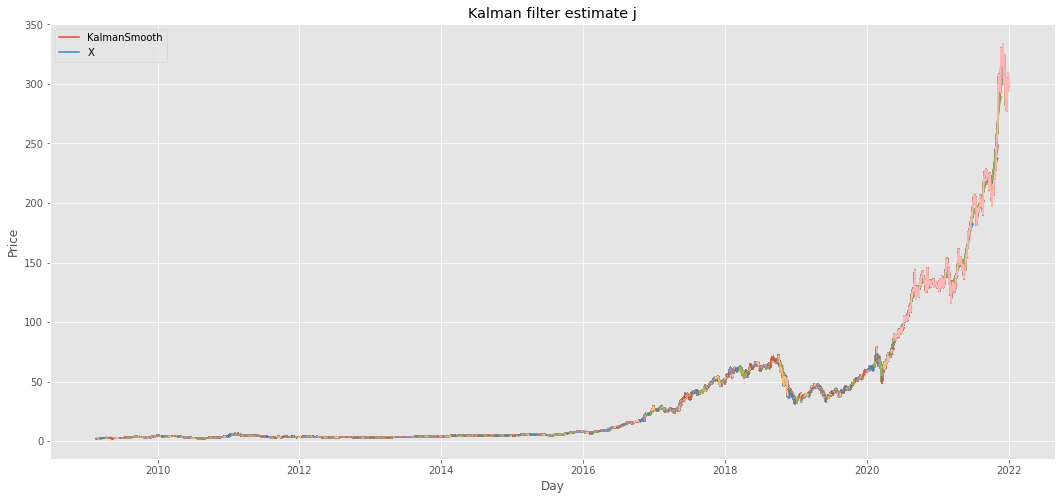

In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
        """
        Tratamiento de los returns, mejor en las funciones de analisis que hacer aquí.
        if(recogo['senal'] == 1 ):
            dff.loc[[endWindow],['Senal']]= 1
        elif(recogo['senal'] == 0 ):
            dff.loc[[endWindow],['Senal']]= 0
        elif(recogo['senal'] == -1 ):
            dff.loc[[endWindow],['Senal']]= -1            
        elif(recogo['senal'] == 503 ):
            dff.loc[[endWindow],['Senal']]= 0          
        """
            
    else:
        print('..............Día sin sesión, next please (notebook)')

        

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2021-12-28,2021-12-28,0,303.220001,NaN,NaN,NaN
2021-12-29,2021-12-29,1,300.01001,NaN,NaN,30.680553
2021-12-30,2021-12-30,0,295.859985,NaN,-1,NaN
2021-12-31,2021-12-31,1,294.109985,NaN,NaN,28.026666
2022-01-03,2022-01-03,1,301.209991,NaN,NaN,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

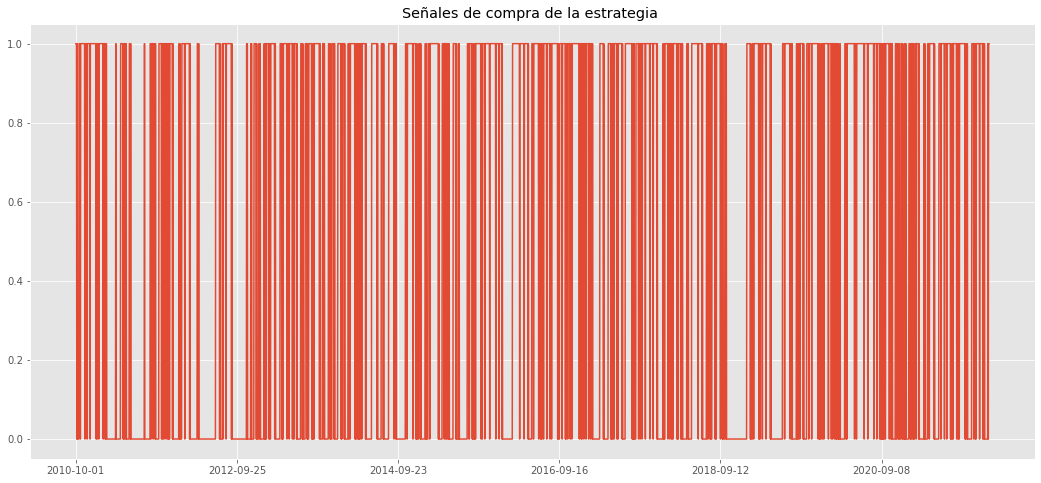

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"segundos") #En segundos

El tiempo de ejecucion fue: 2869.871268749237 segundos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2011-01-04,2011-01-04,1,3.9425,NaN,NaN,NaN
2011-01-05,2011-01-05,0,4.245,NaN,1,NaN
2011-01-06,2011-01-06,1,4.8325,NaN,NaN,0.328901
2011-01-07,2011-01-07,1,4.9675,NaN,NaN,NaN
2011-01-10,2011-01-10,1,5.1575,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-10-29,2019-10-29,1,50.73,NaN,NaN,2.920998
2019-10-30,2019-10-30,1,50.75,NaN,NaN,NaN
2019-10-31,2019-10-31,1,50.255001,NaN,NaN,NaN
2019-11-01,2019-11-01,1,50.647499,NaN,NaN,NaN


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2021-12-28,2021-12-28,0,303.220001,NaN,NaN,NaN,-0.020133,-0.0,595.470828
2021-12-29,2021-12-29,1,300.01001,NaN,NaN,30.680553,-0.010586,-0.0,595.470828
2021-12-30,2021-12-30,0,295.859985,NaN,-1,NaN,-0.013833,-0.013833,587.233708
2021-12-31,2021-12-31,1,294.109985,NaN,NaN,28.026666,-0.005915,-0.0,587.233708
2022-01-03,2022-01-03,1,301.209991,NaN,NaN,NaN,0.024141,0.024141,601.409911


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2010-12-28,2010-12-28,1,3.735,NaN,NaN,NaN,-0.004000,-0.004,123.371389
2010-12-29,2010-12-29,1,3.735,NaN,NaN,NaN,0.000000,0.0,123.371389
2010-12-30,2010-12-30,1,3.7475,NaN,NaN,NaN,0.003347,0.003347,123.78428
2010-12-31,2010-12-31,0,3.85,NaN,1,NaN,0.027352,0.027352,127.169973
2011-01-03,2011-01-03,1,3.955,NaN,NaN,0.194478,0.027273,0.0,127.169973
...,...,...,...,...,...,...,...,...,...
2021-12-28,2021-12-28,0,303.220001,NaN,NaN,NaN,-0.020133,-0.0,595.470828
2021-12-29,2021-12-29,1,300.01001,NaN,NaN,30.680553,-0.010586,-0.0,595.470828
2021-12-30,2021-12-30,0,295.859985,NaN,-1,NaN,-0.013833,-0.013833,587.233708
2021-12-31,2021-12-31,1,294.109985,NaN,NaN,28.026666,-0.005915,-0.0,587.233708


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

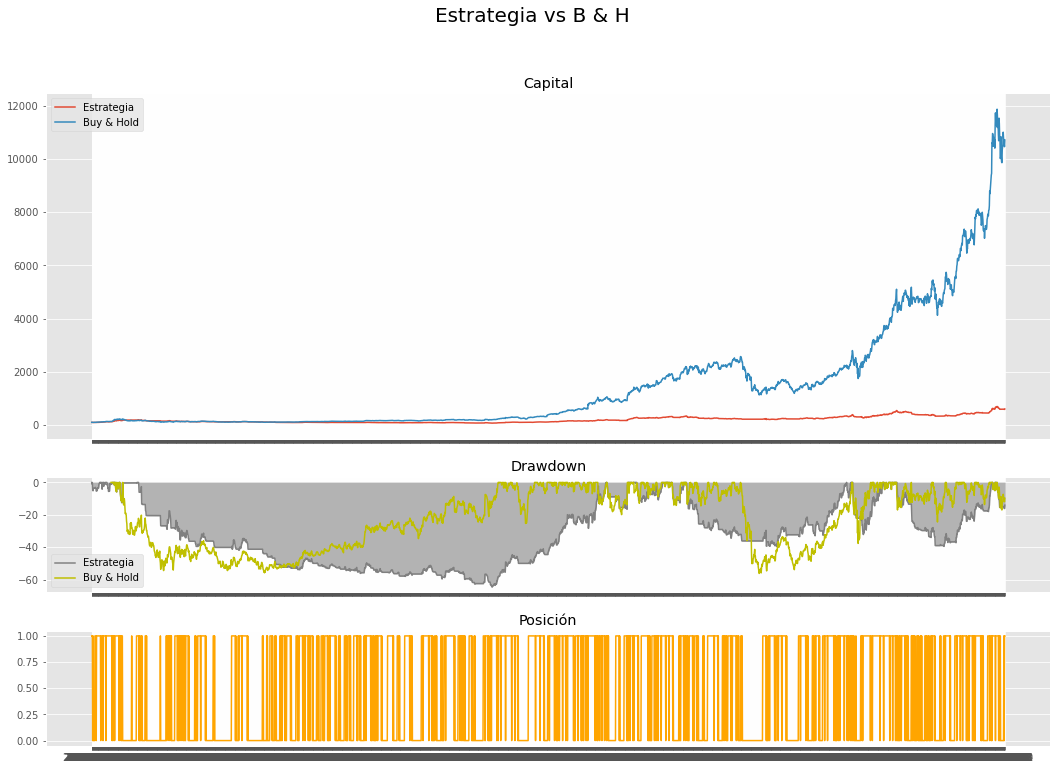

In [25]:
grafico(data)

---

In [26]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [27]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 502.38 €  con una inverison de 100€


In [28]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 17.38%


In [29]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.174


In [30]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

C:\Users\INNOVACION\Documents\J3\100.- cursos\Quant_udemy\programas\Projects\kalmanIndicator\quant_j3_lib.py:870: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  sheet_name="data")


---


---